In [0]:
import pandas as pd
import numpy as np
import os

import teradatasql

import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from statsmodels.tsa.stattools import adfuller

import itertools
import optuna
from statsmodels.tsa.statespace.sarimax import SARIMAX

from datetime import datetime,date,timedelta
from dateutil.relativedelta import relativedelta

### Reading Sales Data

In [0]:
# %sql
# SELECT distinct (c.AG)
#         FROM ABFRL_CATALOG.PFRL_VRDM.sls_summary as s
#         LEFT JOIN ABFRL_CATALOG.PFRL_VRDM.sls_marticle as a on s.article_code=a.article_code 
#         LEFT JOIN ABFRL_CATALOG.PFRL_VRDM.sls_marticlehierarchy as h on a.mc_code=h.mc_code
#         LEFT JOIN ABFRL_CATALOG.PFRL_REPORTS_VIEWS.cube_ag_dg_master as c on a.article_code = c.article_code
#         JOIN ABFRL_CATALOG.PFRL_VRDM.sls_msite as st on s.site_code=st.site_code 
#         WHERE h.mc_type = ('PT')
#         and h.new_simplified_product in ('T-SHIRT')
#         and h.new_mc_product_class in ('C/CP') 
#         and st.concept in ('PT','PW','PK') 
#         and h.new_brand_description='AJILE' 
#         and s.bill_type in ('ZPOS','ZRMS','ZBOS','ZOMB','ZOMS','ZBMS') 
#         and h.new_world='MEN APPAREL'
#         and c.AG not in ('NA', '!_DROPPED');

In [0]:
df = spark.sql(f'''
        SELECT s.sls_date as SLS_Date, SUM(s.sls_qty) as SLS_Qty, s.site_code as Site_Code
        FROM ABFRL_CATALOG.PFRL_VRDM.sls_summary as s
        LEFT JOIN ABFRL_CATALOG.PFRL_VRDM.sls_marticle as a on s.article_code=a.article_code 
        LEFT JOIN ABFRL_CATALOG.PFRL_VRDM.sls_marticlehierarchy as h on a.mc_code=h.mc_code
        LEFT JOIN ABFRL_CATALOG.PFRL_REPORTS_VIEWS.cube_ag_dg_master as c on a.article_code = c.article_code
        JOIN ABFRL_CATALOG.PFRL_VRDM.sls_msite as st on s.site_code=st.site_code 
        WHERE h.mc_type = ('PT')
        and h.new_simplified_product in ('T-SHIRT')
        and h.new_mc_product_class in ('C/CP') 
        and st.concept in ('PT','PW','PK') 
        and h.new_brand_description='AJILE' 
        and s.bill_type in ('ZPOS','ZRMS','ZBOS','ZOMB','ZOMS','ZBMS') 
        and h.new_world='MEN APPAREL'
        and c.AG not in ('NA', '!_DROPPED')
        group by s.sls_date, s.site_code;
        ''').toPandas()

In [0]:
df['SLS_Qty'] = pd.to_numeric(df['SLS_Qty'], errors='coerce')
df

,SLS_Date,SLS_Qty,Site_Code
0,2024-06-25,11.0,P553
1,2024-06-26,86.0,P016
2,2024-06-01,4.0,P486
3,2024-05-18,8.0,P265
4,2024-06-06,1.0,P477
...,...,...,...
614447,2024-07-23,1.0,P406
614448,2024-08-19,1.0,P094
614449,2024-09-07,1.0,P147
614450,2024-08-19,2.0,P229


In [0]:
sales_df = df.copy()
sales_df['SLS_Date'] = pd.to_datetime(sales_df['SLS_Date'])
sales_df.sort_values(by=['SLS_Date'], inplace =True)
sales_df.set_index('SLS_Date',inplace=True)

In [0]:
sales_df

,SLS_Qty,Site_Code
SLS_Date,,
2018-01-01,1.0,P118
2018-01-01,1.0,P172
2018-01-01,1.0,P121
2018-01-01,5.0,P125
2018-01-01,1.0,P296
...,...,...
2024-09-16,5.0,P308
2024-09-16,2.0,P210
2024-09-16,2.0,P332


In [0]:
monthly_df = sales_df.resample('M').agg({ 'Site_Code': 'nunique','SLS_Qty': 'sum'})
# monthly_df = sales_df.resample('M').agg({'SLS_Qty': 'sum'})
monthly_df = monthly_df[:-1]
monthly_df

,Site_Code,SLS_Qty
SLS_Date,,
2018-01-31,228,17714.0
2018-02-28,237,28968.0
2018-03-31,251,61768.0
2018-04-30,258,85547.0
2018-05-31,259,68688.0
...,...,...
2024-04-30,410,59697.0
2024-05-31,410,54098.0
2024-06-30,412,73658.0


### Monthly Sales Graph

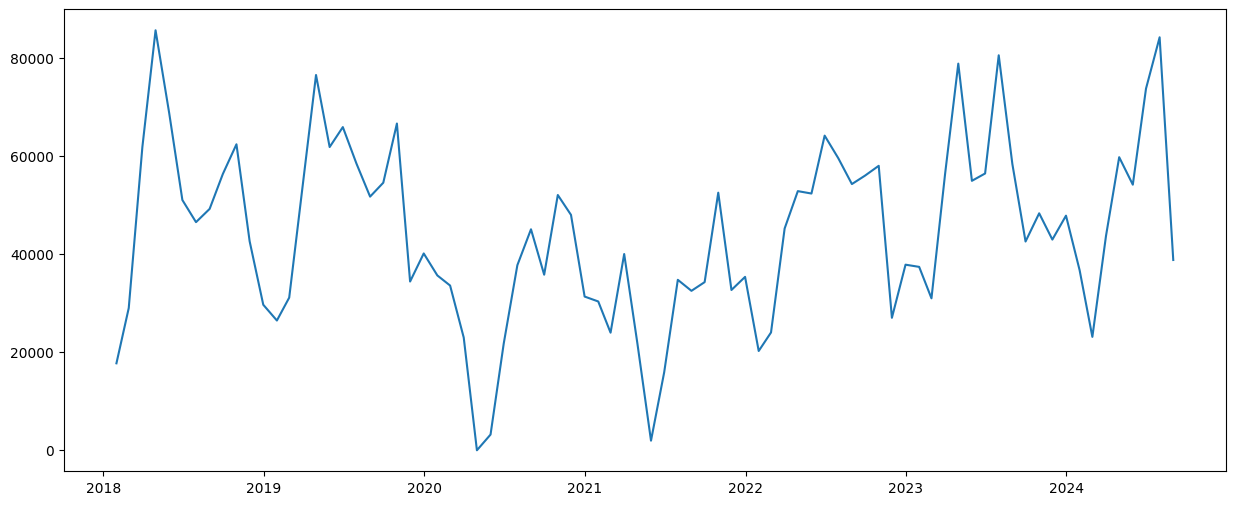

In [0]:
plt.figure(figsize=(15,6))
plt.plot(monthly_df.index,monthly_df['SLS_Qty'])

### EOSS

In [0]:
eoss_df = pd.DataFrame({'SLS_Date':pd.date_range(start=monthly_df.index[0] ,end='2025-03-31',)})

eoss = pd.read_csv('/Workspace/Users/swayam.sharma@abfrl.adityabirla.com/EOSS_Dates.csv')
eoss.columns = ['date','EOSS']
eoss['date'] = pd.to_datetime(eoss['date'])
eoss=eoss[eoss['date']>='2018-01-01']

eoss_df = (eoss_df.merge(eoss, left_on='SLS_Date', right_on='date',how='left'))
eoss_df.drop('date',inplace=True,axis=1)
eoss_df['EOSS'] = eoss_df['EOSS'].fillna(0)
eoss_df.set_index('SLS_Date',inplace=True)

eoss_df.loc[(eoss_df.index >= '2023-06-28') & (eoss_df.index <= '2023-07-31'), 'EOSS'] = 1
eoss_df.loc[(eoss_df.index >= '2023-12-20') & (eoss_df.index <= '2024-01-28'), 'EOSS'] = 1

eoss_df.loc[(eoss_df.index >= '2024-06-28') & (eoss_df.index <= '2024-07-31'), 'EOSS'] = 1
eoss_df.loc[(eoss_df.index >= '2024-12-20') & (eoss_df.index <= '2025-01-31'), 'EOSS'] = 1

# Set EOSS to 1 for specific date ranges for EOSS winter and summer
eoss_df['EOSS_winter'] = 0
eoss_df.loc[(eoss_df['EOSS'] == 1) & ((eoss_df.index.month ==12) | (eoss_df.index.month ==1)), 'EOSS_winter'] = 1
eoss_df['EOSS_summer'] = 0
eoss_df.loc[(eoss_df['EOSS'] == 1) & ((eoss_df.index.month == 6) | (eoss_df.index.month == 7)), 'EOSS_summer'] = 1

eoss_df.drop('EOSS', axis=1, inplace= True)

### COVID

In [0]:
def is_covid(dt):
    year_month={
    2020:[3,4,5,6,7],
    2021:[4,5,6,7],
    }

    if year_month.get(dt.year) and dt.month in year_month.get(dt.year):
        return 1
    return 0
eoss_df['covid'] = eoss_df.index.map(lambda dt:is_covid(dt))

### FESTIVE

In [0]:
def is_festive(dt):
    year_month={
    2018:[10,11],
    2019:[9,10],
    2020:[10,11],
    2021:[10,11],
    2022:[9,10],
    2023:[10,11],
    2024:[9,10],  
    }

    if year_month.get(dt.year) and dt.month in year_month.get(dt.year):
        return 1
    return 0
eoss_df['Festive'] = eoss_df.index.map(lambda dt:is_festive(dt))

In [0]:
# SUMMER REG

In [0]:
# def sum_reg(dt):
#     year_month={
#     2018:[3,4,5,6,7],
#     2019:[3,4,5,6,7],
#     2020:[3,6,7],
#     2021:[3,4,6,7],
#     2022:[3,4,5,6,7],
#     2023:[3,4,5,6,7],
#     2024:[3,4,5,6,7],
#     }

#     if year_month.get(dt.year) and dt.month in year_month.get(dt.year):
#         return 1
#     return 0
# eoss_df['Summer Reg'] = eoss_df.index.map(lambda dt:sum_reg(dt))

In [0]:
eoss_df = eoss_df.resample('M').sum()

In [0]:
# eoss_df['EOSS_winter'] = np.round(eoss_df['EOSS_winter']/eoss_df.index.day,2)
# eoss_df['EOSS_summer'] = np.round(eoss_df['EOSS_summer']/eoss_df.index.day,2)
# eoss_df['covid'] = np.round(eoss_df['covid']/eoss_df.index.day,2)
# eoss_df['Festive'] = np.round(eoss_df['Festive']/eoss_df.index.day,2)

In [0]:
monthly_grouped_df = (eoss_df.merge(monthly_df, right_on='SLS_Date', left_on=eoss_df.index ,how='left'))

In [0]:
monthly_grouped_df.set_index('SLS_Date', inplace=True)

In [0]:
monthly_grouped_df

,EOSS_winter,EOSS_summer,covid,Festive,Site_Code,SLS_Qty
SLS_Date,,,,,,
2018-01-31,1,0,0,0,228.0,17714.0
2018-02-28,0,0,0,0,237.0,28968.0
2018-03-31,0,0,0,0,251.0,61768.0
2018-04-30,0,0,0,0,258.0,85547.0
2018-05-31,0,0,0,0,259.0,68688.0
...,...,...,...,...,...,...
2024-11-30,0,0,0,0,NaN,NaN
2024-12-31,12,0,0,0,NaN,NaN
2025-01-31,31,0,0,0,NaN,NaN


In [0]:
grouped_df = monthly_grouped_df[monthly_grouped_df.index >= '2021-08-01']

### Adding No. of Stores

In [0]:
mapping_df = pd.DataFrame({
    'SLS_Date': ['2024-09-30', '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31', '2025-02-28', '2025-03-31'],
    'Site_Code': [416, 415, 415, 416, 416, 418, 422]
})
mapping_df['SLS_Date'] = pd.to_datetime(mapping_df['SLS_Date'])
mapping_df

,SLS_Date,Site_Code
0,2024-07-31,413
1,2024-08-31,415
2,2024-09-30,416
3,2024-10-31,415
4,2024-11-30,415
5,2024-12-31,416
6,2025-01-31,416
7,2025-02-28,418
8,2025-03-31,422


In [0]:
# Merge the mapping DataFrame with the original DataFrame
monthly_grouped_df = monthly_grouped_df.merge(mapping_df, on='SLS_Date', how='left', suffixes=('', '_y'))

In [0]:
# Fill NaN values in Site_Code with the mapped values
monthly_grouped_df['Site_Code'].fillna(monthly_grouped_df['Site_Code_y'], inplace=True)

In [0]:
# Drop the extra column created by the merge
monthly_grouped_df.drop(columns=['Site_Code_y'], inplace=True)

In [0]:
monthly_grouped_df.fillna(0, inplace= True)
monthly_grouped_df.tail(20)

,SLS_Date,EOSS_winter,EOSS_summer,covid,Festive,Site_Code,SLS_Qty
67,2023-08-31,0,0,0,0,431.0,58310.0
68,2023-09-30,0,0,0,0,432.0,42522.0
69,2023-10-31,0,0,0,31,434.0,48269.0
70,2023-11-30,0,0,0,30,436.0,42915.0
71,2023-12-31,12,0,0,0,436.0,47787.0
72,2024-01-31,28,0,0,0,435.0,36683.0
73,2024-02-29,0,0,0,0,432.0,23102.0
74,2024-03-31,0,0,0,0,423.0,43661.0
75,2024-04-30,0,0,0,0,410.0,59697.0
76,2024-05-31,0,0,0,0,410.0,54098.0


In [0]:
monthly_grouped_df.set_index('SLS_Date', inplace=True)

In [0]:
monthly_grouped_df

,EOSS_winter,EOSS_summer,covid,Festive,Site_Code,SLS_Qty
SLS_Date,,,,,,
2018-01-31,1,0,0,0,228.0,17714.0
2018-02-28,0,0,0,0,237.0,28968.0
2018-03-31,0,0,0,0,251.0,61768.0
2018-04-30,0,0,0,0,258.0,85547.0
2018-05-31,0,0,0,0,259.0,68688.0
...,...,...,...,...,...,...
2024-11-30,0,0,0,0,415.0,0.0
2024-12-31,12,0,0,0,416.0,0.0
2025-01-31,31,0,0,0,416.0,0.0


## SARIMAX

In [0]:
#Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(monthly_grouped_df['SLS_Qty'][:-8], autolag= 'AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 -3.478199
p-value                         0.008565
#Lags Used                      3.000000
Number of Observations Used    75.000000
Critical Value (1%)            -3.520713
Critical Value (5%)            -2.900925
Critical Value (10%)           -2.587781
dtype: float64


In [0]:
# from statsmodels.graphics.tsaplots import plot_acf
# plt.figure(figsize=(20,5))
# plt.grid()
# plot_acf(monthly_grouped_df['SLS_Qty'][:-7], ax=plt.gca(), lags = 15)
# plt.show()

In [0]:
# from statsmodels.graphics.tsaplots import plot_pacf
# plt.figure(figsize=(20,5))
# plt.grid()
# plot_pacf(monthly_grouped_df['SLS_Qty'][:-7], ax=plt.gca(), lags = 15)
# plt.show()

In [0]:
monthly_df = monthly_grouped_df[['SLS_Qty']]
regressors_df = monthly_grouped_df.drop('SLS_Qty', axis=1)

In [0]:
 # Min Max Scaling
from sklearn.preprocessing import MinMaxScaler

scaler_sales = MinMaxScaler()
scaled_sales = scaler_sales.fit_transform(monthly_df)
sales = pd.DataFrame(scaled_sales, columns=monthly_df.columns, index=monthly_df.index)

scaler_regressors = MinMaxScaler()
scaled_regressors = scaler_regressors.fit_transform(regressors_df)
regressors = pd.DataFrame(scaled_regressors, columns=regressors_df.columns, index=regressors_df.index)

In [0]:
# Split data into train / test sets
# sales_train,sales_test = monthly_df[monthly_df.index<='2023-05-31'],monthly_df[monthly_df.index>'2023-05-31']
# reg_train,reg_test = regressors_df[regressors_df.index<='2023-05-31'],regressors_df[regressors_df.index>'2023-05-31']

# Split data into train / test sets
sales_train,sales_test = sales[sales.index<='2024-05-31'],sales[sales.index>'2024-05-31']
reg_train,reg_test = regressors[regressors.index<='2024-05-31'],regressors[regressors.index>'2024-05-31']

### OPTUNA to find best order

In [0]:
reg_test_optuna = reg_test[reg_test.index <= '2024-08-31']
sales_test_optuna = sales_test[sales_test.index <= '2024-08-31']

In [0]:
sales_test_optuna

,SLS_Qty
SLS_Date,
2024-06-30,0.861024
2024-07-31,0.983272
2024-08-31,0.453061


In [0]:
p = q = range(0, 4)
d = range(0, 2)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [0]:
%%capture
%%time
def objective_sarima(trial):
    order=trial.suggest_categorical('order',pdq)
    seasonal_order=trial.suggest_categorical('seasonal_order',pdqs)
    try:
        model = SARIMAX(sales_train['SLS_Qty'], 
                    order = order, 
                    seasonal_order = seasonal_order,
                    exog = reg_train
                    ).fit()
        start = len(sales_train)
        end = len(sales_train) + 3
        
        predictions = model.predict(start, end,
                                    typ = 'levels', exog = reg_test_optuna).to_frame()

        residuals = np.abs(sales_test_optuna['SLS_Qty'] - predictions['predicted_mean']).to_frame()
        mape  = (residuals[0]/sales_test_optuna['SLS_Qty'])*100
        mape=mape[-12:].mean()
        return mape
    except:
        return 999
study=optuna.create_study(direction="minimize")
study.optimize(objective_sarima,n_trials=250);

[I 2024-09-17 07:08:24,448] A new study created in memory with name: no-name-124e732d-6b71-4c0d-a491-699f52383e97
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.91552D-01    |proj g|=  5.06526D+00

At iterate    5    f= -5.25889D-01    |proj g|=  2.95361D+00

At iterate   10    f= -7.91487D-01    |proj g|=  1.96774D-01

At iterate   15    f= -8.26095D-01    |proj g|=  2.35583D-01

At iterate   20    f= -8.34551D-01    |proj g|=  9.54103D-02

At iterate   25    f= -8.36633D-01    |proj g|=  5.29132D-02

At iterate   30    f= -8.40990D-01    |proj g|=  1.94766D-02

At iterate   35    f= -8.41175D-01    |proj g|=  4.27315D-02

At iterate   40    f= -8.41265D-01    |proj g|=  1.30842D-02

At iterate   45    f= -8.41301D-01    |proj g|=  4.02911D-03

At iterate   50    f= -8.41355D-01    |proj g|=  1.15091D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:08:30,438] Trial 0 finished with value: 999.0 and parameters: {'order': (2, 0, 1), 'seasonal_order': (3, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.95721D-01    |proj g|=  2.26684D+00

At iterate    5    f= -6.38348D-01    |proj g|=  3.60320D+00

At iterate   10    f= -7.67249D-01    |proj g|=  3.23165D-01

At iterate   15    f= -7.86941D-01    |proj g|=  1.86335D-01

At iterate   20    f= -7.88113D-01    |proj g|=  1.19791D-01

At iterate   25    f= -7.90863D-01    |proj g|=  2.62840D-02

At iterate   30    f= -7.93089D-01    |proj g|=  2.96702D-02

At iterate   35    f= -7.96047D-01    |proj g|=  4.82104D-02

At iterate   40    f= -7.96247D-01    |proj g|=  2.37676D-02

At iterate   45    f= -7.96694D-01    |proj g|=  1.28329D-02

At iterate   50    f= -7.97040D-01    |proj g|=  1.19955D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:08:35,285] Trial 1 finished with value: 999.0 and parameters: {'order': (2, 0, 3), 'seasonal_order': (0, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.25207D-01    |proj g|=  8.55918D-01

At iterate    5    f= -7.34247D-01    |proj g|=  6.13193D-01

At iterate   10    f= -7.45370D-01    |proj g|=  8.39259D-02

At iterate   15    f= -7.61032D-01    |proj g|=  5.66191D-02

At iterate   20    f= -7.67719D-01    |proj g|=  7.77208D-02

At iterate   25    f= -7.74095D-01    |proj g|=  1.14798D-01

At iterate   30    f= -7.75027D-01    |proj g|=  3.19430D-02

At iterate   35    f= -7.75919D-01    |proj g|=  9.97709D-03

At iterate   40    f= -7.76451D-01    |proj g|=  5.29903D-02

At iterate   45    f= -7.77802D-01    |proj g|=  7.19278D-02


[I 2024-09-17 07:08:39,647] Trial 2 finished with value: 999.0 and parameters: {'order': (3, 0, 3), 'seasonal_order': (1, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.78414D-01    |proj g|=  2.58788D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     59      1     0     0   2.588D-02  -7.784D-01
  F = -0.77841366975625403     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.18115D-01    |proj g|=  1.05064D+00


 This problem is unconstrained.



At iterate    5    f= -7.94680D-01    |proj g|=  5.97671D-01

At iterate   10    f= -8.23351D-01    |proj g|=  2.49143D-02

At iterate   15    f= -8.25201D-01    |proj g|=  4.84432D-02

At iterate   20    f= -8.26805D-01    |proj g|=  2.74090D-01

At iterate   25    f= -8.27640D-01    |proj g|=  1.07194D-01

At iterate   30    f= -8.29101D-01    |proj g|=  6.40459D-02

At iterate   35    f= -8.32211D-01    |proj g|=  1.19947D-01

At iterate   40    f= -8.33363D-01    |proj g|=  1.40029D-02

At iterate   45    f= -8.33536D-01    |proj g|=  2.38644D-02


[I 2024-09-17 07:08:41,526] Trial 3 finished with value: 999.0 and parameters: {'order': (1, 0, 2), 'seasonal_order': (1, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.33634D-01    |proj g|=  7.13489D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     59      1     0     0   7.135D-03  -8.336D-01
  F = -0.83363409637445640     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.18874D-01    |proj g|=  2.75090D-01


 This problem is unconstrained.



At iterate    5    f= -7.40662D-01    |proj g|=  4.88449D-01

At iterate   10    f= -7.57644D-01    |proj g|=  3.19573D-01

At iterate   15    f= -7.60727D-01    |proj g|=  5.17421D-02

At iterate   20    f= -7.60904D-01    |proj g|=  7.96333D-02

At iterate   25    f= -7.61560D-01    |proj g|=  1.81371D-02

At iterate   30    f= -7.62061D-01    |proj g|=  2.35658D-02

At iterate   35    f= -7.62546D-01    |proj g|=  5.16868D-02

At iterate   40    f= -7.63865D-01    |proj g|=  2.26337D-01

At iterate   45    f= -7.66960D-01    |proj g|=  7.19512D-02

At iterate   50    f= -7.68585D-01    |proj g|=  1.39056D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-17 07:08:46,691] Trial 4 finished with value: 999.0 and parameters: {'order': (3, 0, 0), 'seasonal_order': (2, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.76384D-01    |proj g|=  5.46533D-01

At iterate    5    f= -7.28876D-01    |proj g|=  4.90915D-01

At iterate   10    f= -7.62042D-01    |proj g|=  2.00479D-01

At iterate   15    f= -7.73710D-01    |proj g|=  1.61688D-01

At iterate   20    f= -7.87077D-01    |proj g|=  4.43547D-01

At iterate   25    f= -7.94695D-01    |proj g|=  3.02859D-01

At iterate   30    f= -8.03633D-01    |proj g|=  2.40577D-01

At iterate   35    f= -8.11089D-01    |proj g|=  5.16341D-02

At iterate   40    f= -8.12626D-01    |proj g|=  1.25443D-02

At iterate   45    f= -8.12794D-01    |proj g|=  1.29858D-02

At iterate   50    f= -8.12895D-01    |proj g|=  5.09272D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:08:52,448] Trial 5 finished with value: 999.0 and parameters: {'order': (0, 1, 3), 'seasonal_order': (2, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.70217D-01    |proj g|=  1.05633D+00

At iterate    5    f= -7.23236D-01    |proj g|=  1.52999D-01

At iterate   10    f= -7.51096D-01    |proj g|=  4.23586D-02

At iterate   15    f= -7.55532D-01    |proj g|=  8.13887D-02

At iterate   20    f= -7.57039D-01    |proj g|=  6.14019D-03

At iterate   25    f= -7.57080D-01    |proj g|=  5.25361D-03

At iterate   30    f= -7.57088D-01    |proj g|=  6.97969D-04

At iterate   35    f= -7.57088D-01    |proj g|=  2.54901D-04


[I 2024-09-17 07:08:54,584] Trial 6 finished with value: 999.0 and parameters: {'order': (3, 1, 0), 'seasonal_order': (2, 1, 0, 12)}. Best is trial 0 with value: 999.0.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     37     49      1     0     0   1.253D-04  -7.571D-01
  F = -0.75708767928909204     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.59934D-01    |proj g|=  2.12554D+00


 This problem is unconstrained.



At iterate    5    f= -7.69291D-01    |proj g|=  1.52142D-01

At iterate   10    f= -8.19951D-01    |proj g|=  9.67481D-02

At iterate   15    f= -8.36251D-01    |proj g|=  3.74304D-01

At iterate   20    f= -8.52223D-01    |proj g|=  1.68619D-01

At iterate   25    f= -8.64977D-01    |proj g|=  3.12518D-02

At iterate   30    f= -8.68627D-01    |proj g|=  3.57179D-02

At iterate   35    f= -8.69205D-01    |proj g|=  6.52859D-03

At iterate   40    f= -8.69265D-01    |proj g|=  1.94211D-02

At iterate   45    f= -8.69339D-01    |proj g|=  1.50558D-02


[I 2024-09-17 07:08:56,948] Trial 7 finished with value: 999.0 and parameters: {'order': (0, 1, 3), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.69497D-01    |proj g|=  7.15869D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     63      1     0     0   7.159D-02  -8.695D-01
  F = -0.86949737774149449     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.32014D-01    |proj g|=  1.39266D+00


 This problem is unconstrained.



At iterate    5    f= -7.07380D-01    |proj g|=  2.78720D-01

At iterate   10    f= -7.42519D-01    |proj g|=  4.95583D-01

At iterate   15    f= -7.75628D-01    |proj g|=  1.47904D-01

At iterate   20    f= -7.81308D-01    |proj g|=  3.03859D-02

At iterate   25    f= -7.84307D-01    |proj g|=  2.66247D-02

At iterate   30    f= -7.84474D-01    |proj g|=  1.89171D-02

At iterate   35    f= -7.84565D-01    |proj g|=  1.57082D-03

At iterate   40    f= -7.84567D-01    |proj g|=  1.75622D-03

At iterate   45    f= -7.84568D-01    |proj g|=  1.10265D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     47     61   

[I 2024-09-17 07:09:00,927] Trial 8 finished with value: 999.0 and parameters: {'order': (0, 1, 1), 'seasonal_order': (3, 1, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.05816D-01    |proj g|=  5.57712D-01

At iterate    5    f= -7.88144D-01    |proj g|=  8.17876D-01

At iterate   10    f= -8.03600D-01    |proj g|=  2.85971D-01

At iterate   15    f= -8.08177D-01    |proj g|=  2.01891D-01

At iterate   20    f= -8.10153D-01    |proj g|=  2.61666D-02

At iterate   25    f= -8.11528D-01    |proj g|=  3.66108D-02

At iterate   30    f= -8.11581D-01    |proj g|=  2.58913D-03

At iterate   35    f= -8.11608D-01    |proj g|=  3.76857D-02

At iterate   40    f= -8.11895D-01    |proj g|=  1.10204D-02


[I 2024-09-17 07:09:01,760] Trial 9 finished with value: 999.0 and parameters: {'order': (1, 0, 2), 'seasonal_order': (1, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   45    f= -8.11958D-01    |proj g|=  5.91828D-03

At iterate   50    f= -8.11966D-01    |proj g|=  2.61108D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     57      1     0     0   2.611D-03  -8.120D-01
  F = -0.81196648644739500     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.81109D-01    |proj g|=  1.29751D+00


 This problem is unconstrained.



At iterate    5    f= -7.87430D-01    |proj g|=  7.53590D-01

At iterate   10    f= -8.16698D-01    |proj g|=  1.54585D-01

At iterate   15    f= -8.30315D-01    |proj g|=  7.95284D-02

At iterate   20    f= -8.33250D-01    |proj g|=  1.50094D-01

At iterate   25    f= -8.35783D-01    |proj g|=  7.50860D-03

At iterate   30    f= -8.35847D-01    |proj g|=  2.72997D-03

At iterate   35    f= -8.35866D-01    |proj g|=  2.76116D-03

At iterate   40    f= -8.35983D-01    |proj g|=  7.41192D-02

At iterate   45    f= -8.36642D-01    |proj g|=  1.38655D-01


[I 2024-09-17 07:09:06,361] Trial 10 finished with value: 999.0 and parameters: {'order': (0, 0, 2), 'seasonal_order': (3, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.38533D-01    |proj g|=  1.45345D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     59      1     0     0   1.453D-02  -8.385D-01
  F = -0.83853340837991452     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.95721D-01    |proj g|=  2.26684D+00

At iterate    5    f= -6.38348D-01    |proj g|=  3.60320D+00

At iterate   10    f= -7.67249D-01    |proj g|=  3.23165D-01

At iterate   15    f= -7.86941D-01    |proj g|=  1.86335D-01

At iterate   20    f= -7.88113D-01    |proj g|=  1.19791D-01

At iterate   25    f= -7.90863D-01    |proj g|=  2.62840D-02

At iterate   30    f= -7.93089D-01    |proj g|=  2.96702D-02

At iterate   35    f= -7.96047D-01    |proj g|=  4.82104D-02

At iterate   40    f= -7.96247D-01    |proj g|=  2.37676D-02

At iterate   45    f= -7.96694D-01    |proj g|=  1.28329D-02


[I 2024-09-17 07:09:09,399] Trial 11 finished with value: 999.0 and parameters: {'order': (2, 0, 3), 'seasonal_order': (0, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.97040D-01    |proj g|=  1.19955D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     57      1     0     0   1.200D-02  -7.970D-01
  F = -0.79703968648270651     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.21609D-01    |proj g|=  2.75649D-01

At iterate    5    f= -7.41464D-01    |proj g|=  4.87951D-01

At iterate   10    f= -7.55841D-01    |proj g|=  1.47625D-01

At iterate   15    f= -7.58164D-01    |proj g|=  5.86766D-02

At iterate   20    f= -7.60459D-01    |proj g|=  6.08990D-02

At iterate   25    f= -7.68440D-01    |proj g|=  1.49092D-01

At iterate   30    f= -7.96113D-01    |proj g|=  6.06199D-01

At iterate   35    f= -8.04246D-01    |proj g|=  3.43640D-02

At iterate   40    f= -8.11661D-01    |proj g|=  6.82543D-02

At iterate   45    f= -8.12763D-01    |proj g|=  3.61814D-02

At iterate   50    f= -8.13272D-01    |proj g|=  6.63659D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:09:15,040] Trial 12 finished with value: 999.0 and parameters: {'order': (2, 0, 1), 'seasonal_order': (3, 1, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.22338D-01    |proj g|=  9.16954D-01

At iterate    5    f= -7.32375D-01    |proj g|=  6.31749D-01

At iterate   10    f= -7.47519D-01    |proj g|=  1.25590D-01

At iterate   15    f= -7.57404D-01    |proj g|=  2.06060D-01

At iterate   20    f= -7.68746D-01    |proj g|=  2.69123D-01

At iterate   25    f= -7.78967D-01    |proj g|=  6.01094D-02

At iterate   30    f= -7.85945D-01    |proj g|=  2.90331D-02

At iterate   35    f= -7.88067D-01    |proj g|=  1.67227D-02

At iterate   40    f= -7.88723D-01    |proj g|=  2.05426D-02

At iterate   45    f= -7.88981D-01    |proj g|=  1.38582D-02


[I 2024-09-17 07:09:18,022] Trial 13 finished with value: 999.0 and parameters: {'order': (2, 0, 3), 'seasonal_order': (0, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.89037D-01    |proj g|=  3.70615D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     58      1     0     0   3.706D-03  -7.890D-01
  F = -0.78903665563639902     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.56982D-01    |proj g|=  8.96387D-01


 This problem is unconstrained.



At iterate    5    f= -7.14795D-01    |proj g|=  8.44905D-02

At iterate   10    f= -7.28861D-01    |proj g|=  1.05418D-01

At iterate   15    f= -7.33214D-01    |proj g|=  1.90544D-01

At iterate   20    f= -7.35537D-01    |proj g|=  2.04039D-01

At iterate   25    f= -7.37786D-01    |proj g|=  1.37911D-01

At iterate   30    f= -7.52312D-01    |proj g|=  6.66618D-02

At iterate   35    f= -7.57486D-01    |proj g|=  7.88658D-02

At iterate   40    f= -7.61937D-01    |proj g|=  7.44328D-02


[I 2024-09-17 07:09:19,649] Trial 14 finished with value: 999.0 and parameters: {'order': (1, 1, 2), 'seasonal_order': (1, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   45    f= -7.62775D-01    |proj g|=  1.20261D-02

At iterate   50    f= -7.62893D-01    |proj g|=  1.86407D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     58      1     0     0   1.864D-03  -7.629D-01
  F = -0.76289322874265153     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.15280D-01    |proj g|=  1.64232D+00

At iterate    5    f= -6.98779D-01    |proj g|=  8.87343D-01

At iterate   10    f= -7.17289D-01    |proj g|=  7.70898D-01

At iterate   15    f= -7.37968D-01    |proj g|=  3.13295D-01

At iterate   20    f= -7.38583D-01    |proj g|=  3.25411D-02

At iterate   25    f= -7.39316D-01    |proj g|=  2.59694D-02

At iterate   30    f= -7.39454D-01    |proj g|=  3.51537D-03


[I 2024-09-17 07:09:20,247] Trial 15 finished with value: 999.0 and parameters: {'order': (1, 0, 0), 'seasonal_order': (0, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   35    f= -7.39458D-01    |proj g|=  7.26279D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     39     49      1     0     0   7.947D-05  -7.395D-01
  F = -0.73945836567727652     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.76722D-01    |proj g|=  5.53226D-01

At iterate    5    f= -7.32404D-01    |proj g|=  5.21951D-01

At iterate   10    f= -7.67030D-01    |proj g|=  1.88787D-01

At iterate   15    f= -7.90383D-01    |proj g|=  1.11640D-01

At iterate   20    f= -7.93220D-01    |proj g|=  8.86432D-02

At iterate   25    f= -7.94373D-01    |proj g|=  3.19479D-02

At iterate   30    f= -7.95368D-01    |proj g|=  4.49478D-02

At iterate   35    f= -7.96510D-01    |proj g|=  5.15884D-02

At iterate   40    f= -7.97657D-01    |proj g|=  1.18660D-02

At iterate   45    f= -7.98174D-01    |proj g|=  3.41984D-02

At iterate   50    f= -7.99303D-01    |proj g|=  6.02206D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:09:26,624] Trial 16 finished with value: 999.0 and parameters: {'order': (1, 1, 3), 'seasonal_order': (3, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.26456D-01    |proj g|=  3.57133D-01

At iterate    5    f= -6.74727D-01    |proj g|=  5.22091D-01

At iterate   10    f= -6.86147D-01    |proj g|=  1.28852D-01

At iterate   15    f= -6.94466D-01    |proj g|=  1.76070D-02

At iterate   20    f= -6.94878D-01    |proj g|=  1.05581D-02

At iterate   25    f= -6.95145D-01    |proj g|=  3.04019D-02

At iterate   30    f= -6.95506D-01    |proj g|=  6.35343D-02

At iterate   35    f= -6.95995D-01    |proj g|=  2.65022D-02

At iterate   40    f= -6.96492D-01    |proj g|=  1.09834D-01

At iterate   45    f= -6.96773D-01    |proj g|=  5.82120D-02

At iterate   50    f= -6.98990D-01    |proj g|=  1.88907D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:09:30,635] Trial 17 finished with value: 999.0 and parameters: {'order': (2, 1, 0), 'seasonal_order': (1, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.09261D-01    |proj g|=  5.54894D-01

At iterate    5    f= -7.76306D-01    |proj g|=  4.28326D-01

At iterate   10    f= -8.03264D-01    |proj g|=  6.97288D-02

At iterate   15    f= -8.23286D-01    |proj g|=  9.01158D-02

At iterate   20    f= -8.28114D-01    |proj g|=  2.60804D-02

At iterate   25    f= -8.31558D-01    |proj g|=  2.33039D-02

At iterate   30    f= -8.33085D-01    |proj g|=  3.06898D-02

At iterate   35    f= -8.34875D-01    |proj g|=  6.60690D-02

At iterate   40    f= -8.35544D-01    |proj g|=  6.35144D-02

At iterate   45    f= -8.35690D-01    |proj g|=  3.20577D-02

At iterate   50    f= -8.35720D-01    |proj g|=  5.35704D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:09:34,319] Trial 18 finished with value: 999.0 and parameters: {'order': (2, 0, 0), 'seasonal_order': (1, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.16621D-01    |proj g|=  2.54577D+00

At iterate    5    f= -7.96660D-01    |proj g|=  4.85801D-01

At iterate   10    f= -8.12757D-01    |proj g|=  9.23250D-01

At iterate   15    f= -8.46695D-01    |proj g|=  1.10144D-01

At iterate   20    f= -8.51087D-01    |proj g|=  2.34525D-02

At iterate   25    f= -8.54968D-01    |proj g|=  5.76799D-02

At iterate   30    f= -8.59021D-01    |proj g|=  9.91065D-02

At iterate   35    f= -8.65263D-01    |proj g|=  1.03743D-01

At iterate   40    f= -8.65487D-01    |proj g|=  6.68285D-03

At iterate   45    f= -8.65735D-01    |proj g|=  1.19013D-02

At iterate   50    f= -8.65946D-01    |proj g|=  3.97697D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:09:35,642] Trial 19 finished with value: 999.0 and parameters: {'order': (2, 1, 1), 'seasonal_order': (1, 0, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.88592D-01    |proj g|=  8.79704D-01

At iterate    5    f= -7.44920D-01    |proj g|=  1.97974D-01

At iterate   10    f= -7.67397D-01    |proj g|=  2.35012D-01

At iterate   15    f= -7.75269D-01    |proj g|=  4.96919D-02

At iterate   20    f= -7.77254D-01    |proj g|=  3.05682D-02

At iterate   25    f= -7.78516D-01    |proj g|=  7.20677D-02

At iterate   30    f= -7.78768D-01    |proj g|=  1.11373D-02

At iterate   35    f= -7.79517D-01    |proj g|=  9.98460D-02

At iterate   40    f= -7.80204D-01    |proj g|=  1.23112D-01

At iterate   45    f= -7.86571D-01    |proj g|=  7.23654D-02

At iterate   50    f= -7.88977D-01    |proj g|=  1.15132D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:09:41,131] Trial 20 finished with value: 999.0 and parameters: {'order': (2, 1, 2), 'seasonal_order': (3, 1, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.25207D-01    |proj g|=  8.55918D-01

At iterate    5    f= -7.34247D-01    |proj g|=  6.13193D-01

At iterate   10    f= -7.45370D-01    |proj g|=  8.39259D-02

At iterate   15    f= -7.61032D-01    |proj g|=  5.66191D-02

At iterate   20    f= -7.67719D-01    |proj g|=  7.77208D-02

At iterate   25    f= -7.74095D-01    |proj g|=  1.14798D-01

At iterate   30    f= -7.75027D-01    |proj g|=  3.19430D-02

At iterate   35    f= -7.75919D-01    |proj g|=  9.97709D-03

At iterate   40    f= -7.76451D-01    |proj g|=  5.29903D-02

At iterate   45    f= -7.77802D-01    |proj g|=  7.19278D-02


[I 2024-09-17 07:09:43,025] Trial 21 finished with value: 999.0 and parameters: {'order': (3, 0, 3), 'seasonal_order': (1, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.78414D-01    |proj g|=  2.58788D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     59      1     0     0   2.588D-02  -7.784D-01
  F = -0.77841366975625403     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.15418D-01    |proj g|=  5.02051D+00


 This problem is unconstrained.



At iterate    5    f= -5.91237D-01    |proj g|=  3.42747D-01

At iterate   10    f= -7.05285D-01    |proj g|=  8.75717D-02

At iterate   15    f= -7.15062D-01    |proj g|=  3.68820D-01

At iterate   20    f= -7.19665D-01    |proj g|=  5.57178D-03

At iterate   25    f= -7.19673D-01    |proj g|=  9.28164D-04

At iterate   30    f= -7.19674D-01    |proj g|=  3.24518D-04

At iterate   35    f= -7.19678D-01    |proj g|=  2.62223D-03

At iterate   40    f= -7.20042D-01    |proj g|=  9.52701D-02

At iterate   45    f= -7.21043D-01    |proj g|=  2.34883D-02


[I 2024-09-17 07:09:44,392] Trial 22 finished with value: 999.0 and parameters: {'order': (0, 0, 0), 'seasonal_order': (2, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.23754D-01    |proj g|=  2.30889D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58      1     0     0   2.309D-01  -7.238D-01
  F = -0.72375424715078096     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.91552D-01    |proj g|=  5.06526D+00


 This problem is unconstrained.



At iterate    5    f= -4.70852D-01    |proj g|=  4.56595D-01

At iterate   10    f= -7.71167D-01    |proj g|=  2.42409D-01

At iterate   15    f= -7.81909D-01    |proj g|=  3.82331D-02

At iterate   20    f= -7.82802D-01    |proj g|=  1.28224D-01

At iterate   25    f= -7.83990D-01    |proj g|=  2.05969D-02

At iterate   30    f= -7.84353D-01    |proj g|=  7.08318D-03

At iterate   35    f= -7.84534D-01    |proj g|=  3.47673D-02

At iterate   40    f= -7.84650D-01    |proj g|=  1.89942D-02

At iterate   45    f= -7.84669D-01    |proj g|=  1.34932D-02

At iterate   50    f= -7.84685D-01    |proj g|=  3.85436D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-17 07:09:47,082] Trial 23 finished with value: 999.0 and parameters: {'order': (2, 0, 1), 'seasonal_order': (0, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.25207D-01    |proj g|=  8.55918D-01

At iterate    5    f= -7.34247D-01    |proj g|=  6.13193D-01

At iterate   10    f= -7.45370D-01    |proj g|=  8.39259D-02

At iterate   15    f= -7.61032D-01    |proj g|=  5.66191D-02

At iterate   20    f= -7.67719D-01    |proj g|=  7.77208D-02

At iterate   25    f= -7.74095D-01    |proj g|=  1.14798D-01

At iterate   30    f= -7.75027D-01    |proj g|=  3.19430D-02

At iterate   35    f= -7.75919D-01    |proj g|=  9.97709D-03

At iterate   40    f= -7.76451D-01    |proj g|=  5.29903D-02

At iterate   45    f= -7.77802D-01    |proj g|=  7.19278D-02


[I 2024-09-17 07:09:49,019] Trial 24 finished with value: 999.0 and parameters: {'order': (3, 0, 3), 'seasonal_order': (1, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.78414D-01    |proj g|=  2.58788D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     59      1     0     0   2.588D-02  -7.784D-01
  F = -0.77841366975625403     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.07221D-01    |proj g|=  2.22721D+00


 This problem is unconstrained.



At iterate    5    f= -7.71337D-01    |proj g|=  1.11533D+00

At iterate   10    f= -8.16050D-01    |proj g|=  3.86144D-01

At iterate   15    f= -8.36381D-01    |proj g|=  1.85526D-01

At iterate   20    f= -8.38535D-01    |proj g|=  1.08271D-01

At iterate   25    f= -8.39362D-01    |proj g|=  7.10979D-02

At iterate   30    f= -8.40027D-01    |proj g|=  3.69301D-02

At iterate   35    f= -8.40390D-01    |proj g|=  5.32349D-03

At iterate   40    f= -8.40585D-01    |proj g|=  3.69488D-03

At iterate   45    f= -8.40627D-01    |proj g|=  1.56577D-02


[I 2024-09-17 07:09:52,232] Trial 25 finished with value: 999.0 and parameters: {'order': (1, 0, 1), 'seasonal_order': (3, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.40938D-01    |proj g|=  1.17006D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     60      1     0     0   1.170D-02  -8.409D-01
  F = -0.84093775601807474     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.89581D-01    |proj g|=  7.11443D-01

At iterate    5    f= -7.38931D-01    |proj g|=  1.45402D-01

At iterate   10    f= -8.04571D-01    |proj g|=  1.11005D-01

At iterate   15    f= -8.19068D-01    |proj g|=  5.82652D-01

At iterate   20    f= -8.49718D-01    |proj g|=  2.24945D-01

At iterate   25    f= -8.59781D-01    |proj g|=  2.19124D-01

At iterate   30    f= -8.80848D-01    |proj g|=  2.75590D-01

At iterate   35    f= -8.89458D-01    |proj g|=  2.19184D-01

At iterate   40    f= -8.98886D-01    |proj g|=  1.05097D-01

At iterate   45    f= -9.02990D-01    |proj g|=  1.65284D-01


[I 2024-09-17 07:09:55,996] Trial 26 finished with value: 999.0 and parameters: {'order': (3, 1, 2), 'seasonal_order': (2, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.06947D-01    |proj g|=  9.06040D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     58      1     0     0   9.060D-02  -9.069D-01
  F = -0.90694706032241712     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.75664D-01    |proj g|=  5.75900D-01


 This problem is unconstrained.



At iterate    5    f= -7.28253D-01    |proj g|=  5.94645D-01

At iterate   10    f= -7.91242D-01    |proj g|=  2.12175D-01

At iterate   15    f= -8.37628D-01    |proj g|=  1.44343D-01

At iterate   20    f= -8.55068D-01    |proj g|=  1.63158D-01

At iterate   25    f= -8.56133D-01    |proj g|=  5.04404D-02

At iterate   30    f= -8.57669D-01    |proj g|=  6.51995D-02

At iterate   35    f= -8.58431D-01    |proj g|=  1.60170D-02

At iterate   40    f= -8.58731D-01    |proj g|=  8.59193D-02

At iterate   45    f= -8.59467D-01    |proj g|=  9.61151D-03


[I 2024-09-17 07:09:59,850] Trial 27 finished with value: 999.0 and parameters: {'order': (3, 1, 3), 'seasonal_order': (1, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.59866D-01    |proj g|=  1.99429D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     58      1     0     0   1.994D-02  -8.599D-01
  F = -0.85986564545046673     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.38576D-01    |proj g|=  5.79735D-01

At iterate    5    f= -7.27761D-01    |proj g|=  1.86438D-01

At iterate   10    f= -7.94980D-01    |proj g|=  2.18880D-01

At iterate   15    f= -8.38392D-01    |proj g|=  5.30428D-01

At iterate   20    f= -8.64579D-01    |proj g|=  2.67250D-01

At iterate   25    f= -8.66234D-01    |proj g|=  7.51209D-02

At iterate   30    f= -8.66686D-01    |proj g|=  4.30125D-02

At iterate   35    f= -8.67729D-01    |proj g|=  3.72457D-02

At iterate   40    f= -8.67920D-01    |proj g|=  8.63581D-03

At iterate   45    f= -8.68038D-01    |proj g|=  1.13737D-02


[I 2024-09-17 07:10:04,778] Trial 28 finished with value: 999.0 and parameters: {'order': (1, 1, 1), 'seasonal_order': (3, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.68280D-01    |proj g|=  8.81077D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     63      1     0     0   8.811D-02  -8.683D-01
  F = -0.86827968173073700     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14788D+00    |proj g|=  7.68135D-01
  ys=-1.503E+00  -gs= 8.276E-01 BFGS update SKIPPED


 This problem is unconstrained.
[I 2024-09-17 07:10:04,883] Trial 29 finished with value: 999.0 and parameters: {'order': (0, 1, 0), 'seasonal_order': (0, 0, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.



At iterate    5    f= -5.02350D-01    |proj g|=  2.90655D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      6     23      2     1     0   2.904D-04  -5.023D-01
  F = -0.50234955267212389     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.77263D-01    |proj g|=  1.79855D+00

At iterate    5    f= -6.87916D-01    |proj g|=  2.46858D-01

At iterate   10    f= -8.10485D-01    |proj g|=  1.23235D-01

At iter

[I 2024-09-17 07:10:08,247] Trial 30 finished with value: 999.0 and parameters: {'order': (0, 0, 3), 'seasonal_order': (2, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.37378D-01    |proj g|=  4.77322D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     59      1     0     0   4.773D-03  -8.374D-01
  F = -0.83737770122449051     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.43705D-01    |proj g|=  6.25898D-01


 This problem is unconstrained.



At iterate    5    f= -7.44657D-01    |proj g|=  2.48596D-01

At iterate   10    f= -8.15809D-01    |proj g|=  6.67896D-02

At iterate   15    f= -8.24509D-01    |proj g|=  6.22187D-02

At iterate   20    f= -8.40017D-01    |proj g|=  1.39064D-01

At iterate   25    f= -8.52622D-01    |proj g|=  1.94182D-01

At iterate   30    f= -8.71250D-01    |proj g|=  5.55556D-02

At iterate   35    f= -8.81380D-01    |proj g|=  2.77337D-01

At iterate   40    f= -9.00204D-01    |proj g|=  1.21515D-01

At iterate   45    f= -9.06554D-01    |proj g|=  6.03805D-02

At iterate   50    f= -9.12317D-01    |proj g|=  9.05557D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-17 07:10:10,736] Trial 31 finished with value: 999.0 and parameters: {'order': (2, 1, 3), 'seasonal_order': (1, 0, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.71871D-01    |proj g|=  7.34993D-01

At iterate    5    f= -7.12029D-01    |proj g|=  1.33761D-01

At iterate   10    f= -7.21279D-01    |proj g|=  9.49403D-02

At iterate   15    f= -7.27679D-01    |proj g|=  5.06725D-02

At iterate   20    f= -7.28524D-01    |proj g|=  1.31211D-02


[I 2024-09-17 07:10:11,053] Trial 32 finished with value: 999.0 and parameters: {'order': (0, 1, 2), 'seasonal_order': (0, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   25    f= -7.28586D-01    |proj g|=  2.28109D-03

At iterate   30    f= -7.28589D-01    |proj g|=  3.62185D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     32     37      1     0     0   9.553D-05  -7.286D-01
  F = -0.72858879851089264     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.37365D-01    |proj g|=  5.77075D+00


 This problem is unconstrained.



At iterate    5    f= -6.45421D-01    |proj g|=  3.73296D+00

At iterate   10    f= -7.30268D-01    |proj g|=  4.69003D-01

At iterate   15    f= -7.45161D-01    |proj g|=  9.03389D-02

At iterate   20    f= -7.46402D-01    |proj g|=  1.05047D-01

At iterate   25    f= -7.48089D-01    |proj g|=  7.69283D-02

At iterate   30    f= -7.50377D-01    |proj g|=  5.37395D-02

At iterate   35    f= -7.87451D-01    |proj g|=  6.51158D-01

At iterate   40    f= -7.94053D-01    |proj g|=  1.03661D-01

At iterate   45    f= -7.97278D-01    |proj g|=  6.05812D-02


[I 2024-09-17 07:10:13,940] Trial 33 finished with value: 999.0 and parameters: {'order': (2, 0, 2), 'seasonal_order': (2, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.99326D-01    |proj g|=  5.47572D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     60      1     0     0   5.476D-02  -7.993D-01
  F = -0.79932585894272579     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.49209D-01    |proj g|=  2.68865D+00

At iterate    5    f= -7.37149D-01    |proj g|=  1.91848D+00

At iterate   10    f= -8.38874D-01    |proj g|=  9.67695D-01

At iterate   15    f= -8.59896D-01    |proj g|=  9.10742D-01

At iterate   20    f= -8.81302D-01    |proj g|=  5.74554D-01

At iterate   25    f= -8.97024D-01    |proj g|=  9.76864D-02

At iterate   30    f= -9.17076D-01    |proj g|=  2.62037D-02

At iterate   35    f= -9.18182D-01    |proj g|=  7.04189D-02

At iterate   40    f= -9.18528D-01    |proj g|=  5.68978D-02

At iterate   45    f= -9.18835D-01    |proj g|=  1.23023D-02


[I 2024-09-17 07:10:17,453] Trial 34 finished with value: 999.0 and parameters: {'order': (3, 1, 1), 'seasonal_order': (3, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.18855D-01    |proj g|=  1.24273D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     57      1     0     0   1.243D-02  -9.189D-01
  F = -0.91885502843529021     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.89094D-01    |proj g|=  7.13736D+00

At iterate    5    f= -5.73933D-01    |proj g|=  2.48525D+00

At iterate   10    f= -6.89057D-01    |proj g|=  3.30619D-01

At iterate   15    f= -6.97844D-01    |proj g|=  1.28605D-01

At iterate   20    f= -6.99038D-01    |proj g|=  3.72610D-02

At iterate   25    f= -7.02179D-01    |proj g|=  4.45486D-02

At iterate   30    f= -7.16242D-01    |proj g|=  6.61364D-01

At iterate   35    f= -7.40374D-01    |proj g|=  8.11799D-02

At iterate   40    f= -7.46669D-01    |proj g|=  1.31102D-01


[I 2024-09-17 07:10:19,408] Trial 35 finished with value: 999.0 and parameters: {'order': (3, 0, 2), 'seasonal_order': (0, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   45    f= -7.47154D-01    |proj g|=  1.04454D-01

At iterate   50    f= -7.47637D-01    |proj g|=  9.39869D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     59      1     0     0   9.399D-03  -7.476D-01
  F = -0.74763684224370841     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.78570D-01    |proj g|=  5.65945D+00

At iterate    5    f= -5.14379D-01    |proj g|=  2.51233D+00

At iterate   10    f= -8.13906D-01    |proj g|=  2.59424D-01

At iterate   15    f= -8.30005D-01    |proj g|=  1.80755D-01

At iterate   20    f= -8.34883D-01    |proj g|=  4.46956D-02

At iterate   25    f= -8.39237D-01    |proj g|=  2.18740D-02

At iterate   30    f= -8.39469D-01    |proj g|=  4.87901D-03

At iterate   35    f= -8.39534D-01    |proj g|=  1.39241D-02

At iterate   40    f= -8.39732D-01    |proj g|=  2.99330D-02

At iterate   45    f= -8.45692D-01    |proj g|=  2.71254D-01


[I 2024-09-17 07:10:23,917] Trial 36 finished with value: 999.0 and parameters: {'order': (1, 0, 2), 'seasonal_order': (3, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.49174D-01    |proj g|=  3.11496D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     63      1     0     0   3.115D-01  -8.492D-01
  F = -0.84917432490372236     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.99332D-01    |proj g|=  2.23955D-01


 This problem is unconstrained.



At iterate    5    f= -7.09153D-01    |proj g|=  2.72722D-01

At iterate   10    f= -7.29254D-01    |proj g|=  3.48855D-02

At iterate   15    f= -7.31762D-01    |proj g|=  3.44891D-02

At iterate   20    f= -7.32453D-01    |proj g|=  1.37951D-02

At iterate   25    f= -7.32510D-01    |proj g|=  6.19997D-03

At iterate   30    f= -7.32581D-01    |proj g|=  2.21754D-02

At iterate   35    f= -7.32592D-01    |proj g|=  9.70586D-03

At iterate   40    f= -7.32602D-01    |proj g|=  3.14774D-03

At iterate   45    f= -7.32604D-01    |proj g|=  2.62698D-04


[I 2024-09-17 07:10:27,470] Trial 37 finished with value: 999.0 and parameters: {'order': (0, 0, 1), 'seasonal_order': (0, 1, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.32604D-01    |proj g|=  2.51032D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     61      1     0     0   2.510D-04  -7.326D-01
  F = -0.73260371658044077     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.96977D-01    |proj g|=  1.65818D+00

At iterate    5    f= -7.54431D-01    |proj g|=  8.68373D-01

At iterate   10    f= -7.84757D-01    |proj g|=  6.90809D-01

At iterate   15    f= -8.15958D-01    |proj g|=  1.85833D-01

At iterate   20    f= -8.16919D-01    |proj g|=  5.48696D-02

At iterate   25    f= -8.18212D-01    |proj g|=  5.40814D-02

At iterate   30    f= -8.18481D-01    |proj g|=  2.32345D-02

At iterate   35    f= -8.18545D-01    |proj g|=  1.24788D-02

At iterate   40    f= -8.18589D-01    |proj g|=  2.62084D-03

At iterate   45    f= -8.18630D-01    |proj g|=  1.42983D-02


[I 2024-09-17 07:10:29,597] Trial 38 finished with value: 999.0 and parameters: {'order': (3, 0, 1), 'seasonal_order': (2, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.19856D-01    |proj g|=  4.35479D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     61      1     0     0   4.355D-02  -8.199D-01
  F = -0.81985645436327492     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.27644D-01    |proj g|=  5.24144D-01


 This problem is unconstrained.



At iterate    5    f= -7.74642D-01    |proj g|=  7.58523D-01

At iterate   10    f= -8.21195D-01    |proj g|=  1.63951D-01

At iterate   15    f= -8.38740D-01    |proj g|=  2.03087D-02

At iterate   20    f= -8.39278D-01    |proj g|=  1.18328D-02

At iterate   25    f= -8.39680D-01    |proj g|=  2.75458D-02

At iterate   30    f= -8.40242D-01    |proj g|=  1.57606D-02

At iterate   35    f= -8.41324D-01    |proj g|=  5.62252D-02

At iterate   40    f= -8.42345D-01    |proj g|=  2.38309D-01

At iterate   45    f= -8.43443D-01    |proj g|=  6.67572D-02

At iterate   50    f= -8.43690D-01    |proj g|=  9.91674D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-17 07:10:34,202] Trial 39 finished with value: 999.0 and parameters: {'order': (3, 0, 0), 'seasonal_order': (3, 0, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.02450D-01    |proj g|=  4.14089D-01

At iterate    5    f= -6.28768D-01    |proj g|=  3.97754D-01

At iterate   10    f= -6.44574D-01    |proj g|=  2.36814D-01

At iterate   15    f= -6.46631D-01    |proj g|=  1.01264D-02

At iterate   20    f= -6.46774D-01    |proj g|=  7.10320D-03

At iterate   25    f= -6.46790D-01    |proj g|=  9.65896D-04


[I 2024-09-17 07:10:35,134] Trial 40 finished with value: 999.0 and parameters: {'order': (1, 1, 0), 'seasonal_order': (0, 0, 2, 12)}. Best is trial 0 with value: 999.0.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     28     35      1     0     0   4.100D-04  -6.468D-01
  F = -0.64679051190441916     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.61139D-01    |proj g|=  2.85870D+00


 This problem is unconstrained.



At iterate    5    f= -7.73911D-01    |proj g|=  1.63964D+00

At iterate   10    f= -8.19179D-01    |proj g|=  1.91710D-01

At iterate   15    f= -8.24013D-01    |proj g|=  5.07676D-02

At iterate   20    f= -8.25458D-01    |proj g|=  1.54037D-02

At iterate   25    f= -8.29710D-01    |proj g|=  1.82094D-01

At iterate   30    f= -8.31778D-01    |proj g|=  7.55338D-02

At iterate   35    f= -8.33422D-01    |proj g|=  7.89190D-02

At iterate   40    f= -8.33821D-01    |proj g|=  7.76465D-02

At iterate   45    f= -8.34413D-01    |proj g|=  8.49380D-03

At iterate   50    f= -8.34520D-01    |proj g|=  9.33620D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-17 07:10:36,809] Trial 41 finished with value: 999.0 and parameters: {'order': (3, 0, 0), 'seasonal_order': (1, 0, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.22338D-01    |proj g|=  9.16954D-01

At iterate    5    f= -7.34848D-01    |proj g|=  7.81923D-01

At iterate   10    f= -7.63659D-01    |proj g|=  2.27048D-01

At iterate   15    f= -7.80964D-01    |proj g|=  3.87034D-01

At iterate   20    f= -7.93517D-01    |proj g|=  1.47880D-01

At iterate   25    f= -8.01461D-01    |proj g|=  4.67282D-02

At iterate   30    f= -8.03188D-01    |proj g|=  4.60867D-02

At iterate   35    f= -8.08598D-01    |proj g|=  5.17506D-02

At iterate   40    f= -8.09649D-01    |proj g|=  4.07125D-02

At iterate   45    f= -8.11593D-01    |proj g|=  4.17938D-02


[I 2024-09-17 07:10:42,851] Trial 42 finished with value: 999.0 and parameters: {'order': (2, 0, 3), 'seasonal_order': (2, 1, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.14490D-01    |proj g|=  3.25133D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     58      1     0     0   3.251D-02  -8.145D-01
  F = -0.81449035766071309     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.30162D-01    |proj g|=  1.16149D+00

At iterate    5    f= -6.86404D-01    |proj g|=  2.34152D+00

At iterate   10    f= -7.14530D-01    |proj g|=  2.69445D-01

At iterate   15    f= -7.25304D-01    |proj g|=  1.20430D-02

At iterate   20    f= -7.25442D-01    |proj g|=  4.26643D-02

At iterate   25    f= -7.25613D-01    |proj g|=  6.45257D-03

At iterate   30    f= -7.25669D-01    |proj g|=  4.31227D-03

At iterate   35    f= -7.25698D-01    |proj g|=  1.40647D-03

At iterate   40    f= -7.25702D-01    |proj g|=  3.59282D-03

At iterate   45    f= -7.25703D-01    |proj g|=  1.34322D-03


[I 2024-09-17 07:10:46,018] Trial 43 finished with value: 999.0 and parameters: {'order': (3, 1, 0), 'seasonal_order': (0, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.25703D-01    |proj g|=  7.64869D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     59      1     0     0   7.649D-05  -7.257D-01
  F = -0.72570316804472490     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.19913D-01    |proj g|=  9.52576D-01

At iterate    5    f= -7.31777D-01    |proj g|=  7.82291D-01

At iterate   10    f= -7.65667D-01    |proj g|=  2.40153D-01

At iterate   15    f= -7.80203D-01    |proj g|=  2.40321D-01

At iterate   20    f= -7.87430D-01    |proj g|=  4.12606D-02

At iterate   25    f= -7.97181D-01    |proj g|=  4.71155D-01

At iterate   30    f= -8.07856D-01    |proj g|=  7.18891D-02

At iterate   35    f= -8.31109D-01    |proj g|=  5.13899D-01

At iterate   40    f= -8.33385D-01    |proj g|=  4.28628D-02

At iterate   45    f= -8.34035D-01    |proj g|=  3.19468D-02


[I 2024-09-17 07:10:51,582] Trial 44 finished with value: 999.0 and parameters: {'order': (1, 0, 3), 'seasonal_order': (2, 1, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.34321D-01    |proj g|=  6.13736D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     60      1     0     0   6.137D-03  -8.343D-01
  F = -0.83432129241442321     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.84441D-01    |proj g|=  6.96489D-01

At iterate    5    f= -7.58001D-01    |proj g|=  6.22026D-01

At iterate   10    f= -7.74620D-01    |proj g|=  6.07724D-01

At iterate   15    f= -7.86002D-01    |proj g|=  6.15360D-02

At iterate   20    f= -7.90703D-01    |proj g|=  2.09522D-01

At iterate   25    f= -8.02304D-01    |proj g|=  6.64786D-01

At iterate   30    f= -8.04802D-01    |proj g|=  1.07477D-02

At iterate   35    f= -8.05081D-01    |proj g|=  5.84653D-03

At iterate   40    f= -8.05093D-01    |proj g|=  2.66880D-03

At iterate   45    f= -8.05096D-01    |proj g|=  7.44920D-04


[I 2024-09-17 07:10:54,156] Trial 45 finished with value: 999.0 and parameters: {'order': (0, 1, 3), 'seasonal_order': (2, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.05097D-01    |proj g|=  5.64053D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     62      1     0     0   5.641D-03  -8.051D-01
  F = -0.80509687912637073     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.12841D-01    |proj g|=  2.02865D+00


 This problem is unconstrained.



At iterate    5    f= -7.05422D-01    |proj g|=  1.41540D-01

At iterate   10    f= -7.58924D-01    |proj g|=  2.07932D-01

At iterate   15    f= -8.20895D-01    |proj g|=  3.54754D-01

At iterate   20    f= -8.31327D-01    |proj g|=  5.56778D-02

At iterate   25    f= -8.31887D-01    |proj g|=  2.78121D-02

At iterate   30    f= -8.31953D-01    |proj g|=  6.40278D-03

At iterate   35    f= -8.31971D-01    |proj g|=  7.39969D-04

At iterate   40    f= -8.31972D-01    |proj g|=  6.25074D-03

At iterate   45    f= -8.31973D-01    |proj g|=  1.73863D-03

At iterate   50    f= -8.31975D-01    |proj g|=  9.26089D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-17 07:10:55,954] Trial 46 finished with value: 999.0 and parameters: {'order': (0, 1, 1), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.05816D-01    |proj g|=  5.57712D-01

At iterate    5    f= -7.88144D-01    |proj g|=  8.17876D-01

At iterate   10    f= -8.03600D-01    |proj g|=  2.85971D-01

At iterate   15    f= -8.08177D-01    |proj g|=  2.01891D-01

At iterate   20    f= -8.10153D-01    |proj g|=  2.61666D-02

At iterate   25    f= -8.11528D-01    |proj g|=  3.66108D-02

At iterate   30    f= -8.11581D-01    |proj g|=  2.58913D-03

At iterate   35    f= -8.11608D-01    |proj g|=  3.76857D-02

At iterate   40    f= -8.11895D-01    |proj g|=  1.10204D-02

At iterate   45    f= -8.11958D-01    |proj g|=  5.91828D-03

At iterate   50    f= -8.11966D-01    |proj g|=  2.61108D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:10:56,689] Trial 47 finished with value: 999.0 and parameters: {'order': (1, 0, 2), 'seasonal_order': (1, 0, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.10038D-01    |proj g|=  4.93872D-01

At iterate    5    f= -7.43247D-01    |proj g|=  9.11143D-02

At iterate   10    f= -7.46127D-01    |proj g|=  1.63978D-02

At iterate   15    f= -7.47125D-01    |proj g|=  1.11324D-02

At iterate   20    f= -7.49789D-01    |proj g|=  7.42348D-02

At iterate   25    f= -7.57476D-01    |proj g|=  5.34829D-02

At iterate   30    f= -7.62011D-01    |proj g|=  6.22782D-02

At iterate   35    f= -7.62978D-01    |proj g|=  3.60032D-02

At iterate   40    f= -7.63297D-01    |proj g|=  8.56268D-02

At iterate   45    f= -7.63494D-01    |proj g|=  8.10914D-02

At iterate   50    f= -7.63829D-01    |proj g|=  1.89028D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:11:03,206] Trial 48 finished with value: 999.0 and parameters: {'order': (0, 0, 2), 'seasonal_order': (3, 1, 2, 12)}. Best is trial 0 with value: 999.0.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.45463D-01    |proj g|=  1.18703D+00


 This problem is unconstrained.



At iterate    5    f= -7.33540D-01    |proj g|=  3.84350D-01

At iterate   10    f= -7.53711D-01    |proj g|=  1.67400D-01

At iterate   15    f= -7.57778D-01    |proj g|=  8.90586D-02

At iterate   20    f= -7.58639D-01    |proj g|=  1.72038D-02

At iterate   25    f= -7.61048D-01    |proj g|=  8.87710D-02

At iterate   30    f= -7.63729D-01    |proj g|=  1.35697D-01

At iterate   35    f= -7.72215D-01    |proj g|=  8.99617D-02

At iterate   40    f= -7.83088D-01    |proj g|=  2.15355D-01

At iterate   45    f= -7.86646D-01    |proj g|=  1.16421D-01

At iterate   50    f= -7.99453D-01    |proj g|=  3.67786D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-17 07:11:10,276] Trial 49 finished with value: 999.0 and parameters: {'order': (2, 0, 1), 'seasonal_order': (3, 1, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.06202D-01    |proj g|=  2.35781D+00

At iterate    5    f= -6.86126D-01    |proj g|=  2.88860D+00

At iterate   10    f= -7.36386D-01    |proj g|=  7.57776D-01

At iterate   15    f= -7.49383D-01    |proj g|=  2.81955D-01

At iterate   20    f= -7.53933D-01    |proj g|=  1.13201D-01

At iterate   25    f= -7.58414D-01    |proj g|=  8.53431D-02

At iterate   30    f= -7.66757D-01    |proj g|=  4.66039D-02

At iterate   35    f= -7.77903D-01    |proj g|=  1.04120D-01

At iterate   40    f= -7.81875D-01    |proj g|=  2.71068D-01

At iterate   45    f= -7.86208D-01    |proj g|=  1.02379D-01


[I 2024-09-17 07:11:13,258] Trial 50 finished with value: 999.0 and parameters: {'order': (2, 0, 3), 'seasonal_order': (1, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.86864D-01    |proj g|=  8.85306D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     59      1     0     0   8.853D-02  -7.869D-01
  F = -0.78686401171784404     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.73883D-01    |proj g|=  7.15822D-01

At iterate    5    f= -7.21110D-01    |proj g|=  1.22753D-01

At iterate   10    f= -7.70361D-01    |proj g|=  7.75651D-02

At iterate   15    f= -7.88836D-01    |proj g|=  8.95129D-01

At iterate   20    f= -7.93108D-01    |proj g|=  6.78722D-02

At iterate   25    f= -7.93992D-01    |proj g|=  2.76107D-02

At iterate   30    f= -7.94102D-01    |proj g|=  7.47591D-03

At iterate   35    f= -7.94338D-01    |proj g|=  8.22977D-03

At iterate   40    f= -7.94519D-01    |proj g|=  2.72246D-02

At iterate   45    f= -7.95802D-01    |proj g|=  5.06040D-02

At iterate   50    f= -7.96256D-01    |proj g|=  1.73042D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:11:22,104] Trial 51 finished with value: 999.0 and parameters: {'order': (1, 1, 2), 'seasonal_order': (2, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.25207D-01    |proj g|=  8.55918D-01

At iterate    5    f= -7.34247D-01    |proj g|=  6.13193D-01

At iterate   10    f= -7.45370D-01    |proj g|=  8.39259D-02

At iterate   15    f= -7.61032D-01    |proj g|=  5.66191D-02

At iterate   20    f= -7.67719D-01    |proj g|=  7.77208D-02

At iterate   25    f= -7.74095D-01    |proj g|=  1.14798D-01

At iterate   30    f= -7.75027D-01    |proj g|=  3.19430D-02

At iterate   35    f= -7.75919D-01    |proj g|=  9.97709D-03

At iterate   40    f= -7.76451D-01    |proj g|=  5.29903D-02

At iterate   45    f= -7.77802D-01    |proj g|=  7.19278D-02


[I 2024-09-17 07:11:24,251] Trial 52 finished with value: 999.0 and parameters: {'order': (3, 0, 3), 'seasonal_order': (1, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.78414D-01    |proj g|=  2.58788D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     59      1     0     0   2.588D-02  -7.784D-01
  F = -0.77841366975625403     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.36647D-01    |proj g|=  5.82595D-01


 This problem is unconstrained.



At iterate    5    f= -6.64862D-01    |proj g|=  1.08698D-01

At iterate   10    f= -7.28318D-01    |proj g|=  8.22495D-02

At iterate   15    f= -7.31367D-01    |proj g|=  6.87993D-02

At iterate   20    f= -7.31544D-01    |proj g|=  8.59752D-03

At iterate   25    f= -7.31555D-01    |proj g|=  7.73294D-04

At iterate   30    f= -7.31556D-01    |proj g|=  5.33268D-03

At iterate   35    f= -7.31586D-01    |proj g|=  1.08273D-02

At iterate   40    f= -7.31591D-01    |proj g|=  1.02933D-02

At iterate   45    f= -7.31619D-01    |proj g|=  3.05071D-02

At iterate   50    f= -7.31691D-01    |proj g|=  1.51177D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-17 07:11:25,441] Trial 53 finished with value: 999.0 and parameters: {'order': (1, 1, 3), 'seasonal_order': (0, 0, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.26456D-01    |proj g|=  3.57133D-01

At iterate    5    f= -6.77104D-01    |proj g|=  6.36039D-01

At iterate   10    f= -6.90294D-01    |proj g|=  1.27393D-01

At iterate   15    f= -6.95679D-01    |proj g|=  1.66467D-02

At iterate   20    f= -6.96164D-01    |proj g|=  1.51606D-02

At iterate   25    f= -6.96856D-01    |proj g|=  1.27396D-02

At iterate   30    f= -6.97789D-01    |proj g|=  2.67618D-02

At iterate   35    f= -6.99635D-01    |proj g|=  1.73979D-01

At iterate   40    f= -7.00764D-01    |proj g|=  4.02747D-02

At iterate   45    f= -7.02537D-01    |proj g|=  5.68032D-02

At iterate   50    f= -7.02697D-01    |proj g|=  7.80200D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:11:30,108] Trial 54 finished with value: 999.0 and parameters: {'order': (2, 1, 0), 'seasonal_order': (2, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.08167D-01    |proj g|=  2.33247D-01

At iterate    5    f= -7.31353D-01    |proj g|=  3.57321D-01

At iterate   10    f= -7.46711D-01    |proj g|=  4.24674D-02

At iterate   15    f= -7.47737D-01    |proj g|=  1.68504D-02

At iterate   20    f= -7.49531D-01    |proj g|=  1.78959D-02

At iterate   25    f= -7.51351D-01    |proj g|=  2.82035D-02

At iterate   30    f= -7.54394D-01    |proj g|=  1.49434D-01

At iterate   35    f= -7.55379D-01    |proj g|=  8.30641D-02

At iterate   40    f= -7.55675D-01    |proj g|=  1.02436D-02

At iterate   45    f= -7.55996D-01    |proj g|=  1.49296D-02


[I 2024-09-17 07:11:34,932] Trial 55 finished with value: 999.0 and parameters: {'order': (1, 0, 0), 'seasonal_order': (3, 1, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.56158D-01    |proj g|=  2.76130D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     58      1     0     0   2.761D-02  -7.562D-01
  F = -0.75615812112392522     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.76384D-01    |proj g|=  5.46533D-01

At iterate    5    f= -7.18668D-01    |proj g|=  3.46153D-01

At iterate   10    f= -7.40260D-01    |proj g|=  2.66597D-01

At iterate   15    f= -7.55996D-01    |proj g|=  4.64772D-02

At iterate   20    f= -7.65238D-01    |proj g|=  3.20910D-01

At iterate   25    f= -7.67656D-01    |proj g|=  6.70825D-02

At iterate   30    f= -7.73095D-01    |proj g|=  1.76678D-01

At iterate   35    f= -7.79592D-01    |proj g|=  5.10530D-02

At iterate   40    f= -7.84881D-01    |proj g|=  1.05593D-01

At iterate   45    f= -7.86958D-01    |proj g|=  6.57423D-02


[I 2024-09-17 07:11:37,703] Trial 56 finished with value: 999.0 and parameters: {'order': (0, 1, 3), 'seasonal_order': (0, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.87139D-01    |proj g|=  9.02872D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     59      1     0     0   9.029D-03  -7.871D-01
  F = -0.78713908199738314     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.10200D-01    |proj g|=  3.35901D-01

At iterate    5    f= -7.07552D-01    |proj g|=  1.02382D-01

At iterate   10    f= -7.48075D-01    |proj g|=  3.92407D-01

At iterate   15    f= -7.83185D-01    |proj g|=  1.24450D-01

At iterate   20    f= -7.96333D-01    |proj g|=  4.80047D-02

At iterate   25    f= -8.00026D-01    |proj g|=  1.21428D-01

At iterate   30    f= -8.01396D-01    |proj g|=  5.86060D-02

At iterate   35    f= -8.01657D-01    |proj g|=  8.23909D-02

At iterate   40    f= -8.01771D-01    |proj g|=  7.06385D-03

At iterate   45    f= -8.01794D-01    |proj g|=  1.58306D-02

At iterate   50    f= -8.01818D-01    |proj g|=  9.34938D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:11:43,492] Trial 57 finished with value: 999.0 and parameters: {'order': (2, 1, 1), 'seasonal_order': (3, 1, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.09261D-01    |proj g|=  5.54894D-01

At iterate    5    f= -7.76306D-01    |proj g|=  4.28326D-01

At iterate   10    f= -8.03264D-01    |proj g|=  6.97288D-02

At iterate   15    f= -8.23286D-01    |proj g|=  9.01158D-02

At iterate   20    f= -8.28114D-01    |proj g|=  2.60804D-02

At iterate   25    f= -8.31558D-01    |proj g|=  2.33039D-02

At iterate   30    f= -8.33085D-01    |proj g|=  3.06898D-02

At iterate   35    f= -8.34875D-01    |proj g|=  6.60690D-02

At iterate   40    f= -8.35544D-01    |proj g|=  6.35144D-02

At iterate   45    f= -8.35690D-01    |proj g|=  3.20577D-02


[I 2024-09-17 07:11:46,608] Trial 58 finished with value: 999.0 and parameters: {'order': (2, 0, 0), 'seasonal_order': (1, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.35720D-01    |proj g|=  5.35704D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     62      1     0     0   5.357D-03  -8.357D-01
  F = -0.83571971959592850     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.38295D-01    |proj g|=  1.02284D+00


 This problem is unconstrained.



At iterate    5    f= -6.84926D-01    |proj g|=  8.43573D-01

At iterate   10    f= -7.44325D-01    |proj g|=  2.10179D-01

At iterate   15    f= -7.60491D-01    |proj g|=  1.10932D-01

At iterate   20    f= -7.66766D-01    |proj g|=  8.16509D-02

At iterate   25    f= -7.72202D-01    |proj g|=  6.68663D-02

At iterate   30    f= -7.73695D-01    |proj g|=  6.04361D-03

At iterate   35    f= -7.73752D-01    |proj g|=  1.16234D-02

At iterate   40    f= -7.73813D-01    |proj g|=  2.93546D-02

At iterate   45    f= -7.73847D-01    |proj g|=  2.03190D-02


[I 2024-09-17 07:11:49,610] Trial 59 finished with value: 999.0 and parameters: {'order': (2, 1, 2), 'seasonal_order': (0, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.73884D-01    |proj g|=  2.95334D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     57      1     0     0   2.953D-02  -7.739D-01
  F = -0.77388373470077798     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.00150D-01    |proj g|=  2.71908D+00


 This problem is unconstrained.



At iterate    5    f= -7.93618D-01    |proj g|=  4.55446D-01

At iterate   10    f= -8.21348D-01    |proj g|=  1.90006D-01

At iterate   15    f= -8.23784D-01    |proj g|=  5.24834D-02

At iterate   20    f= -8.24145D-01    |proj g|=  6.43051D-02

At iterate   25    f= -8.25654D-01    |proj g|=  1.33200D-01

At iterate   30    f= -8.26552D-01    |proj g|=  3.45199D-02

At iterate   35    f= -8.27413D-01    |proj g|=  1.32893D-02

At iterate   40    f= -8.27974D-01    |proj g|=  1.85920D-02

At iterate   45    f= -8.28430D-01    |proj g|=  4.82002D-03

At iterate   50    f= -8.28449D-01    |proj g|=  6.53732D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-17 07:11:50,768] Trial 60 finished with value: 999.0 and parameters: {'order': (3, 0, 0), 'seasonal_order': (1, 0, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.35320D-01    |proj g|=  5.13120D-01

At iterate    5    f= -7.47688D-01    |proj g|=  8.76268D-02

At iterate   10    f= -7.53506D-01    |proj g|=  1.74280D-02

At iterate   15    f= -7.53764D-01    |proj g|=  2.25491D-02

At iterate   20    f= -7.54019D-01    |proj g|=  1.20355D-01

At iterate   25    f= -7.57622D-01    |proj g|=  8.30675D-02

At iterate   30    f= -7.71066D-01    |proj g|=  2.78357D-01

At iterate   35    f= -7.85521D-01    |proj g|=  5.99494D-02

At iterate   40    f= -7.90028D-01    |proj g|=  9.99372D-02

At iterate   45    f= -7.96795D-01    |proj g|=  1.04914D-01


[I 2024-09-17 07:11:53,630] Trial 61 finished with value: 999.0 and parameters: {'order': (2, 0, 1), 'seasonal_order': (2, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.98239D-01    |proj g|=  1.18506D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     63      1     0     0   1.185D-01  -7.982D-01
  F = -0.79823907373568903     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.68140D-01    |proj g|=  1.54585D+00


 This problem is unconstrained.



At iterate    5    f= -6.77019D-01    |proj g|=  5.14910D-01

At iterate   10    f= -6.91813D-01    |proj g|=  1.78253D-01

At iterate   15    f= -6.99921D-01    |proj g|=  2.80736D-02

At iterate   20    f= -7.02168D-01    |proj g|=  3.89310D-02

At iterate   25    f= -7.04503D-01    |proj g|=  3.36342D-02

At iterate   30    f= -7.06804D-01    |proj g|=  3.90414D-02

At iterate   35    f= -7.07550D-01    |proj g|=  4.06582D-03

At iterate   40    f= -7.07571D-01    |proj g|=  4.55860D-04

At iterate   45    f= -7.07571D-01    |proj g|=  4.73086D-03


[I 2024-09-17 07:11:57,314] Trial 62 finished with value: 999.0 and parameters: {'order': (0, 0, 0), 'seasonal_order': (1, 1, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.07572D-01    |proj g|=  9.03863D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     63      1     0     0   9.039D-04  -7.076D-01
  F = -0.70757212507660150     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.72711D-01    |proj g|=  1.65847D+00


 This problem is unconstrained.



At iterate    5    f= -7.25357D-01    |proj g|=  7.11635D-01

At iterate   10    f= -7.51601D-01    |proj g|=  3.37639D-01

At iterate   15    f= -7.68920D-01    |proj g|=  1.59627D-01

At iterate   20    f= -7.82090D-01    |proj g|=  2.22829D-01

At iterate   25    f= -8.11373D-01    |proj g|=  2.35527D-01

At iterate   30    f= -8.23504D-01    |proj g|=  1.40134D-01

At iterate   35    f= -8.27809D-01    |proj g|=  4.01538D-02

At iterate   40    f= -8.31111D-01    |proj g|=  1.00892D-01

At iterate   45    f= -8.33464D-01    |proj g|=  1.01247D-01

At iterate   50    f= -8.34780D-01    |proj g|=  6.58465D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-17 07:11:59,108] Trial 63 finished with value: 999.0 and parameters: {'order': (3, 1, 0), 'seasonal_order': (1, 0, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.02939D-01    |proj g|=  1.98588D+00

At iterate    5    f= -7.93135D-01    |proj g|=  3.68665D-01

At iterate   10    f= -8.12661D-01    |proj g|=  1.61710D-01

At iterate   15    f= -8.23508D-01    |proj g|=  2.66614D-02

At iterate   20    f= -8.24063D-01    |proj g|=  6.22631D-02

At iterate   25    f= -8.26189D-01    |proj g|=  2.54917D-02

At iterate   30    f= -8.26662D-01    |proj g|=  2.60000D-02

At iterate   35    f= -8.27120D-01    |proj g|=  1.21533D-02

At iterate   40    f= -8.27258D-01    |proj g|=  8.64461D-02

At iterate   45    f= -8.28653D-01    |proj g|=  1.87312D-02

At iterate   50    f= -8.29117D-01    |proj g|=  6.30999D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:12:00,998] Trial 64 finished with value: 999.0 and parameters: {'order': (1, 0, 1), 'seasonal_order': (2, 0, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.89802D-01    |proj g|=  1.83559D+00

At iterate    5    f= -6.87687D-01    |proj g|=  2.28469D+00

At iterate   10    f= -7.89317D-01    |proj g|=  4.78720D-01

At iterate   15    f= -8.75116D-01    |proj g|=  1.44271D-01

At iterate   20    f= -8.86775D-01    |proj g|=  2.10166D-01

At iterate   25    f= -9.00656D-01    |proj g|=  6.21638D-02

At iterate   30    f= -9.02023D-01    |proj g|=  1.66901D-01

At iterate   35    f= -9.03120D-01    |proj g|=  6.28226D-02

At iterate   40    f= -9.05599D-01    |proj g|=  5.34259D-02

At iterate   45    f= -9.07118D-01    |proj g|=  4.50600D-02

At iterate   50    f= -9.10236D-01    |proj g|=  3.23683D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:12:05,579] Trial 65 finished with value: 999.0 and parameters: {'order': (3, 1, 2), 'seasonal_order': (3, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.29234D-01    |proj g|=  1.82707D+00

At iterate    5    f= -7.64880D-01    |proj g|=  1.42188D+00

At iterate   10    f= -8.38841D-01    |proj g|=  4.22702D-01

At iterate   15    f= -8.65557D-01    |proj g|=  4.64873D-01

At iterate   20    f= -8.73726D-01    |proj g|=  1.06619D-01

At iterate   25    f= -8.77926D-01    |proj g|=  4.36838D-01

At iterate   30    f= -8.82405D-01    |proj g|=  7.50362D-02

At iterate   35    f= -8.85068D-01    |proj g|=  3.33485D-02

At iterate   40    f= -8.86354D-01    |proj g|=  1.30840D-01

At iterate   45    f= -8.92263D-01    |proj g|=  6.95042D-02


[I 2024-09-17 07:12:10,496] Trial 66 finished with value: 999.0 and parameters: {'order': (3, 0, 3), 'seasonal_order': (3, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.94488D-01    |proj g|=  8.27562D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     59      1     0     0   8.276D-02  -8.945D-01
  F = -0.89448799883004237     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.62513D-01    |proj g|=  2.23639D+00

At iterate    5    f= -7.05791D-01    |proj g|=  1.51041D+00

At iterate   10    f= -7.31831D-01    |proj g|=  3.62337D-01

At iterate   15    f= -7.40313D-01    |proj g|=  1.43631D-01

At iterate   20    f= -7.40825D-01    |proj g|=  3.02039D-02

At iterate   25    f= -7.41103D-01    |proj g|=  3.02477D-02

At iterate   30    f= -7.41416D-01    |proj g|=  2.51734D-02

At iterate   35    f= -7.41496D-01    |proj g|=  1.79999D-02

At iterate   40    f= -7.41730D-01    |proj g|=  1.59228D-02

At iterate   45    f= -7.41991D-01    |proj g|=  3.14289D-02


[I 2024-09-17 07:12:13,384] Trial 67 finished with value: 999.0 and parameters: {'order': (1, 0, 2), 'seasonal_order': (1, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.42492D-01    |proj g|=  7.77268D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     56      1     0     0   7.773D-03  -7.425D-01
  F = -0.74249174763308623     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.44412D-01    |proj g|=  2.22350D-01


 This problem is unconstrained.



At iterate    5    f= -6.11812D-01    |proj g|=  1.02788D-01

At iterate   10    f= -6.16915D-01    |proj g|=  3.97294D-01

At iterate   15    f= -6.21694D-01    |proj g|=  3.81478D-02

At iterate   20    f= -6.23813D-01    |proj g|=  1.63781D-02

At iterate   25    f= -6.25270D-01    |proj g|=  7.46655D-02

At iterate   30    f= -6.27002D-01    |proj g|=  9.58786D-02

At iterate   35    f= -6.27554D-01    |proj g|=  3.68801D-02

At iterate   40    f= -6.27765D-01    |proj g|=  8.70593D-03

At iterate   45    f= -6.29060D-01    |proj g|=  1.90540D-02


[I 2024-09-17 07:12:16,084] Trial 68 finished with value: 999.0 and parameters: {'order': (0, 1, 0), 'seasonal_order': (2, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -6.29373D-01    |proj g|=  5.17324D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     60      1     0     0   5.173D-03  -6.294D-01
  F = -0.62937335220334345     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.56943D-01    |proj g|=  7.59870D-01


 This problem is unconstrained.



At iterate    5    f= -7.02153D-01    |proj g|=  5.45891D-01

At iterate   10    f= -7.31170D-01    |proj g|=  2.28620D-01

At iterate   15    f= -7.37482D-01    |proj g|=  3.68468D-01

At iterate   20    f= -7.41766D-01    |proj g|=  3.92556D-01

At iterate   25    f= -7.43527D-01    |proj g|=  5.40605D-02

At iterate   30    f= -7.44413D-01    |proj g|=  1.03442D-02

At iterate   35    f= -7.44430D-01    |proj g|=  6.16393D-03

At iterate   40    f= -7.44442D-01    |proj g|=  2.83329D-03

At iterate   45    f= -7.44445D-01    |proj g|=  4.45387D-04

At iterate   50    f= -7.44445D-01    |proj g|=  2.42589D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-17 07:12:17,334] Trial 69 finished with value: 999.0 and parameters: {'order': (1, 1, 1), 'seasonal_order': (1, 1, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.73114D-01    |proj g|=  3.07158D+00

At iterate    5    f= -5.60766D-01    |proj g|=  1.35169D+00

At iterate   10    f= -6.24100D-01    |proj g|=  7.10705D-02

At iterate   15    f= -6.34248D-01    |proj g|=  1.44790D-01

At iterate   20    f= -6.41673D-01    |proj g|=  1.80149D-02

At iterate   25    f= -6.42850D-01    |proj g|=  1.65469D-01

At iterate   30    f= -6.44465D-01    |proj g|=  1.09434D-01

At iterate   35    f= -6.46020D-01    |proj g|=  2.87237D-02


[I 2024-09-17 07:12:17,993] Trial 70 finished with value: 999.0 and parameters: {'order': (3, 1, 3), 'seasonal_order': (0, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   40    f= -6.48680D-01    |proj g|=  1.26830D-01

At iterate   45    f= -6.52784D-01    |proj g|=  8.80952D-02

At iterate   50    f= -6.54867D-01    |proj g|=  5.30812D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     59      1     0     0   5.308D-02  -6.549D-01
  F = -0.65486667682694355     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.59934D-01    |proj g|=  2.12554D+00

At iterate    5    f= -7.69291D-01    |proj g|=  1.52142D-01

At iterate   10    f= -8.19951D-01    |proj g|=  9.67481D-02

At iterate   15    f= -8.36251D-01    |proj g|=  3.74304D-01

At iterate   20    f= -8.52223D-01    |proj g|=  1.68619D-01

At iterate   25    f= -8.64977D-01    |proj g|=  3.12518D-02

At iterate   30    f= -8.68627D-01    |proj g|=  3.57179D-02

At iterate   35    f= -8.69205D-01    |proj g|=  6.52859D-03

At iterate   40    f= -8.69265D-01    |proj g|=  1.94211D-02

At iterate   45    f= -8.69339D-01    |proj g|=  1.50558D-02

At iterate   50    f= -8.69497D-01    |proj g|=  7.15869D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:12:20,635] Trial 71 finished with value: 999.0 and parameters: {'order': (0, 1, 3), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.84441D-01    |proj g|=  6.96489D-01

At iterate    5    f= -7.58001D-01    |proj g|=  6.22026D-01

At iterate   10    f= -7.74620D-01    |proj g|=  6.07724D-01

At iterate   15    f= -7.86002D-01    |proj g|=  6.15360D-02

At iterate   20    f= -7.90703D-01    |proj g|=  2.09522D-01

At iterate   25    f= -8.02304D-01    |proj g|=  6.64786D-01

At iterate   30    f= -8.04802D-01    |proj g|=  1.07477D-02

At iterate   35    f= -8.05081D-01    |proj g|=  5.84653D-03

At iterate   40    f= -8.05093D-01    |proj g|=  2.66880D-03

At iterate   45    f= -8.05096D-01    |proj g|=  7.44920D-04


[I 2024-09-17 07:12:23,286] Trial 72 finished with value: 999.0 and parameters: {'order': (0, 1, 3), 'seasonal_order': (2, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.05097D-01    |proj g|=  5.64053D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     62      1     0     0   5.641D-03  -8.051D-01
  F = -0.80509687912637073     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.24957D-01    |proj g|=  1.13206D+00

At iterate    5    f= -7.22321D-01    |proj g|=  3.72531D-01

At iterate   10    f= -8.27805D-01    |proj g|=  7.87713D-01

At iterate   15    f= -8.49295D-01    |proj g|=  1.63702D-01

At iterate   20    f= -8.63960D-01    |proj g|=  3.12198D-02

At iterate   25    f= -8.69150D-01    |proj g|=  1.26393D-01

At iterate   30    f= -8.74840D-01    |proj g|=  2.11730D-01

At iterate   35    f= -8.83315D-01    |proj g|=  4.89932D-01

At iterate   40    f= -8.89032D-01    |proj g|=  5.66149D-02

At iterate   45    f= -8.99841D-01    |proj g|=  1.39133D-01


[I 2024-09-17 07:12:26,274] Trial 73 finished with value: 999.0 and parameters: {'order': (2, 1, 3), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.11623D-01    |proj g|=  1.61473D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     64      1     0     0   1.615D-01  -9.116D-01
  F = -0.91162283128187793     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.77263D-01    |proj g|=  1.79855D+00


 This problem is unconstrained.



At iterate    5    f= -6.87916D-01    |proj g|=  2.46858D-01

At iterate   10    f= -8.10485D-01    |proj g|=  1.23235D-01

At iterate   15    f= -8.19478D-01    |proj g|=  3.97623D-01

At iterate   20    f= -8.30371D-01    |proj g|=  1.20352D-01

At iterate   25    f= -8.36814D-01    |proj g|=  2.08947D-02

At iterate   30    f= -8.37199D-01    |proj g|=  3.95779D-03

At iterate   35    f= -8.37244D-01    |proj g|=  2.65852D-03

At iterate   40    f= -8.37313D-01    |proj g|=  4.74793D-03

At iterate   45    f= -8.37368D-01    |proj g|=  4.62910D-03

At iterate   50    f= -8.37378D-01    |proj g|=  4.77322D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-17 07:12:30,016] Trial 74 finished with value: 999.0 and parameters: {'order': (0, 0, 3), 'seasonal_order': (2, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.61735D-01    |proj g|=  2.32180D+00

At iterate    5    f= -7.09695D-01    |proj g|=  1.18882D+00

At iterate   10    f= -7.23320D-01    |proj g|=  1.21856D-01

At iterate   15    f= -7.25862D-01    |proj g|=  1.28766D-01

At iterate   20    f= -7.27261D-01    |proj g|=  1.78686D-02

At iterate   25    f= -7.29562D-01    |proj g|=  8.68543D-02

At iterate   30    f= -7.45471D-01    |proj g|=  1.00744D+00

At iterate   35    f= -7.53936D-01    |proj g|=  2.04436D-02


[I 2024-09-17 07:12:30,630] Trial 75 finished with value: 999.0 and parameters: {'order': (2, 0, 2), 'seasonal_order': (0, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   40    f= -7.55796D-01    |proj g|=  1.09517D-02

At iterate   45    f= -7.55851D-01    |proj g|=  7.84700D-04

At iterate   50    f= -7.55852D-01    |proj g|=  4.46756D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     62      1     0     0   4.468D-03  -7.559D-01
  F = -0.75585169314890877     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.50246D-01    |proj g|=  2.63540D+00


 This problem is unconstrained.



At iterate    5    f= -7.29049D-01    |proj g|=  1.80600D+00

At iterate   10    f= -8.20814D-01    |proj g|=  6.62447D-01

At iterate   15    f= -8.29026D-01    |proj g|=  2.16937D-01

At iterate   20    f= -8.30714D-01    |proj g|=  8.58719D-02

At iterate   25    f= -8.31830D-01    |proj g|=  1.30148D-01

At iterate   30    f= -8.32960D-01    |proj g|=  6.65429D-02

At iterate   35    f= -8.33503D-01    |proj g|=  9.20302D-02

At iterate   40    f= -8.33599D-01    |proj g|=  1.40426D-02

At iterate   45    f= -8.33633D-01    |proj g|=  4.28054D-03


[I 2024-09-17 07:12:34,199] Trial 76 finished with value: 999.0 and parameters: {'order': (3, 1, 0), 'seasonal_order': (3, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.33634D-01    |proj g|=  2.83979D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     60      1     0     0   2.840D-03  -8.336D-01
  F = -0.83363427043436567     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.64004D-01    |proj g|=  7.23386D-01

At iterate    5    f= -7.52186D-01    |proj g|=  8.44921D-01

At iterate   10    f= -7.71655D-01    |proj g|=  2.04223D-01

At iterate   15    f= -7.82231D-01    |proj g|=  1.25206D-01

At iterate   20    f= -7.84591D-01    |proj g|=  1.30721D-01

At iterate   25    f= -7.87040D-01    |proj g|=  5.34250D-02

At iterate   30    f= -7.88356D-01    |proj g|=  1.64794D-02

At iterate   35    f= -7.89161D-01    |proj g|=  2.54801D-02

At iterate   40    f= -7.89230D-01    |proj g|=  3.75762D-03

At iterate   45    f= -7.89241D-01    |proj g|=  1.31811D-03


[I 2024-09-17 07:12:36,934] Trial 77 finished with value: 999.0 and parameters: {'order': (0, 1, 2), 'seasonal_order': (2, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.89243D-01    |proj g|=  2.03179D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     60      1     0     0   2.032D-03  -7.892D-01
  F = -0.78924327517641457     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.89094D-01    |proj g|=  7.13736D+00


 This problem is unconstrained.



At iterate    5    f= -5.73933D-01    |proj g|=  2.48525D+00

At iterate   10    f= -6.89057D-01    |proj g|=  3.30619D-01

At iterate   15    f= -6.97844D-01    |proj g|=  1.28605D-01

At iterate   20    f= -6.99038D-01    |proj g|=  3.72610D-02

At iterate   25    f= -7.02179D-01    |proj g|=  4.45486D-02

At iterate   30    f= -7.16242D-01    |proj g|=  6.61364D-01

At iterate   35    f= -7.40374D-01    |proj g|=  8.11799D-02

At iterate   40    f= -7.46669D-01    |proj g|=  1.31102D-01

At iterate   45    f= -7.47154D-01    |proj g|=  1.04454D-01


[I 2024-09-17 07:12:38,635] Trial 78 finished with value: 999.0 and parameters: {'order': (3, 0, 2), 'seasonal_order': (0, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.47637D-01    |proj g|=  9.39869D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     59      1     0     0   9.399D-03  -7.476D-01
  F = -0.74763684224370841     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.05834D-01    |proj g|=  1.50082D+00


 This problem is unconstrained.



At iterate    5    f= -7.76377D-01    |proj g|=  2.06916D-01

At iterate   10    f= -8.25192D-01    |proj g|=  2.53356D-01

At iterate   15    f= -8.29611D-01    |proj g|=  2.71783D-01

At iterate   20    f= -8.33525D-01    |proj g|=  1.93301D-01

At iterate   25    f= -8.38996D-01    |proj g|=  2.43085D-01

At iterate   30    f= -8.42103D-01    |proj g|=  4.84356D-02

At iterate   35    f= -8.43536D-01    |proj g|=  3.15322D-02

At iterate   40    f= -8.44883D-01    |proj g|=  6.08886D-02

At iterate   45    f= -8.46329D-01    |proj g|=  2.04234D-02


[I 2024-09-17 07:12:40,621] Trial 79 finished with value: 999.0 and parameters: {'order': (2, 0, 3), 'seasonal_order': (2, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.46924D-01    |proj g|=  4.75018D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     60      1     0     0   4.750D-02  -8.469D-01
  F = -0.84692388276201624     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.09998D-01    |proj g|=  2.62014D+00


 This problem is unconstrained.



At iterate    5    f= -6.98035D-01    |proj g|=  2.03462D+00

At iterate   10    f= -8.51916D-01    |proj g|=  3.17296D-01

At iterate   15    f= -8.74434D-01    |proj g|=  1.09176D-01

At iterate   20    f= -8.91990D-01    |proj g|=  2.82770D-01

At iterate   25    f= -9.03061D-01    |proj g|=  8.95177D-01

At iterate   30    f= -9.15118D-01    |proj g|=  1.65600D-01

At iterate   35    f= -9.20619D-01    |proj g|=  3.53454D-02

At iterate   40    f= -9.21391D-01    |proj g|=  2.10683D-01

At iterate   45    f= -9.21756D-01    |proj g|=  1.98619D-02

At iterate   50    f= -9.22230D-01    |proj g|=  1.11892D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-17 07:12:45,606] Trial 80 finished with value: 999.0 and parameters: {'order': (3, 1, 1), 'seasonal_order': (3, 0, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.16184D-01    |proj g|=  1.06144D+00

At iterate    5    f= -6.44267D-01    |proj g|=  8.53162D-01

At iterate   10    f= -7.07313D-01    |proj g|=  1.09937D-01

At iterate   15    f= -7.22713D-01    |proj g|=  3.55934D-02

At iterate   20    f= -7.25237D-01    |proj g|=  1.64021D-02

At iterate   25    f= -7.25523D-01    |proj g|=  2.30701D-02

At iterate   30    f= -7.25716D-01    |proj g|=  1.68212D-02

At iterate   35    f= -7.25848D-01    |proj g|=  3.68245D-02

At iterate   40    f= -7.25911D-01    |proj g|=  5.34913D-03

At iterate   45    f= -7.25930D-01    |proj g|=  1.69438D-03


[I 2024-09-17 07:12:49,240] Trial 81 finished with value: 999.0 and parameters: {'order': (0, 0, 1), 'seasonal_order': (3, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.25933D-01    |proj g|=  9.57035D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     62      1     0     0   9.570D-04  -7.259D-01
  F = -0.72593345164263512     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.32014D-01    |proj g|=  1.39266D+00

At iterate    5    f= -7.07380D-01    |proj g|=  2.78720D-01

At iterate   10    f= -7.42519D-01    |proj g|=  4.95583D-01

At iterate   15    f= -7.75628D-01    |proj g|=  1.47904D-01

At iterate   20    f= -7.81308D-01    |proj g|=  3.03859D-02

At iterate   25    f= -7.84307D-01    |proj g|=  2.66247D-02

At iterate   30    f= -7.84474D-01    |proj g|=  1.89171D-02

At iterate   35    f= -7.84565D-01    |proj g|=  1.57082D-03

At iterate   40    f= -7.84567D-01    |proj g|=  1.75622D-03

At iterate   45    f= -7.84568D-01    |proj g|=  1.10265D-03


[I 2024-09-17 07:12:52,884] Trial 82 finished with value: 999.0 and parameters: {'order': (0, 1, 1), 'seasonal_order': (3, 1, 0, 12)}. Best is trial 0 with value: 999.0.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     47     61      1     0     0   8.495D-04  -7.846D-01
  F = -0.78456768316643599     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.54970D-01    |proj g|=  5.82216D-01


 This problem is unconstrained.



At iterate    5    f= -7.37087D-01    |proj g|=  1.72458D-01

At iterate   10    f= -7.60238D-01    |proj g|=  9.72425D-01

At iterate   15    f= -7.83892D-01    |proj g|=  8.25380D-01

At iterate   20    f= -7.87046D-01    |proj g|=  6.14273D-02

At iterate   25    f= -7.88693D-01    |proj g|=  1.14334D-02

At iterate   30    f= -7.88961D-01    |proj g|=  6.52520D-03

At iterate   35    f= -7.89125D-01    |proj g|=  7.33026D-03

At iterate   40    f= -7.89410D-01    |proj g|=  2.99240D-02

At iterate   45    f= -7.89662D-01    |proj g|=  4.80779D-02


[I 2024-09-17 07:12:57,730] Trial 83 finished with value: 999.0 and parameters: {'order': (0, 1, 1), 'seasonal_order': (2, 1, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.89859D-01    |proj g|=  3.27053D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     62      1     0     0   3.271D-02  -7.899D-01
  F = -0.78985909782319608     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.15422D-01    |proj g|=  1.58240D+00

At iterate    5    f= -7.02411D-01    |proj g|=  1.74717D+00

At iterate   10    f= -8.22841D-01    |proj g|=  1.65111D-01

At iterate   15    f= -8.33929D-01    |proj g|=  1.89289D-01

At iterate   20    f= -8.39159D-01    |proj g|=  1.28799D-01

At iterate   25    f= -8.41212D-01    |proj g|=  1.00918D-02

At iterate   30    f= -8.41309D-01    |proj g|=  3.67354D-03

At iterate   35    f= -8.41408D-01    |proj g|=  8.24960D-03

At iterate   40    f= -8.42383D-01    |proj g|=  4.44207D-02

At iterate   45    f= -8.43487D-01    |proj g|=  5.33069D-02

At iterate   50    f= -8.43596D-01    |proj g|=  7.04172D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:13:03,062] Trial 84 finished with value: 999.0 and parameters: {'order': (3, 0, 1), 'seasonal_order': (3, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.02450D-01    |proj g|=  4.14089D-01

At iterate    5    f= -6.28768D-01    |proj g|=  3.97754D-01

At iterate   10    f= -6.44574D-01    |proj g|=  2.36814D-01

At iterate   15    f= -6.46631D-01    |proj g|=  1.01264D-02

At iterate   20    f= -6.46774D-01    |proj g|=  7.10320D-03


[I 2024-09-17 07:13:03,807] Trial 85 finished with value: 999.0 and parameters: {'order': (1, 1, 0), 'seasonal_order': (0, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   25    f= -6.46790D-01    |proj g|=  9.65896D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     28     35      1     0     0   4.100D-04  -6.468D-01
  F = -0.64679051190441916     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.96178D-01    |proj g|=  2.26271D+00

At iterate    5    f= -6.27848D-01    |proj g|=  3.44218D+00

At iterate   10    f= -7.58234D-01    |proj g|=  2.62036D-01

At iterate   15    f= -7.90018D-01    |proj g|=  8.34075D-02

At iterate   20    f= -7.91751D-01    |proj g|=  9.26915D-02

At iterate   25    f= -7.92526D-01    |proj g|=  1.52536D-02

At iterate   30    f= -7.92635D-01    |proj g|=  6.72887D-03

At iterate   35    f= -7.92870D-01    |proj g|=  8.72921D-03

At iterate   40    f= -7.93040D-01    |proj g|=  1.65380D-02

At iterate   45    f= -7.93352D-01    |proj g|=  4.70892D-02


[I 2024-09-17 07:13:06,783] Trial 86 finished with value: 999.0 and parameters: {'order': (1, 0, 3), 'seasonal_order': (0, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.94910D-01    |proj g|=  9.25240D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     57      1     0     0   9.252D-02  -7.949D-01
  F = -0.79491010680804919     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.15293D-01    |proj g|=  1.27681D+00


 This problem is unconstrained.



At iterate    5    f= -7.61356D-01    |proj g|=  6.76879D-01

At iterate   10    f= -8.20460D-01    |proj g|=  7.43212D-02

At iterate   15    f= -8.24733D-01    |proj g|=  1.48814D-01

At iterate   20    f= -8.26541D-01    |proj g|=  5.02699D-02

At iterate   25    f= -8.28881D-01    |proj g|=  3.21479D-02

At iterate   30    f= -8.31883D-01    |proj g|=  7.58409D-02

At iterate   35    f= -8.34324D-01    |proj g|=  1.95690D-02

At iterate   40    f= -8.34364D-01    |proj g|=  1.15051D-02


[I 2024-09-17 07:13:08,478] Trial 87 finished with value: 999.0 and parameters: {'order': (2, 0, 1), 'seasonal_order': (1, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   45    f= -8.34373D-01    |proj g|=  4.03472D-03

At iterate   50    f= -8.34377D-01    |proj g|=  9.51707D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     57      1     0     0   9.517D-03  -8.344D-01
  F = -0.83437710864745340     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.18874D-01    |proj g|=  2.75090D-01

At iterate    5    f= -7.37628D-01    |proj g|=  5.27778D-01

At iterate   10    f= -7.54847D-01    |proj g|=  2.86044D-01

At iterate   15    f= -7.61471D-01    |proj g|=  1.32955D-02

At iterate   20    f= -7.61972D-01    |proj g|=  6.48942D-03

At iterate   25    f= -7.61982D-01    |proj g|=  1.51619D-03

At iterate   30    f= -7.61984D-01    |proj g|=  1.75363D-03

At iterate   35    f= -7.61988D-01    |proj g|=  2.54573D-03

At iterate   40    f= -7.61990D-01    |proj g|=  9.71993D-04

At iterate   45    f= -7.61991D-01    |proj g|=  3.97327D-03

At iterate   50    f= -7.61991D-01    |proj g|=  4.79110D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:13:12,850] Trial 88 finished with value: 999.0 and parameters: {'order': (3, 0, 0), 'seasonal_order': (0, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.76384D-01    |proj g|=  5.46533D-01

At iterate    5    f= -7.28045D-01    |proj g|=  4.68653D-01

At iterate   10    f= -7.59759D-01    |proj g|=  2.20908D-01

At iterate   15    f= -7.72053D-01    |proj g|=  1.11112D-01

At iterate   20    f= -7.84953D-01    |proj g|=  3.25103D-01

At iterate   25    f= -7.94198D-01    |proj g|=  1.89078D-01

At iterate   30    f= -8.06426D-01    |proj g|=  9.22289D-02

At iterate   35    f= -8.10941D-01    |proj g|=  2.51663D-02

At iterate   40    f= -8.11725D-01    |proj g|=  1.09285D-02

At iterate   45    f= -8.12031D-01    |proj g|=  1.04525D-02


[I 2024-09-17 07:13:18,586] Trial 89 finished with value: 999.0 and parameters: {'order': (0, 1, 3), 'seasonal_order': (3, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.12131D-01    |proj g|=  1.06479D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     62      1     0     0   1.065D-02  -8.121D-01
  F = -0.81213070129627896     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.13176D-01    |proj g|=  5.55911D-01

At iterate    5    f= -7.26764D-01    |proj g|=  1.30847D-01

At iterate   10    f= -7.32101D-01    |proj g|=  6.81375D-02

At iterate   15    f= -7.32203D-01    |proj g|=  4.41704D-02

At iterate   20    f= -7.32360D-01    |proj g|=  8.90539D-03

At iterate   25    f= -7.32395D-01    |proj g|=  1.01112D-02


[I 2024-09-17 07:13:19,472] Trial 90 finished with value: 999.0 and parameters: {'order': (0, 0, 2), 'seasonal_order': (1, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   30    f= -7.32400D-01    |proj g|=  3.12081D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     33     41      1     0     0   1.678D-04  -7.324D-01
  F = -0.73240022990250753     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.05816D-01    |proj g|=  5.57712D-01


 This problem is unconstrained.



At iterate    5    f= -7.88144D-01    |proj g|=  8.17876D-01

At iterate   10    f= -8.03600D-01    |proj g|=  2.85971D-01

At iterate   15    f= -8.08177D-01    |proj g|=  2.01891D-01

At iterate   20    f= -8.10153D-01    |proj g|=  2.61666D-02

At iterate   25    f= -8.11528D-01    |proj g|=  3.66108D-02

At iterate   30    f= -8.11581D-01    |proj g|=  2.58913D-03

At iterate   35    f= -8.11608D-01    |proj g|=  3.76857D-02


[I 2024-09-17 07:13:20,330] Trial 91 finished with value: 999.0 and parameters: {'order': (1, 0, 2), 'seasonal_order': (1, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   40    f= -8.11895D-01    |proj g|=  1.10204D-02

At iterate   45    f= -8.11958D-01    |proj g|=  5.91828D-03

At iterate   50    f= -8.11966D-01    |proj g|=  2.61108D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     57      1     0     0   2.611D-03  -8.120D-01
  F = -0.81196648644739500     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.05816D-01    |proj g|=  5.57712D-01

At iterate    5    f= -7.88144D-01    |proj g|=  8.17876D-01

At iterate   10    f= -8.03600D-01    |proj g|=  2.85971D-01

At iterate   15    f= -8.08177D-01    |proj g|=  2.01891D-01

At iterate   20    f= -8.10153D-01    |proj g|=  2.61666D-02

At iterate   25    f= -8.11528D-01    |proj g|=  3.66108D-02

At iterate   30    f= -8.11581D-01    |proj g|=  2.58913D-03

At iterate   35    f= -8.11608D-01    |proj g|=  3.76857D-02

At iterate   40    f= -8.11895D-01    |proj g|=  1.10204D-02


[I 2024-09-17 07:13:21,225] Trial 92 finished with value: 999.0 and parameters: {'order': (1, 0, 2), 'seasonal_order': (1, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   45    f= -8.11958D-01    |proj g|=  5.91828D-03

At iterate   50    f= -8.11966D-01    |proj g|=  2.61108D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     57      1     0     0   2.611D-03  -8.120D-01
  F = -0.81196648644739500     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.22366D-01    |proj g|=  9.17986D-01

At iterate    5    f= -7.34957D-01    |proj g|=  7.84997D-01

At iterate   10    f= -7.65942D-01    |proj g|=  2.25741D-01

At iterate   15    f= -7.85116D-01    |proj g|=  4.73662D-01

At iterate   20    f= -7.99248D-01    |proj g|=  2.10430D-01

At iterate   25    f= -8.06305D-01    |proj g|=  1.28708D-01

At iterate   30    f= -8.10873D-01    |proj g|=  8.66721D-02

At iterate   35    f= -8.17020D-01    |proj g|=  7.50895D-02

At iterate   40    f= -8.18428D-01    |proj g|=  2.17784D-02

At iterate   45    f= -8.22297D-01    |proj g|=  5.72061D-02

At iterate   50    f= -8.23132D-01    |proj g|=  1.93967D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:13:27,228] Trial 93 finished with value: 999.0 and parameters: {'order': (3, 0, 3), 'seasonal_order': (2, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.34652D-01    |proj g|=  2.52656D-01

At iterate    5    f= -6.97189D-01    |proj g|=  9.85060D-01

At iterate   10    f= -7.41954D-01    |proj g|=  1.24431D-01

At iterate   15    f= -7.44016D-01    |proj g|=  1.35606D-02

At iterate   20    f= -7.45025D-01    |proj g|=  8.91100D-02

At iterate   25    f= -7.49045D-01    |proj g|=  3.67768D-02

At iterate   30    f= -7.50286D-01    |proj g|=  2.86146D-02

At iterate   35    f= -7.50656D-01    |proj g|=  6.95759D-02

At iterate   40    f= -7.51209D-01    |proj g|=  1.11391D-02


[I 2024-09-17 07:13:28,237] Trial 94 finished with value: 999.0 and parameters: {'order': (2, 0, 3), 'seasonal_order': (0, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   45    f= -7.51364D-01    |proj g|=  1.15953D-02

At iterate   50    f= -7.51384D-01    |proj g|=  4.23760D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     61      1     0     0   4.238D-03  -7.514D-01
  F = -0.75138356049600674     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.73883D-01    |proj g|=  7.15822D-01

At iterate    5    f= -7.21398D-01    |proj g|=  1.23499D-01

At iterate   10    f= -7.71972D-01    |proj g|=  7.33125D-02

At iterate   15    f= -7.88911D-01    |proj g|=  5.40434D-02

At iterate   20    f= -7.92249D-01    |proj g|=  2.92354D-02

At iterate   25    f= -7.93194D-01    |proj g|=  1.71651D-02

At iterate   30    f= -7.93474D-01    |proj g|=  1.20642D-02

At iterate   35    f= -7.94941D-01    |proj g|=  1.11925D-02

At iterate   40    f= -7.95870D-01    |proj g|=  4.90845D-02

At iterate   45    f= -7.96391D-01    |proj g|=  5.65102D-02

At iterate   50    f= -7.96569D-01    |proj g|=  3.66010D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:13:34,043] Trial 95 finished with value: 999.0 and parameters: {'order': (1, 1, 2), 'seasonal_order': (3, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.10434D-01    |proj g|=  4.52324D-01

At iterate    5    f= -6.50282D-01    |proj g|=  3.40398D-01

At iterate   10    f= -6.55480D-01    |proj g|=  4.30160D-02

At iterate   15    f= -6.55826D-01    |proj g|=  2.94134D-02

At iterate   20    f= -6.56055D-01    |proj g|=  7.70815D-02

At iterate   25    f= -6.56767D-01    |proj g|=  2.43567D-02

At iterate   30    f= -6.59973D-01    |proj g|=  1.46056D-01

At iterate   35    f= -6.63454D-01    |proj g|=  6.13905D-02

At iterate   40    f= -6.69921D-01    |proj g|=  6.29327D-02

At iterate   45    f= -6.70166D-01    |proj g|=  3.29963D-02


[I 2024-09-17 07:13:35,604] Trial 96 finished with value: 999.0 and parameters: {'order': (2, 1, 0), 'seasonal_order': (1, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -6.70297D-01    |proj g|=  8.22702D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     58      1     0     0   8.227D-03  -6.703D-01
  F = -0.67029722866288133     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.70217D-01    |proj g|=  1.05633D+00


 This problem is unconstrained.



At iterate    5    f= -7.23236D-01    |proj g|=  1.52999D-01

At iterate   10    f= -7.51096D-01    |proj g|=  4.23586D-02

At iterate   15    f= -7.55532D-01    |proj g|=  8.13887D-02

At iterate   20    f= -7.57039D-01    |proj g|=  6.14019D-03

At iterate   25    f= -7.57080D-01    |proj g|=  5.25361D-03

At iterate   30    f= -7.57088D-01    |proj g|=  6.97969D-04

At iterate   35    f= -7.57088D-01    |proj g|=  2.54901D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     37     49      1     0     0   1.253D-04  -7.571D-01
  F = -0.75708767928909204     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

[I 2024-09-17 07:13:37,843] Trial 97 finished with value: 999.0 and parameters: {'order': (3, 1, 0), 'seasonal_order': (2, 1, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.08167D-01    |proj g|=  2.33247D-01

At iterate    5    f= -7.20158D-01    |proj g|=  2.93766D-01

At iterate   10    f= -7.33037D-01    |proj g|=  1.41770D-01

At iterate   15    f= -7.34984D-01    |proj g|=  7.70476D-02

At iterate   20    f= -7.35653D-01    |proj g|=  1.93565D-02

At iterate   25    f= -7.35754D-01    |proj g|=  1.63251D-02

At iterate   30    f= -7.35770D-01    |proj g|=  7.10538D-03

At iterate   35    f= -7.35776D-01    |proj g|=  5.98047D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
[I 2024-09-17 07:13:40,202] Trial 98 finished with value: 999.0 and parameters: {'order': (1, 0, 0), 'seasonal_order': (0, 1, 2, 12)}. Best is trial 0 with value: 999.0.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     39     65      1     0     0   3.190D-04  -7.358D-01
  F = -0.73577570252995583     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.70656D-01    |proj g|=  7.52231D-01

At iterate    5    f= -7.68862D-01    |proj g|=  3.85769D-01

At iterate   10    f= -8.21931D-01    |proj g|=  4.38314D-02

At iterate   15    f= -8.23644D-01    |proj g|=  1.64924D-01

At iterate   20    f= -8.25355D-01    |proj g|=  3.50459D-01

At iterate   25    f= -8.27560D-01    |proj g|=  7.32735D-03

At iterate   30    f= -8.27616D-01    |proj g|=  4.25281D-03

At iterate   35    f= -8.27653D-01    |proj g|=  1.88361D-03

At iterate   40    f= -8.27655D-01    |proj g|=  1.10405D-03


[I 2024-09-17 07:13:41,275] Trial 99 finished with value: 999.0 and parameters: {'order': (1, 0, 2), 'seasonal_order': (1, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   45    f= -8.27656D-01    |proj g|=  5.17044D-04

At iterate   50    f= -8.27659D-01    |proj g|=  2.09328D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     56      1     0     0   2.093D-03  -8.277D-01
  F = -0.82765859014842325     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.76722D-01    |proj g|=  5.53226D-01

At iterate    5    f= -7.26780D-01    |proj g|=  4.50963D-01

At iterate   10    f= -7.60972D-01    |proj g|=  2.58955D-01

At iterate   15    f= -7.79186D-01    |proj g|=  1.38510D-01

At iterate   20    f= -7.90696D-01    |proj g|=  2.59652D-01

At iterate   25    f= -7.93600D-01    |proj g|=  5.26123D-02

At iterate   30    f= -7.94557D-01    |proj g|=  4.26626D-02

At iterate   35    f= -7.95103D-01    |proj g|=  1.96714D-02

At iterate   40    f= -7.95674D-01    |proj g|=  1.25857D-02

At iterate   45    f= -7.95919D-01    |proj g|=  1.39568D-02


[I 2024-09-17 07:13:47,013] Trial 100 finished with value: 999.0 and parameters: {'order': (1, 1, 3), 'seasonal_order': (1, 1, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.96687D-01    |proj g|=  2.38942D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     60      1     0     0   2.389D-02  -7.967D-01
  F = -0.79668714899724657     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.81109D-01    |proj g|=  1.29751D+00

At iterate    5    f= -7.87430D-01    |proj g|=  7.53590D-01

At iterate   10    f= -8.16698D-01    |proj g|=  1.54585D-01

At iterate   15    f= -8.30315D-01    |proj g|=  7.95284D-02

At iterate   20    f= -8.33250D-01    |proj g|=  1.50094D-01

At iterate   25    f= -8.35783D-01    |proj g|=  7.50860D-03

At iterate   30    f= -8.35847D-01    |proj g|=  2.72997D-03

At iterate   35    f= -8.35866D-01    |proj g|=  2.76116D-03

At iterate   40    f= -8.35983D-01    |proj g|=  7.41192D-02

At iterate   45    f= -8.36642D-01    |proj g|=  1.38655D-01

At iterate   50    f= -8.38533D-01    |proj g|=  1.45345D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:13:52,195] Trial 101 finished with value: 999.0 and parameters: {'order': (0, 0, 2), 'seasonal_order': (3, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.88993D-01    |proj g|=  4.22783D-01

At iterate    5    f= -7.68279D-01    |proj g|=  1.91515D-01

At iterate   10    f= -8.54913D-01    |proj g|=  6.36202D-01

At iterate   15    f= -8.68231D-01    |proj g|=  1.30201D-01

At iterate   20    f= -8.78072D-01    |proj g|=  4.93766D-02

At iterate   25    f= -8.83726D-01    |proj g|=  9.89954D-02

At iterate   30    f= -8.85816D-01    |proj g|=  3.03880D-02

At iterate   35    f= -8.86411D-01    |proj g|=  2.45118D-02

At iterate   40    f= -8.86496D-01    |proj g|=  8.37056D-03

At iterate   45    f= -8.87726D-01    |proj g|=  2.25005D-01

At iterate   50    f= -8.90225D-01    |proj g|=  1.26863D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:13:57,755] Trial 102 finished with value: 999.0 and parameters: {'order': (2, 1, 1), 'seasonal_order': (3, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.47002D-01    |proj g|=  1.04152D+00

At iterate    5    f= -6.98737D-01    |proj g|=  3.17099D+00

At iterate   10    f= -7.31112D-01    |proj g|=  3.45808D-01

At iterate   15    f= -7.58097D-01    |proj g|=  7.64583D-02

At iterate   20    f= -7.76978D-01    |proj g|=  3.33178D-01

At iterate   25    f= -7.78174D-01    |proj g|=  1.15255D-01

At iterate   30    f= -7.80720D-01    |proj g|=  3.68884D-02

At iterate   35    f= -7.81194D-01    |proj g|=  1.62609D-02

At iterate   40    f= -7.81344D-01    |proj g|=  1.39849D-03

At iterate   45    f= -7.81351D-01    |proj g|=  3.74991D-03

At iterate   50    f= -7.81369D-01    |proj g|=  6.73514D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:14:02,982] Trial 103 finished with value: 999.0 and parameters: {'order': (0, 1, 3), 'seasonal_order': (0, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.09261D-01    |proj g|=  5.54894D-01

At iterate    5    f= -7.76306D-01    |proj g|=  4.28326D-01

At iterate   10    f= -8.03264D-01    |proj g|=  6.97288D-02

At iterate   15    f= -8.23286D-01    |proj g|=  9.01158D-02

At iterate   20    f= -8.28114D-01    |proj g|=  2.60804D-02

At iterate   25    f= -8.31558D-01    |proj g|=  2.33039D-02

At iterate   30    f= -8.33085D-01    |proj g|=  3.06898D-02

At iterate   35    f= -8.34875D-01    |proj g|=  6.60690D-02

At iterate   40    f= -8.35544D-01    |proj g|=  6.35144D-02

At iterate   45    f= -8.35690D-01    |proj g|=  3.20577D-02

At iterate   50    f= -8.35720D-01    |proj g|=  5.35704D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:14:08,651] Trial 104 finished with value: 999.0 and parameters: {'order': (2, 0, 0), 'seasonal_order': (1, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.48544D-01    |proj g|=  1.60299D+01

At iterate    5    f= -5.15493D-01    |proj g|=  2.98351D+00

At iterate   10    f= -6.48256D-01    |proj g|=  3.64934D-01

At iterate   15    f= -6.94544D-01    |proj g|=  3.76665D-02

At iterate   20    f= -6.96386D-01    |proj g|=  5.88485D-02

At iterate   25    f= -6.98069D-01    |proj g|=  1.39083D-02

At iterate   30    f= -6.98448D-01    |proj g|=  1.26512D-01

At iterate   35    f= -7.01604D-01    |proj g|=  2.25498D-01

At iterate   40    f= -7.03522D-01    |proj g|=  5.94553D-02

At iterate   45    f= -7.06118D-01    |proj g|=  1.98446D-02

At iterate   50    f= -7.07301D-01    |proj g|=  2.30855D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:14:15,931] Trial 105 finished with value: 999.0 and parameters: {'order': (0, 0, 0), 'seasonal_order': (3, 1, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.91552D-01    |proj g|=  5.06526D+00

At iterate    5    f= -5.23821D-01    |proj g|=  3.01588D+00

At iterate   10    f= -7.73493D-01    |proj g|=  2.11860D-01

At iterate   15    f= -8.05713D-01    |proj g|=  1.03527D-01

At iterate   20    f= -8.35659D-01    |proj g|=  1.37939D-01

At iterate   25    f= -8.38329D-01    |proj g|=  1.14571D-02

At iterate   30    f= -8.38647D-01    |proj g|=  5.77562D-03

At iterate   35    f= -8.38666D-01    |proj g|=  1.85661D-02

At iterate   40    f= -8.38737D-01    |proj g|=  4.64164D-03

At iterate   45    f= -8.38747D-01    |proj g|=  1.10228D-03


[I 2024-09-17 07:14:20,938] Trial 106 finished with value: 999.0 and parameters: {'order': (2, 0, 1), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.38750D-01    |proj g|=  8.61423D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     59      1     0     0   8.614D-04  -8.388D-01
  F = -0.83875004150220578     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.41317D-01    |proj g|=  1.70427D+00

At iterate    5    f= -6.71480D-01    |proj g|=  9.61856D-01

At iterate   10    f= -6.94181D-01    |proj g|=  4.73424D-01

At iterate   15    f= -7.41568D-01    |proj g|=  1.29564D+00

At iterate   20    f= -7.99405D-01    |proj g|=  9.69511D-02

At iterate   25    f= -8.08313D-01    |proj g|=  2.00421D-02

At iterate   30    f= -8.10472D-01    |proj g|=  4.61852D-02

At iterate   35    f= -8.11725D-01    |proj g|=  1.17171D-01

At iterate   40    f= -8.14566D-01    |proj g|=  1.54575D-01

At iterate   45    f= -8.17496D-01    |proj g|=  7.78723D-02


[I 2024-09-17 07:14:24,281] Trial 107 finished with value: 999.0 and parameters: {'order': (0, 1, 1), 'seasonal_order': (1, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.20102D-01    |proj g|=  1.70151D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     60      1     0     0   1.702D-01  -8.201D-01
  F = -0.82010210979002285     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.85289D-01    |proj g|=  2.14977D+00


 This problem is unconstrained.



At iterate    5    f= -7.48994D-01    |proj g|=  9.04087D-01

At iterate   10    f= -8.04179D-01    |proj g|=  2.42350D-01

At iterate   15    f= -8.07956D-01    |proj g|=  2.81396D-01

At iterate   20    f= -8.09784D-01    |proj g|=  1.31921D-01

At iterate   25    f= -8.10874D-01    |proj g|=  5.64440D-02

At iterate   30    f= -8.11669D-01    |proj g|=  3.84419D-02

At iterate   35    f= -8.11884D-01    |proj g|=  2.66657D-03


[I 2024-09-17 07:14:25,463] Trial 108 finished with value: 999.0 and parameters: {'order': (0, 0, 2), 'seasonal_order': (1, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   40    f= -8.11887D-01    |proj g|=  5.91543D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     42     53      1     0     0   6.848D-05  -8.119D-01
  F = -0.81188725952462248     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.56570D-01    |proj g|=  1.40877D+00

At iterate    5    f= -7.32836D-01    |proj g|=  2.89010D-01

At iterate   10    f= -7.64024D-01    |proj g|=  6.37942D-02

At iterate   15    f= -7.67706D-01    |proj g|=  2.13992D-01

At iterate   20    f= -7.70915D-01    |proj g|=  1.41915D-01

At iterate   25    f= -7.72791D-01    |proj g|=  3.93195D-02

At iterate   30    f= -7.77190D-01    |proj g|=  3.36768D-02

At iterate   35    f= -7.84101D-01    |proj g|=  3.23211D-01

At iterate   40    f= -7.88029D-01    |proj g|=  8.57717D-02

At iterate   45    f= -7.98602D-01    |proj g|=  1.07947D-01

At iterate   50    f= -7.99766D-01    |proj g|=  2.36494D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:14:34,342] Trial 109 finished with value: 999.0 and parameters: {'order': (1, 0, 1), 'seasonal_order': (3, 1, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.78032D-01    |proj g|=  5.53329D-01

At iterate    5    f= -7.13951D-01    |proj g|=  1.08967D-01

At iterate   10    f= -7.46023D-01    |proj g|=  6.44074D-02

At iterate   15    f= -7.54382D-01    |proj g|=  1.99672D-01

At iterate   20    f= -7.60454D-01    |proj g|=  2.23783D-01

At iterate   25    f= -7.62945D-01    |proj g|=  1.15966D-02

At iterate   30    f= -7.65094D-01    |proj g|=  6.64507D-02

At iterate   35    f= -7.76604D-01    |proj g|=  7.55282D-02

At iterate   40    f= -7.93928D-01    |proj g|=  1.23846D-01

At iterate   45    f= -7.98457D-01    |proj g|=  1.49304D-01

At iterate   50    f= -8.13935D-01    |proj g|=  6.57036D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:14:40,475] Trial 110 finished with value: 999.0 and parameters: {'order': (2, 1, 2), 'seasonal_order': (1, 1, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.09858D-01    |proj g|=  1.44321D+00

At iterate    5    f= -7.57032D-01    |proj g|=  1.01644D+00

At iterate   10    f= -8.11343D-01    |proj g|=  6.48221D-01

At iterate   15    f= -8.31017D-01    |proj g|=  1.75961D-01

At iterate   20    f= -8.37339D-01    |proj g|=  7.13865D-02

At iterate   25    f= -8.43462D-01    |proj g|=  1.11674D-01

At iterate   30    f= -8.49048D-01    |proj g|=  1.11377D-01

At iterate   35    f= -8.62161D-01    |proj g|=  3.70183D-02

At iterate   40    f= -8.64735D-01    |proj g|=  1.96221D-01

At iterate   45    f= -8.65773D-01    |proj g|=  2.49183D-02


[I 2024-09-17 07:14:45,357] Trial 111 finished with value: 999.0 and parameters: {'order': (2, 0, 3), 'seasonal_order': (2, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.65970D-01    |proj g|=  2.88961D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     58      1     0     0   2.890D-02  -8.660D-01
  F = -0.86596985147842120     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.22338D-01    |proj g|=  9.16954D-01

At iterate    5    f= -7.34848D-01    |proj g|=  7.81923D-01

At iterate   10    f= -7.63659D-01    |proj g|=  2.27048D-01

At iterate   15    f= -7.80964D-01    |proj g|=  3.87034D-01

At iterate   20    f= -7.93517D-01    |proj g|=  1.47880D-01

At iterate   25    f= -8.01461D-01    |proj g|=  4.67282D-02

At iterate   30    f= -8.03188D-01    |proj g|=  4.60867D-02

At iterate   35    f= -8.08598D-01    |proj g|=  5.17506D-02

At iterate   40    f= -8.09649D-01    |proj g|=  4.07125D-02

At iterate   45    f= -8.11593D-01    |proj g|=  4.17938D-02

At iterate   50    f= -8.14490D-01    |proj g|=  3.25133D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:14:57,374] Trial 112 finished with value: 999.0 and parameters: {'order': (2, 0, 3), 'seasonal_order': (2, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.89802D-01    |proj g|=  1.83559D+00

At iterate    5    f= -6.03246D-01    |proj g|=  4.08570D+00

At iterate   10    f= -6.96385D-01    |proj g|=  1.00984D+00

At iterate   15    f= -7.51459D-01    |proj g|=  3.34050D-01

At iterate   20    f= -7.63212D-01    |proj g|=  1.59260D-01

At iterate   25    f= -7.84297D-01    |proj g|=  1.46431D-01

At iterate   30    f= -7.87627D-01    |proj g|=  8.93400D-02

At iterate   35    f= -7.90083D-01    |proj g|=  6.41187D-02

At iterate   40    f= -7.90301D-01    |proj g|=  5.21921D-02

At iterate   45    f= -7.90371D-01    |proj g|=  3.29565D-02

At iterate   50    f= -7.90396D-01    |proj g|=  2.44992D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:15:03,735] Trial 113 finished with value: 999.0 and parameters: {'order': (3, 1, 2), 'seasonal_order': (0, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.97650D-01    |proj g|=  2.58838D+00

At iterate    5    f= -7.98929D-01    |proj g|=  2.28651D-01

At iterate   10    f= -8.38675D-01    |proj g|=  7.04065D-02

At iterate   15    f= -8.41200D-01    |proj g|=  4.65594D-02

At iterate   20    f= -8.41447D-01    |proj g|=  1.10846D-02

At iterate   25    f= -8.41653D-01    |proj g|=  3.16798D-02

At iterate   30    f= -8.41794D-01    |proj g|=  7.97197D-03

At iterate   35    f= -8.42261D-01    |proj g|=  1.94230D-02

At iterate   40    f= -8.42905D-01    |proj g|=  5.09066D-02

At iterate   45    f= -8.43648D-01    |proj g|=  1.34138D-02

At iterate   50    f= -8.43737D-01    |proj g|=  5.08732D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:15:12,350] Trial 114 finished with value: 999.0 and parameters: {'order': (3, 0, 0), 'seasonal_order': (3, 0, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.44412D-01    |proj g|=  2.22350D-01

At iterate    5    f= -6.11812D-01    |proj g|=  1.02788D-01

At iterate   10    f= -6.16915D-01    |proj g|=  3.97294D-01

At iterate   15    f= -6.21694D-01    |proj g|=  3.81478D-02

At iterate   20    f= -6.23813D-01    |proj g|=  1.63781D-02

At iterate   25    f= -6.25270D-01    |proj g|=  7.46655D-02

At iterate   30    f= -6.27002D-01    |proj g|=  9.58786D-02

At iterate   35    f= -6.27554D-01    |proj g|=  3.68801D-02

At iterate   40    f= -6.27765D-01    |proj g|=  8.70593D-03

At iterate   45    f= -6.29060D-01    |proj g|=  1.90540D-02

At iterate   50    f= -6.29373D-01    |proj g|=  5.17324D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:15:17,118] Trial 115 finished with value: 999.0 and parameters: {'order': (0, 1, 0), 'seasonal_order': (2, 1, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.77263D-01    |proj g|=  1.79855D+00

At iterate    5    f= -6.86255D-01    |proj g|=  1.97278D+00

At iterate   10    f= -7.77691D-01    |proj g|=  8.78447D-02

At iterate   15    f= -7.85465D-01    |proj g|=  3.26659D-02

At iterate   20    f= -7.86414D-01    |proj g|=  2.79277D-02

At iterate   25    f= -7.86779D-01    |proj g|=  3.52263D-02

At iterate   30    f= -7.86939D-01    |proj g|=  5.76212D-03

At iterate   35    f= -7.86990D-01    |proj g|=  1.81943D-02

At iterate   40    f= -7.87006D-01    |proj g|=  1.93473D-02

At iterate   45    f= -7.87018D-01    |proj g|=  3.69019D-03

At iterate   50    f= -7.87019D-01    |proj g|=  2.38647D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:15:21,477] Trial 116 finished with value: 999.0 and parameters: {'order': (0, 0, 3), 'seasonal_order': (0, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.70388D-01    |proj g|=  7.01751D-01

At iterate    5    f= -7.67560D-01    |proj g|=  6.36198D-01

At iterate   10    f= -7.95679D-01    |proj g|=  6.57578D-01

At iterate   15    f= -8.12566D-01    |proj g|=  8.76200D-02

At iterate   20    f= -8.19075D-01    |proj g|=  5.94887D-02

At iterate   25    f= -8.20893D-01    |proj g|=  2.85217D-02

At iterate   30    f= -8.21205D-01    |proj g|=  3.01839D-02

At iterate   35    f= -8.21669D-01    |proj g|=  3.39863D-02

At iterate   40    f= -8.21870D-01    |proj g|=  4.68569D-02

At iterate   45    f= -8.21925D-01    |proj g|=  7.40349D-03


[I 2024-09-17 07:15:24,472] Trial 117 finished with value: 999.0 and parameters: {'order': (3, 1, 3), 'seasonal_order': (1, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.22366D-01    |proj g|=  2.54997D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     57      1     0     0   2.550D-02  -8.224D-01
  F = -0.82236616090602077     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.38576D-01    |proj g|=  5.79735D-01


 This problem is unconstrained.



At iterate    5    f= -5.41268D-01    |proj g|=  3.00553D-01

At iterate   10    f= -5.63944D-01    |proj g|=  2.08849D-01

At iterate   15    f= -5.70551D-01    |proj g|=  2.82516D-02

At iterate   20    f= -5.72548D-01    |proj g|=  3.29740D-02

At iterate   25    f= -5.76391D-01    |proj g|=  4.65357D-02

At iterate   30    f= -5.78006D-01    |proj g|=  4.91567D-02

At iterate   35    f= -5.78271D-01    |proj g|=  2.32626D-03

At iterate   40    f= -5.78319D-01    |proj g|=  5.06355D-03

At iterate   45    f= -5.78322D-01    |proj g|=  1.89089D-03


[I 2024-09-17 07:15:25,093] Trial 118 finished with value: 999.0 and parameters: {'order': (1, 1, 1), 'seasonal_order': (0, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -5.78323D-01    |proj g|=  1.16364D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     64      1     0     0   1.164D-03  -5.783D-01
  F = -0.57832284301024039     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.79156D-01    |proj g|=  2.65819D+00


 This problem is unconstrained.



At iterate    5    f= -7.15794D-01    |proj g|=  8.65072D-01

At iterate   10    f= -8.44740D-01    |proj g|=  2.13185D-01

At iterate   15    f= -8.63453D-01    |proj g|=  1.26296D-01

At iterate   20    f= -8.67978D-01    |proj g|=  5.35716D-02

At iterate   25    f= -8.73941D-01    |proj g|=  5.05323D-02

At iterate   30    f= -8.81143D-01    |proj g|=  3.02299D-02

At iterate   35    f= -8.83986D-01    |proj g|=  1.19074D-01

At iterate   40    f= -8.90004D-01    |proj g|=  9.63177D-02

At iterate   45    f= -8.94861D-01    |proj g|=  1.09022D-01

At iterate   50    f= -8.97514D-01    |proj g|=  1.53331D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-17 07:15:33,795] Trial 119 finished with value: 999.0 and parameters: {'order': (2, 1, 3), 'seasonal_order': (3, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.61735D-01    |proj g|=  2.32180D+00

At iterate    5    f= -7.09695D-01    |proj g|=  1.18882D+00

At iterate   10    f= -7.23320D-01    |proj g|=  1.21856D-01

At iterate   15    f= -7.25862D-01    |proj g|=  1.28766D-01

At iterate   20    f= -7.27261D-01    |proj g|=  1.78686D-02

At iterate   25    f= -7.29562D-01    |proj g|=  8.68543D-02

At iterate   30    f= -7.45471D-01    |proj g|=  1.00744D+00

At iterate   35    f= -7.53936D-01    |proj g|=  2.04436D-02

At iterate   40    f= -7.55796D-01    |proj g|=  1.09517D-02

At iterate   45    f= -7.55851D-01    |proj g|=  7.84700D-04


[I 2024-09-17 07:15:35,443] Trial 120 finished with value: 999.0 and parameters: {'order': (2, 0, 2), 'seasonal_order': (0, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.55852D-01    |proj g|=  4.46756D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     62      1     0     0   4.468D-03  -7.559D-01
  F = -0.75585169314890877     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.21609D-01    |proj g|=  2.75649D-01

At iterate    5    f= -7.41464D-01    |proj g|=  4.87951D-01

At iterate   10    f= -7.55841D-01    |proj g|=  1.47625D-01

At iterate   15    f= -7.58164D-01    |proj g|=  5.86766D-02

At iterate   20    f= -7.60459D-01    |proj g|=  6.08990D-02

At iterate   25    f= -7.68440D-01    |proj g|=  1.49092D-01

At iterate   30    f= -7.96113D-01    |proj g|=  6.06199D-01

At iterate   35    f= -8.04246D-01    |proj g|=  3.43640D-02

At iterate   40    f= -8.11661D-01    |proj g|=  6.82543D-02

At iterate   45    f= -8.12763D-01    |proj g|=  3.61814D-02

At iterate   50    f= -8.13272D-01    |proj g|=  6.63659D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:15:45,760] Trial 121 finished with value: 999.0 and parameters: {'order': (2, 0, 1), 'seasonal_order': (3, 1, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.22366D-01    |proj g|=  9.17986D-01

At iterate    5    f= -7.34884D-01    |proj g|=  7.75873D-01

At iterate   10    f= -7.63097D-01    |proj g|=  1.93115D-01

At iterate   15    f= -7.78998D-01    |proj g|=  4.12012D-01

At iterate   20    f= -7.89768D-01    |proj g|=  1.47527D-01

At iterate   25    f= -8.02574D-01    |proj g|=  5.28235D-01

At iterate   30    f= -8.10078D-01    |proj g|=  1.55356D-01

At iterate   35    f= -8.17460D-01    |proj g|=  2.72543D-02

At iterate   40    f= -8.18461D-01    |proj g|=  5.58788D-02

At iterate   45    f= -8.19908D-01    |proj g|=  1.35492D-02

At iterate   50    f= -8.20718D-01    |proj g|=  1.58303D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:15:59,338] Trial 122 finished with value: 999.0 and parameters: {'order': (3, 0, 3), 'seasonal_order': (3, 1, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.44233D-01    |proj g|=  3.21456D-01

At iterate    5    f= -7.37765D-01    |proj g|=  2.46162D-01

At iterate   10    f= -7.48143D-01    |proj g|=  6.98951D-02

At iterate   15    f= -7.50835D-01    |proj g|=  5.08414D-02

At iterate   20    f= -7.51971D-01    |proj g|=  5.59490D-02

At iterate   25    f= -7.57455D-01    |proj g|=  3.25443D-02

At iterate   30    f= -7.71667D-01    |proj g|=  1.47952D-01

At iterate   35    f= -7.81626D-01    |proj g|=  1.04788D-01

At iterate   40    f= -7.87451D-01    |proj g|=  2.09073D-02

At iterate   45    f= -7.89023D-01    |proj g|=  2.76665D-02


[I 2024-09-17 07:16:04,809] Trial 123 finished with value: 999.0 and parameters: {'order': (2, 0, 1), 'seasonal_order': (2, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.91811D-01    |proj g|=  3.31544D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     62      1     0     0   3.315D-02  -7.918D-01
  F = -0.79181108694530300     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.78570D-01    |proj g|=  5.65945D+00

At iterate    5    f= -5.13563D-01    |proj g|=  2.54330D+00

At iterate   10    f= -7.95388D-01    |proj g|=  9.06830D-02

At iterate   15    f= -8.11867D-01    |proj g|=  2.20702D-01

At iterate   20    f= -8.28174D-01    |proj g|=  2.20942D-01

At iterate   25    f= -8.33987D-01    |proj g|=  1.43873D-01

At iterate   30    f= -8.37503D-01    |proj g|=  1.12967D-02

At iterate   35    f= -8.37578D-01    |proj g|=  2.97442D-02

At iterate   40    f= -8.38059D-01    |proj g|=  2.84981D-02

At iterate   45    f= -8.38409D-01    |proj g|=  1.57496D-02

At iterate   50    f= -8.38425D-01    |proj g|=  1.14237D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:16:12,171] Trial 124 finished with value: 999.0 and parameters: {'order': (1, 0, 2), 'seasonal_order': (2, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.49221D-01    |proj g|=  3.32822D+00

At iterate    5    f= -6.92830D-01    |proj g|=  4.21046D-01

At iterate   10    f= -7.39811D-01    |proj g|=  1.14228D-01

At iterate   15    f= -7.49258D-01    |proj g|=  2.13128D-01

At iterate   20    f= -7.49768D-01    |proj g|=  1.42517D-02

At iterate   25    f= -7.49993D-01    |proj g|=  3.80808D-02

At iterate   30    f= -7.52606D-01    |proj g|=  8.52507D-02

At iterate   35    f= -7.64745D-01    |proj g|=  7.58878D-01

At iterate   40    f= -7.87671D-01    |proj g|=  2.51973D-01

At iterate   45    f= -8.01962D-01    |proj g|=  3.57748D-02

At iterate   50    f= -8.04506D-01    |proj g|=  1.50826D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:16:19,055] Trial 125 finished with value: 999.0 and parameters: {'order': (3, 0, 2), 'seasonal_order': (2, 1, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.76384D-01    |proj g|=  5.46533D-01

At iterate    5    f= -7.28876D-01    |proj g|=  4.90915D-01

At iterate   10    f= -7.62042D-01    |proj g|=  2.00479D-01

At iterate   15    f= -7.73710D-01    |proj g|=  1.61688D-01

At iterate   20    f= -7.87077D-01    |proj g|=  4.43547D-01

At iterate   25    f= -7.94695D-01    |proj g|=  3.02859D-01

At iterate   30    f= -8.03633D-01    |proj g|=  2.40577D-01

At iterate   35    f= -8.11089D-01    |proj g|=  5.16341D-02

At iterate   40    f= -8.12626D-01    |proj g|=  1.25443D-02

At iterate   45    f= -8.12794D-01    |proj g|=  1.29858D-02

At iterate   50    f= -8.12895D-01    |proj g|=  5.09272D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:16:29,526] Trial 126 finished with value: 999.0 and parameters: {'order': (0, 1, 3), 'seasonal_order': (2, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.19616D-01    |proj g|=  1.91249D+00

At iterate    5    f= -6.55657D-01    |proj g|=  6.06706D-01

At iterate   10    f= -6.89935D-01    |proj g|=  8.29633D-01

At iterate   15    f= -6.99753D-01    |proj g|=  6.45534D-02

At iterate   20    f= -7.02781D-01    |proj g|=  1.51860D-01

At iterate   25    f= -7.03099D-01    |proj g|=  1.73371D-02

At iterate   30    f= -7.03130D-01    |proj g|=  1.34777D-02

At iterate   35    f= -7.03135D-01    |proj g|=  1.53882D-04


[I 2024-09-17 07:16:31,862] Trial 127 finished with value: 999.0 and parameters: {'order': (1, 1, 0), 'seasonal_order': (2, 0, 0, 12)}. Best is trial 0 with value: 999.0.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     39     46      1     0     0   1.460D-04  -7.031D-01
  F = -0.70313482082575840     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.50246D-01    |proj g|=  2.63540D+00

At iterate    5    f= -7.29049D-01    |proj g|=  1.80600D+00

At iterate   10    f= -8.20814D-01    |proj g|=  6.62447D-01

At iterate   15    f= -8.29026D-01    |proj g|=  2.16937D-01

At iterate   20    f= -8.30714D-01    |proj g|=  8.58719D-02

At iterate   25    f= -8.31830D-01    |proj g|=  1.30148D-01

At iterate   30    f= -8.32960D-01    |proj g|=  6.65429D-02

At iterate   35    f= -8.33503D-01    |proj g|=  9.20302D-02

At iterate   40    f= -8.33599D-01    |proj g|=  1.40426D-02

At iterate   45    f= -8.33633D-01    |proj g|=  4.28054D-03

At iterate   50    f= -8.33634D-01    |proj g|=  2.83979D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:16:38,828] Trial 128 finished with value: 999.0 and parameters: {'order': (3, 1, 0), 'seasonal_order': (3, 0, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.79176D-01    |proj g|=  7.83324D-01

At iterate    5    f= -7.36763D-01    |proj g|=  1.68209D-01

At iterate   10    f= -7.50112D-01    |proj g|=  1.44145D-01

At iterate   15    f= -7.56389D-01    |proj g|=  3.33970D-01

At iterate   20    f= -7.60356D-01    |proj g|=  3.29169D-02

At iterate   25    f= -7.60922D-01    |proj g|=  6.21303D-02

At iterate   30    f= -7.61400D-01    |proj g|=  2.73057D-02

At iterate   35    f= -7.61499D-01    |proj g|=  1.41614D-02

At iterate   40    f= -7.61637D-01    |proj g|=  5.85418D-03

At iterate   45    f= -7.61658D-01    |proj g|=  3.84630D-03


[I 2024-09-17 07:16:41,795] Trial 129 finished with value: 999.0 and parameters: {'order': (0, 1, 2), 'seasonal_order': (0, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.61658D-01    |proj g|=  6.19184D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     63      1     0     0   6.192D-04  -7.617D-01
  F = -0.76165820505837400     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.50160D-01    |proj g|=  2.15913D+00

At iterate    5    f= -7.66070D-01    |proj g|=  1.93561D-01

At iterate   10    f= -8.37873D-01    |proj g|=  2.07067D-01

At iterate   15    f= -8.65911D-01    |proj g|=  2.97901D-01

At iterate   20    f= -8.97913D-01    |proj g|=  4.72558D-01

At iterate   25    f= -9.03652D-01    |proj g|=  2.37370D-01

At iterate   30    f= -9.06126D-01    |proj g|=  1.19813D-01

At iterate   35    f= -9.07192D-01    |proj g|=  5.15111D-02

At iterate   40    f= -9.07731D-01    |proj g|=  2.67685D-02

At iterate   45    f= -9.08675D-01    |proj g|=  1.12356D-02


[I 2024-09-17 07:16:47,167] Trial 130 finished with value: 999.0 and parameters: {'order': (3, 1, 1), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.09497D-01    |proj g|=  1.83928D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     61      1     0     0   1.839D-02  -9.095D-01
  F = -0.90949748281375054     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.22338D-01    |proj g|=  9.16954D-01

At iterate    5    f= -7.32375D-01    |proj g|=  6.31749D-01

At iterate   10    f= -7.47519D-01    |proj g|=  1.25590D-01

At iterate   15    f= -7.57404D-01    |proj g|=  2.06060D-01

At iterate   20    f= -7.68746D-01    |proj g|=  2.69123D-01

At iterate   25    f= -7.78967D-01    |proj g|=  6.01094D-02

At iterate   30    f= -7.85945D-01    |proj g|=  2.90331D-02

At iterate   35    f= -7.88067D-01    |proj g|=  1.67227D-02

At iterate   40    f= -7.88723D-01    |proj g|=  2.05426D-02

At iterate   45    f= -7.88981D-01    |proj g|=  1.38582D-02

At iterate   50    f= -7.89037D-01    |proj g|=  3.70615D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:16:53,159] Trial 131 finished with value: 999.0 and parameters: {'order': (2, 0, 3), 'seasonal_order': (0, 1, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.54970D-01    |proj g|=  5.82216D-01

At iterate    5    f= -7.18493D-01    |proj g|=  2.19823D-01

At iterate   10    f= -7.49587D-01    |proj g|=  3.77591D-01

At iterate   15    f= -7.53384D-01    |proj g|=  1.18244D-01

At iterate   20    f= -7.56677D-01    |proj g|=  2.83926D-01

At iterate   25    f= -7.59320D-01    |proj g|=  1.40350D-01

At iterate   30    f= -7.59989D-01    |proj g|=  3.67947D-02

At iterate   35    f= -7.60134D-01    |proj g|=  1.85356D-03

At iterate   40    f= -7.60151D-01    |proj g|=  1.05387D-02

At iterate   45    f= -7.60152D-01    |proj g|=  2.73683D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

[I 2024-09-17 07:16:57,942] Trial 132 finished with value: 999.0 and parameters: {'order': (0, 1, 1), 'seasonal_order': (0, 1, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.22338D-01    |proj g|=  9.16954D-01

At iterate    5    f= -7.33456D-01    |proj g|=  7.08294D-01

At iterate   10    f= -7.62224D-01    |proj g|=  2.57475D-01

At iterate   15    f= -7.81972D-01    |proj g|=  3.16779D-01

At iterate   20    f= -7.98212D-01    |proj g|=  9.78967D-02

At iterate   25    f= -8.04287D-01    |proj g|=  2.64256D-01

At iterate   30    f= -8.07547D-01    |proj g|=  1.21211D-01

At iterate   35    f= -8.09800D-01    |proj g|=  5.58128D-02

At iterate   40    f= -8.10018D-01    |proj g|=  1.34741D-02

At iterate   45    f= -8.10162D-01    |proj g|=  1.31380D-02

At iterate   50    f= -8.10202D-01    |proj g|=  6.55843D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:17:08,209] Trial 133 finished with value: 999.0 and parameters: {'order': (2, 0, 3), 'seasonal_order': (0, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.96178D-01    |proj g|=  2.26271D+00

At iterate    5    f= -7.49458D-01    |proj g|=  1.87488D+00

At iterate   10    f= -8.10577D-01    |proj g|=  3.82420D-01

At iterate   15    f= -8.49671D-01    |proj g|=  8.88999D-02

At iterate   20    f= -8.52661D-01    |proj g|=  8.99068D-02

At iterate   25    f= -8.56143D-01    |proj g|=  1.50534D-02

At iterate   30    f= -8.57862D-01    |proj g|=  2.28688D-02

At iterate   35    f= -8.59346D-01    |proj g|=  5.46550D-02

At iterate   40    f= -8.67174D-01    |proj g|=  5.73574D-02

At iterate   45    f= -8.72646D-01    |proj g|=  2.93218D-02

At iterate   50    f= -8.75164D-01    |proj g|=  2.91323D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:17:15,242] Trial 134 finished with value: 999.0 and parameters: {'order': (1, 0, 3), 'seasonal_order': (3, 0, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.05719D-01    |proj g|=  8.88180D-01

At iterate    5    f= -6.51204D-01    |proj g|=  2.58377D-01

At iterate   10    f= -7.28498D-01    |proj g|=  1.32662D-01

At iterate   15    f= -7.34988D-01    |proj g|=  2.81024D-02

At iterate   20    f= -7.35049D-01    |proj g|=  1.26140D-02

At iterate   25    f= -7.35058D-01    |proj g|=  3.02196D-03


[I 2024-09-17 07:17:17,007] Trial 135 finished with value: 999.0 and parameters: {'order': (0, 0, 1), 'seasonal_order': (0, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   30    f= -7.35063D-01    |proj g|=  4.97773D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     30     36      1     0     0   4.978D-04  -7.351D-01
  F = -0.73506305519786463     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.76975D-01    |proj g|=  2.26634D+00

At iterate    5    f= -7.79834D-01    |proj g|=  9.86573D-01

At iterate   10    f= -8.19782D-01    |proj g|=  5.96537D-02

At iterate   15    f= -8.25572D-01    |proj g|=  2.08773D-02

At iterate   20    f= -8.27916D-01    |proj g|=  4.82704D-02

At iterate   25    f= -8.32033D-01    |proj g|=  2.60611D-02

At iterate   30    f= -8.34023D-01    |proj g|=  4.60096D-02

At iterate   35    f= -8.34971D-01    |proj g|=  4.66653D-03

At iterate   40    f= -8.35003D-01    |proj g|=  3.30970D-03

At iterate   45    f= -8.35133D-01    |proj g|=  3.58243D-02


[I 2024-09-17 07:17:20,962] Trial 136 finished with value: 999.0 and parameters: {'order': (3, 0, 1), 'seasonal_order': (1, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.35923D-01    |proj g|=  2.45518D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     59      1     0     0   2.455D-02  -8.359D-01
  F = -0.83592297838657081     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.41980D-01    |proj g|=  1.14528D+00

At iterate    5    f= -6.96384D-01    |proj g|=  2.63628D+00

At iterate   10    f= -7.29048D-01    |proj g|=  1.09493D+00

At iterate   15    f= -7.52397D-01    |proj g|=  1.38420D-01

At iterate   20    f= -7.54742D-01    |proj g|=  5.12812D-02

At iterate   25    f= -7.55681D-01    |proj g|=  3.13189D-02

At iterate   30    f= -7.55825D-01    |proj g|=  4.64533D-03

At iterate   35    f= -7.55879D-01    |proj g|=  2.39818D-03

At iterate   40    f= -7.55886D-01    |proj g|=  5.91802D-04

At iterate   45    f= -7.55887D-01    |proj g|=  1.70629D-03

At iterate   50    f= -7.55888D-01    |proj g|=  6.40766D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:17:30,372] Trial 137 finished with value: 999.0 and parameters: {'order': (3, 0, 0), 'seasonal_order': (3, 1, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.95721D-01    |proj g|=  2.26684D+00

At iterate    5    f= -7.16115D-01    |proj g|=  2.77145D+00

At iterate   10    f= -8.18040D-01    |proj g|=  4.84117D-01

At iterate   15    f= -8.45243D-01    |proj g|=  8.74728D-02

At iterate   20    f= -8.56757D-01    |proj g|=  3.13590D-01

At iterate   25    f= -8.71829D-01    |proj g|=  2.17624D-02

At iterate   30    f= -8.74457D-01    |proj g|=  1.64910D-02

At iterate   35    f= -8.75562D-01    |proj g|=  3.71736D-02

At iterate   40    f= -8.78505D-01    |proj g|=  9.99672D-02

At iterate   45    f= -8.79783D-01    |proj g|=  6.93150D-02

At iterate   50    f= -8.80520D-01    |proj g|=  6.60308D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:17:40,059] Trial 138 finished with value: 999.0 and parameters: {'order': (2, 0, 3), 'seasonal_order': (3, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.78570D-01    |proj g|=  5.65945D+00

At iterate    5    f= -5.55010D-01    |proj g|=  1.20345D+00

At iterate   10    f= -7.75819D-01    |proj g|=  9.21338D-02

At iterate   15    f= -7.84348D-01    |proj g|=  5.66199D-02

At iterate   20    f= -7.85897D-01    |proj g|=  5.66882D-02

At iterate   25    f= -7.86403D-01    |proj g|=  1.45476D-02

At iterate   30    f= -7.86657D-01    |proj g|=  1.68661D-02

At iterate   35    f= -7.86793D-01    |proj g|=  1.11479D-02

At iterate   40    f= -7.87040D-01    |proj g|=  7.51142D-03

At iterate   45    f= -7.87060D-01    |proj g|=  9.33870D-03

At iterate   50    f= -7.87068D-01    |proj g|=  7.94800D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:17:46,542] Trial 139 finished with value: 999.0 and parameters: {'order': (1, 0, 2), 'seasonal_order': (0, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.87566D-01    |proj g|=  1.48810D+00

At iterate    5    f= -7.33820D-01    |proj g|=  6.09439D-01

At iterate   10    f= -7.67340D-01    |proj g|=  5.38060D-01

At iterate   15    f= -7.88803D-01    |proj g|=  8.33336D-02

At iterate   20    f= -8.12951D-01    |proj g|=  9.35089D-02

At iterate   25    f= -8.14999D-01    |proj g|=  4.79306D-02

At iterate   30    f= -8.15114D-01    |proj g|=  1.16574D-02

At iterate   35    f= -8.15274D-01    |proj g|=  1.10811D-02

At iterate   40    f= -8.15330D-01    |proj g|=  1.26846D-02


[I 2024-09-17 07:17:48,176] Trial 140 finished with value: 999.0 and parameters: {'order': (0, 1, 3), 'seasonal_order': (1, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   45    f= -8.15356D-01    |proj g|=  8.47289D-03

At iterate   50    f= -8.15359D-01    |proj g|=  1.27607D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     58      1     0     0   1.276D-03  -8.154D-01
  F = -0.81535904495472189     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.56982D-01    |proj g|=  8.96387D-01

At iterate    5    f= -7.14795D-01    |proj g|=  8.44905D-02

At iterate   10    f= -7.28861D-01    |proj g|=  1.05418D-01

At iterate   15    f= -7.33214D-01    |proj g|=  1.90544D-01

At iterate   20    f= -7.35537D-01    |proj g|=  2.04039D-01

At iterate   25    f= -7.37786D-01    |proj g|=  1.37911D-01

At iterate   30    f= -7.52312D-01    |proj g|=  6.66618D-02

At iterate   35    f= -7.57486D-01    |proj g|=  7.88658D-02

At iterate   40    f= -7.61937D-01    |proj g|=  7.44328D-02

At iterate   45    f= -7.62775D-01    |proj g|=  1.20261D-02


[I 2024-09-17 07:17:51,565] Trial 141 finished with value: 999.0 and parameters: {'order': (1, 1, 2), 'seasonal_order': (1, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.62893D-01    |proj g|=  1.86407D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     58      1     0     0   1.864D-03  -7.629D-01
  F = -0.76289322874265153     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.05326D-01    |proj g|=  2.37511D+00


 This problem is unconstrained.



At iterate    5    f= -6.88830D-01    |proj g|=  3.17962D+00

At iterate   10    f= -7.35170D-01    |proj g|=  8.08866D-01

At iterate   15    f= -7.48726D-01    |proj g|=  4.01431D-01

At iterate   20    f= -7.59250D-01    |proj g|=  1.09613D-01

At iterate   25    f= -7.75976D-01    |proj g|=  1.22730D-01

At iterate   30    f= -7.88280D-01    |proj g|=  9.39306D-02

At iterate   35    f= -7.96470D-01    |proj g|=  3.62678D-02

At iterate   40    f= -7.98612D-01    |proj g|=  1.08446D-01

At iterate   45    f= -8.01805D-01    |proj g|=  6.18458D-02


[I 2024-09-17 07:17:56,151] Trial 142 finished with value: 999.0 and parameters: {'order': (3, 0, 3), 'seasonal_order': (1, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.08855D-01    |proj g|=  1.68876D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     60      1     0     0   1.689D-01  -8.089D-01
  F = -0.80885451272276399     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.21609D-01    |proj g|=  2.75649D-01


 This problem is unconstrained.



At iterate    5    f= -7.42021D-01    |proj g|=  5.11591D-01

At iterate   10    f= -7.59371D-01    |proj g|=  1.62657D-01

At iterate   15    f= -7.62671D-01    |proj g|=  5.32286D-02

At iterate   20    f= -7.65098D-01    |proj g|=  2.35444D-02

At iterate   25    f= -7.70705D-01    |proj g|=  1.74839D-01

At iterate   30    f= -7.86956D-01    |proj g|=  2.71499D-01

At iterate   35    f= -8.07489D-01    |proj g|=  5.21217D-02

At iterate   40    f= -8.10625D-01    |proj g|=  6.43109D-02

At iterate   45    f= -8.11738D-01    |proj g|=  4.46692D-02

At iterate   50    f= -8.13644D-01    |proj g|=  8.48185D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-17 07:18:06,317] Trial 143 finished with value: 999.0 and parameters: {'order': (2, 0, 1), 'seasonal_order': (2, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.69567D-01    |proj g|=  8.53267D-01

At iterate    5    f= -7.25202D-01    |proj g|=  9.11901D-02

At iterate   10    f= -7.38554D-01    |proj g|=  8.44773D-02

At iterate   15    f= -7.42713D-01    |proj g|=  9.30312D-02

At iterate   20    f= -7.43766D-01    |proj g|=  2.20327D-01

At iterate   25    f= -7.44367D-01    |proj g|=  2.47043D-02

At iterate   30    f= -7.44809D-01    |proj g|=  1.65970D-02

At iterate   35    f= -7.44817D-01    |proj g|=  4.21990D-03

At iterate   40    f= -7.44828D-01    |proj g|=  4.88213D-03

At iterate   45    f= -7.44846D-01    |proj g|=  5.01566D-03


[I 2024-09-17 07:18:09,521] Trial 144 finished with value: 999.0 and parameters: {'order': (1, 1, 2), 'seasonal_order': (1, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.44891D-01    |proj g|=  6.84995D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     60      1     0     0   6.850D-03  -7.449D-01
  F = -0.74489092775850729     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.12094D-01    |proj g|=  7.31147D-01


 This problem is unconstrained.



At iterate    5    f= -6.99993D-01    |proj g|=  2.15895D-01

At iterate   10    f= -7.41181D-01    |proj g|=  5.26020D-02

At iterate   15    f= -7.43857D-01    |proj g|=  6.46247D-02

At iterate   20    f= -7.43898D-01    |proj g|=  1.89501D-02

At iterate   25    f= -7.43948D-01    |proj g|=  1.87696D-02

At iterate   30    f= -7.43972D-01    |proj g|=  1.91167D-03

At iterate   35    f= -7.43972D-01    |proj g|=  1.15449D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     39     49      1     0     0   2.407D-04  -7.440D-01
  F = -0.74397238851761194     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

[I 2024-09-17 07:18:11,041] Trial 145 finished with value: 999.0 and parameters: {'order': (0, 0, 2), 'seasonal_order': (0, 0, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.30735D-01    |proj g|=  7.37316D-01

At iterate    5    f= -6.80352D-01    |proj g|=  3.71491D-01

At iterate   10    f= -6.88171D-01    |proj g|=  1.20006D-01

At iterate   15    f= -6.90449D-01    |proj g|=  2.65796D-02

At iterate   20    f= -6.90830D-01    |proj g|=  1.35783D-01

At iterate   25    f= -6.91199D-01    |proj g|=  1.47091D-02

At iterate   30    f= -6.91381D-01    |proj g|=  6.91745D-03

At iterate   35    f= -6.91396D-01    |proj g|=  3.08720D-03

At iterate   40    f= -6.91399D-01    |proj g|=  9.68553D-04

At iterate   45    f= -6.91401D-01    |proj g|=  1.25185D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

[I 2024-09-17 07:18:15,548] Trial 146 finished with value: 999.0 and parameters: {'order': (2, 1, 0), 'seasonal_order': (2, 1, 0, 12)}. Best is trial 0 with value: 999.0.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.76722D-01    |proj g|=  5.53226D-01


 This problem is unconstrained.



At iterate    5    f= -7.32404D-01    |proj g|=  5.21951D-01

At iterate   10    f= -7.67030D-01    |proj g|=  1.88787D-01

At iterate   15    f= -7.90383D-01    |proj g|=  1.11640D-01

At iterate   20    f= -7.93220D-01    |proj g|=  8.86432D-02

At iterate   25    f= -7.94373D-01    |proj g|=  3.19479D-02

At iterate   30    f= -7.95368D-01    |proj g|=  4.49478D-02

At iterate   35    f= -7.96510D-01    |proj g|=  5.15884D-02

At iterate   40    f= -7.97657D-01    |proj g|=  1.18660D-02

At iterate   45    f= -7.98174D-01    |proj g|=  3.41984D-02

At iterate   50    f= -7.99303D-01    |proj g|=  6.02206D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-17 07:18:29,444] Trial 147 finished with value: 999.0 and parameters: {'order': (1, 1, 3), 'seasonal_order': (3, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.97045D-01    |proj g|=  2.14862D+00

At iterate    5    f= -7.71679D-01    |proj g|=  5.15519D-01

At iterate   10    f= -8.10751D-01    |proj g|=  5.64285D-02

At iterate   15    f= -8.12819D-01    |proj g|=  2.50657D-02

At iterate   20    f= -8.18467D-01    |proj g|=  3.53312D-01

At iterate   25    f= -8.26471D-01    |proj g|=  1.80694D-01

At iterate   30    f= -8.30747D-01    |proj g|=  2.50904D-01

At iterate   35    f= -8.34409D-01    |proj g|=  4.08721D-02

At iterate   40    f= -8.34699D-01    |proj g|=  5.56877D-02

At iterate   45    f= -8.35010D-01    |proj g|=  2.49049D-02

At iterate   50    f= -8.35163D-01    |proj g|=  8.12687D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:18:31,698] Trial 148 finished with value: 999.0 and parameters: {'order': (3, 1, 0), 'seasonal_order': (1, 0, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.95721D-01    |proj g|=  2.26684D+00

At iterate    5    f= -7.44719D-01    |proj g|=  2.57250D+00

At iterate   10    f= -7.83770D-01    |proj g|=  2.15487D-01

At iterate   15    f= -8.08946D-01    |proj g|=  2.71083D-01

At iterate   20    f= -8.21385D-01    |proj g|=  1.17223D+00

At iterate   25    f= -8.49886D-01    |proj g|=  2.60101D-01

At iterate   30    f= -8.61199D-01    |proj g|=  1.50615D-01

At iterate   35    f= -8.65456D-01    |proj g|=  6.35256D-02

At iterate   40    f= -8.68344D-01    |proj g|=  4.23775D-02

At iterate   45    f= -8.69478D-01    |proj g|=  9.12545D-02

At iterate   50    f= -8.71371D-01    |proj g|=  1.64754D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:18:38,025] Trial 149 finished with value: 999.0 and parameters: {'order': (2, 0, 3), 'seasonal_order': (1, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.10200D-01    |proj g|=  3.35901D-01

At iterate    5    f= -7.07552D-01    |proj g|=  1.02382D-01

At iterate   10    f= -7.48075D-01    |proj g|=  3.92407D-01

At iterate   15    f= -7.83185D-01    |proj g|=  1.24450D-01

At iterate   20    f= -7.96333D-01    |proj g|=  4.80047D-02

At iterate   25    f= -8.00026D-01    |proj g|=  1.21428D-01

At iterate   30    f= -8.01396D-01    |proj g|=  5.86060D-02

At iterate   35    f= -8.01657D-01    |proj g|=  8.23909D-02

At iterate   40    f= -8.01771D-01    |proj g|=  7.06385D-03

At iterate   45    f= -8.01794D-01    |proj g|=  1.58306D-02

At iterate   50    f= -8.01818D-01    |proj g|=  9.34938D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:18:49,147] Trial 150 finished with value: 999.0 and parameters: {'order': (2, 1, 1), 'seasonal_order': (3, 1, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.08167D-01    |proj g|=  2.33247D-01

At iterate    5    f= -7.28149D-01    |proj g|=  3.25251D-01

At iterate   10    f= -7.43718D-01    |proj g|=  3.95539D-02

At iterate   15    f= -7.44929D-01    |proj g|=  6.68660D-03

At iterate   20    f= -7.45577D-01    |proj g|=  3.39763D-02

At iterate   25    f= -7.47438D-01    |proj g|=  7.06503D-02

At iterate   30    f= -7.51570D-01    |proj g|=  1.08552D-01

At iterate   35    f= -7.56580D-01    |proj g|=  1.31509D-01

At iterate   40    f= -7.57246D-01    |proj g|=  1.17140D-01

At iterate   45    f= -7.57484D-01    |proj g|=  4.68117D-02

At iterate   50    f= -7.57666D-01    |proj g|=  3.41168D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:18:58,018] Trial 151 finished with value: 999.0 and parameters: {'order': (1, 0, 0), 'seasonal_order': (3, 1, 2, 12)}. Best is trial 0 with value: 999.0.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.17973D-01    |proj g|=  2.79958D-01


 This problem is unconstrained.



At iterate    5    f= -7.32328D-01    |proj g|=  1.67606D-01

At iterate   10    f= -7.54518D-01    |proj g|=  7.46066D-02

At iterate   15    f= -7.58217D-01    |proj g|=  1.02483D-02

At iterate   20    f= -7.59001D-01    |proj g|=  3.08235D-02

At iterate   25    f= -7.59763D-01    |proj g|=  1.69557D-02

At iterate   30    f= -7.60059D-01    |proj g|=  1.04886D-02

At iterate   35    f= -7.60456D-01    |proj g|=  1.43578D-02

At iterate   40    f= -7.60838D-01    |proj g|=  1.17221D-02

At iterate   45    f= -7.60968D-01    |proj g|=  1.58341D-02

At iterate   50    f= -7.61461D-01    |proj g|=  5.47254D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-17 07:19:06,451] Trial 152 finished with value: 999.0 and parameters: {'order': (2, 0, 0), 'seasonal_order': (1, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.05457D-01    |proj g|=  5.24246D-01

At iterate    5    f= -8.09755D-01    |proj g|=  2.62776D-01

At iterate   10    f= -8.29234D-01    |proj g|=  6.95290D-02

At iterate   15    f= -8.34130D-01    |proj g|=  3.23119D-02

At iterate   20    f= -8.36892D-01    |proj g|=  1.14680D-01

At iterate   25    f= -8.40765D-01    |proj g|=  3.48594D-02

At iterate   30    f= -8.41160D-01    |proj g|=  9.43673D-03

At iterate   35    f= -8.41182D-01    |proj g|=  6.32548D-03

At iterate   40    f= -8.41264D-01    |proj g|=  1.88471D-02

At iterate   45    f= -8.41822D-01    |proj g|=  2.91616D-02

At iterate   50    f= -8.43046D-01    |proj g|=  3.42497D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:19:13,754] Trial 153 finished with value: 999.0 and parameters: {'order': (1, 0, 0), 'seasonal_order': (3, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.67364D-01    |proj g|=  5.23398D-01

At iterate    5    f= -6.59415D-01    |proj g|=  2.50527D-01

At iterate   10    f= -6.75322D-01    |proj g|=  3.29454D-01

At iterate   15    f= -6.82407D-01    |proj g|=  1.17621D-01

At iterate   20    f= -6.84940D-01    |proj g|=  8.63776D-02

At iterate   25    f= -6.85443D-01    |proj g|=  2.05923D-02

At iterate   30    f= -6.85512D-01    |proj g|=  1.33721D-02

At iterate   35    f= -6.85573D-01    |proj g|=  1.46202D-02

At iterate   40    f= -6.85677D-01    |proj g|=  3.35761D-02

At iterate   45    f= -6.85847D-01    |proj g|=  2.19303D-02

At iterate   50    f= -6.85897D-01    |proj g|=  1.31156D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:19:17,448] Trial 154 finished with value: 999.0 and parameters: {'order': (0, 0, 0), 'seasonal_order': (0, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.47585D-01    |proj g|=  3.19287D+00

At iterate    5    f= -7.85786D-01    |proj g|=  5.17619D-01

At iterate   10    f= -8.20197D-01    |proj g|=  3.43507D-01

At iterate   15    f= -8.23629D-01    |proj g|=  3.66217D-01

At iterate   20    f= -8.25502D-01    |proj g|=  3.14785D-02

At iterate   25    f= -8.27231D-01    |proj g|=  2.43145D-02

At iterate   30    f= -8.29090D-01    |proj g|=  5.42967D-02

At iterate   35    f= -8.31214D-01    |proj g|=  2.62072D-01

At iterate   40    f= -8.32187D-01    |proj g|=  1.05986D-01

At iterate   45    f= -8.33829D-01    |proj g|=  2.20680D-02


[I 2024-09-17 07:19:20,392] Trial 155 finished with value: 999.0 and parameters: {'order': (1, 0, 0), 'seasonal_order': (1, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.34041D-01    |proj g|=  2.51791D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     61      1     0     0   2.518D-03  -8.340D-01
  F = -0.83404110878782300     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.79879D-01    |proj g|=  2.38367D+00


 This problem is unconstrained.



At iterate    5    f= -6.83691D-01    |proj g|=  6.11822D-01

At iterate   10    f= -7.38650D-01    |proj g|=  8.70235D-02

At iterate   15    f= -7.42567D-01    |proj g|=  1.90724D-02

At iterate   20    f= -7.43467D-01    |proj g|=  3.57185D-02

At iterate   25    f= -7.44034D-01    |proj g|=  3.99325D-03

At iterate   30    f= -7.44120D-01    |proj g|=  2.85094D-02

At iterate   35    f= -7.44516D-01    |proj g|=  1.71125D-02

At iterate   40    f= -7.44701D-01    |proj g|=  5.29695D-03

At iterate   45    f= -7.44710D-01    |proj g|=  2.31982D-03


[I 2024-09-17 07:19:22,388] Trial 156 finished with value: 999.0 and parameters: {'order': (1, 0, 2), 'seasonal_order': (0, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.44710D-01    |proj g|=  7.44420D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     60      1     0     0   7.444D-05  -7.447D-01
  F = -0.74471006603758017     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.56982D-01    |proj g|=  8.96387D-01


 This problem is unconstrained.



At iterate    5    f= -7.14795D-01    |proj g|=  8.44905D-02

At iterate   10    f= -7.28861D-01    |proj g|=  1.05418D-01

At iterate   15    f= -7.33214D-01    |proj g|=  1.90544D-01

At iterate   20    f= -7.35537D-01    |proj g|=  2.04039D-01

At iterate   25    f= -7.37786D-01    |proj g|=  1.37911D-01

At iterate   30    f= -7.52312D-01    |proj g|=  6.66618D-02

At iterate   35    f= -7.57486D-01    |proj g|=  7.88658D-02

At iterate   40    f= -7.61937D-01    |proj g|=  7.44328D-02

At iterate   45    f= -7.62775D-01    |proj g|=  1.20261D-02


[I 2024-09-17 07:19:25,333] Trial 157 finished with value: 999.0 and parameters: {'order': (1, 1, 2), 'seasonal_order': (1, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.62893D-01    |proj g|=  1.86407D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     58      1     0     0   1.864D-03  -7.629D-01
  F = -0.76289322874265153     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.51357D-01    |proj g|=  2.11604D+00

At iterate    5    f= -7.68726D-01    |proj g|=  1.84621D-01

At iterate   10    f= -8.28050D-01    |proj g|=  4.21183D-01

At iterate   15    f= -8.52592D-01    |proj g|=  2.53073D-01

At iterate   20    f= -8.61489D-01    |proj g|=  1.95661D-01

At iterate   25    f= -8.62455D-01    |proj g|=  4.91966D-02

At iterate   30    f= -8.63057D-01    |proj g|=  3.83823D-02

At iterate   35    f= -8.63908D-01    |proj g|=  3.26523D-02

At iterate   40    f= -8.68806D-01    |proj g|=  2.19324D-01

At iterate   45    f= -8.94933D-01    |proj g|=  1.50820D-01

At iterate   50    f= -8.97462D-01    |proj g|=  3.70393D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:19:30,148] Trial 158 finished with value: 999.0 and parameters: {'order': (2, 1, 2), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.85145D-01    |proj g|=  1.96914D+00

At iterate    5    f= -7.07776D-01    |proj g|=  2.40279D+00

At iterate   10    f= -7.33759D-01    |proj g|=  2.08042D-01

At iterate   15    f= -7.37887D-01    |proj g|=  2.60169D-01

At iterate   20    f= -7.39243D-01    |proj g|=  3.64304D-02

At iterate   25    f= -7.40125D-01    |proj g|=  3.69362D-03

At iterate   30    f= -7.40131D-01    |proj g|=  2.28527D-02

At iterate   35    f= -7.40142D-01    |proj g|=  1.44960D-02

At iterate   40    f= -7.40381D-01    |proj g|=  6.40170D-02

At iterate   45    f= -7.40828D-01    |proj g|=  3.83254D-02

At iterate   50    f= -7.40975D-01    |proj g|=  6.49208D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:19:32,024] Trial 159 finished with value: 999.0 and parameters: {'order': (2, 0, 1), 'seasonal_order': (0, 0, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.76384D-01    |proj g|=  5.46533D-01

At iterate    5    f= -7.18668D-01    |proj g|=  3.46153D-01

At iterate   10    f= -7.40260D-01    |proj g|=  2.66597D-01

At iterate   15    f= -7.55996D-01    |proj g|=  4.64772D-02

At iterate   20    f= -7.65238D-01    |proj g|=  3.20910D-01

At iterate   25    f= -7.67656D-01    |proj g|=  6.70825D-02

At iterate   30    f= -7.73095D-01    |proj g|=  1.76678D-01

At iterate   35    f= -7.79592D-01    |proj g|=  5.10530D-02

At iterate   40    f= -7.84881D-01    |proj g|=  1.05593D-01

At iterate   45    f= -7.86958D-01    |proj g|=  6.57423D-02

At iterate   50    f= -7.87139D-01    |proj g|=  9.02872D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:19:37,378] Trial 160 finished with value: 999.0 and parameters: {'order': (0, 1, 3), 'seasonal_order': (0, 1, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.28603D-01    |proj g|=  3.36317D-01

At iterate    5    f= -7.63732D-01    |proj g|=  1.11697D-01

At iterate   10    f= -7.72540D-01    |proj g|=  3.17059D-02

At iterate   15    f= -7.85575D-01    |proj g|=  3.57794D-01

At iterate   20    f= -7.99129D-01    |proj g|=  4.75187D-02

At iterate   25    f= -8.11310D-01    |proj g|=  3.44207D-02

At iterate   30    f= -8.12398D-01    |proj g|=  4.68730D-02

At iterate   35    f= -8.13357D-01    |proj g|=  3.97631D-03

At iterate   40    f= -8.13369D-01    |proj g|=  6.06135D-03

At iterate   45    f= -8.13400D-01    |proj g|=  3.43330D-03

At iterate   50    f= -8.13411D-01    |proj g|=  1.55625D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:19:47,761] Trial 161 finished with value: 999.0 and parameters: {'order': (1, 0, 1), 'seasonal_order': (3, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.54970D-01    |proj g|=  5.82216D-01

At iterate    5    f= -7.39032D-01    |proj g|=  1.78253D-01

At iterate   10    f= -7.60953D-01    |proj g|=  9.31958D-01

At iterate   15    f= -7.75453D-01    |proj g|=  5.53324D-01

At iterate   20    f= -7.84048D-01    |proj g|=  6.19335D-02

At iterate   25    f= -7.87464D-01    |proj g|=  6.54017D-02

At iterate   30    f= -7.87956D-01    |proj g|=  6.04087D-02

At iterate   35    f= -7.88287D-01    |proj g|=  5.91954D-02

At iterate   40    f= -7.88719D-01    |proj g|=  9.12111D-02

At iterate   45    f= -7.89030D-01    |proj g|=  3.77938D-02

At iterate   50    f= -7.90213D-01    |proj g|=  5.76376D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:19:57,482] Trial 162 finished with value: 999.0 and parameters: {'order': (0, 1, 1), 'seasonal_order': (3, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.95226D-01    |proj g|=  2.38310D+00

At iterate    5    f= -7.77011D-01    |proj g|=  7.31489D-01

At iterate   10    f= -8.02715D-01    |proj g|=  6.85818D-01

At iterate   15    f= -8.23214D-01    |proj g|=  1.66125D-01

At iterate   20    f= -8.25280D-01    |proj g|=  9.75410D-02

At iterate   25    f= -8.26523D-01    |proj g|=  1.41072D-02

At iterate   30    f= -8.26786D-01    |proj g|=  7.41077D-03

At iterate   35    f= -8.27762D-01    |proj g|=  6.72414D-02

At iterate   40    f= -8.29564D-01    |proj g|=  1.30336D-01

At iterate   45    f= -8.29929D-01    |proj g|=  4.73106D-02


[I 2024-09-17 07:20:02,996] Trial 163 finished with value: 999.0 and parameters: {'order': (3, 0, 0), 'seasonal_order': (2, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.31186D-01    |proj g|=  1.65186D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     60      1     0     0   1.652D-02  -8.312D-01
  F = -0.83118608667170324     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.76722D-01    |proj g|=  5.53226D-01

At iterate    5    f= -7.31390D-01    |proj g|=  5.10535D-01

At iterate   10    f= -7.65168D-01    |proj g|=  2.08732D-01

At iterate   15    f= -7.89273D-01    |proj g|=  7.87371D-02

At iterate   20    f= -7.93985D-01    |proj g|=  3.73824D-02

At iterate   25    f= -7.94386D-01    |proj g|=  8.41455D-03

At iterate   30    f= -7.95130D-01    |proj g|=  1.20655D-02

At iterate   35    f= -7.98142D-01    |proj g|=  6.14601D-02

At iterate   40    f= -8.26288D-01    |proj g|=  2.79259D-01

At iterate   45    f= -8.32545D-01    |proj g|=  7.84529D-02

At iterate   50    f= -8.38083D-01    |proj g|=  1.40337D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:20:16,953] Trial 164 finished with value: 999.0 and parameters: {'order': (1, 1, 3), 'seasonal_order': (2, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.89581D-01    |proj g|=  7.11443D-01

At iterate    5    f= -7.38931D-01    |proj g|=  1.45402D-01

At iterate   10    f= -8.04571D-01    |proj g|=  1.11005D-01

At iterate   15    f= -8.19068D-01    |proj g|=  5.82652D-01

At iterate   20    f= -8.49718D-01    |proj g|=  2.24945D-01

At iterate   25    f= -8.59781D-01    |proj g|=  2.19124D-01

At iterate   30    f= -8.80848D-01    |proj g|=  2.75590D-01

At iterate   35    f= -8.89458D-01    |proj g|=  2.19184D-01

At iterate   40    f= -8.98886D-01    |proj g|=  1.05097D-01

At iterate   45    f= -9.02990D-01    |proj g|=  1.65284D-01

At iterate   50    f= -9.06947D-01    |proj g|=  9.06040D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:20:24,170] Trial 165 finished with value: 999.0 and parameters: {'order': (3, 1, 2), 'seasonal_order': (2, 1, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.17545D-01    |proj g|=  1.72266D+00

At iterate    5    f= -7.57370D-01    |proj g|=  9.96591D-01

At iterate   10    f= -7.87407D-01    |proj g|=  7.71314D-01

At iterate   15    f= -8.15551D-01    |proj g|=  1.54077D-01

At iterate   20    f= -8.19230D-01    |proj g|=  7.84908D-02

At iterate   25    f= -8.22948D-01    |proj g|=  8.76765D-02

At iterate   30    f= -8.26491D-01    |proj g|=  7.77039D-02

At iterate   35    f= -8.27765D-01    |proj g|=  5.99323D-02

At iterate   40    f= -8.29075D-01    |proj g|=  2.00502D-02

At iterate   45    f= -8.30309D-01    |proj g|=  9.06943D-02

At iterate   50    f= -8.31205D-01    |proj g|=  2.14078D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:20:26,055] Trial 166 finished with value: 999.0 and parameters: {'order': (2, 0, 3), 'seasonal_order': (1, 0, 0, 12)}. Best is trial 0 with value: 999.0.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.51884D-01    |proj g|=  7.76024D-01


 This problem is unconstrained.



At iterate    5    f= -7.56835D-01    |proj g|=  5.04130D-01

At iterate   10    f= -8.24373D-01    |proj g|=  3.84864D-01

At iterate   15    f= -8.54888D-01    |proj g|=  3.35745D-01

At iterate   20    f= -8.63968D-01    |proj g|=  1.92978D-01

At iterate   25    f= -8.68332D-01    |proj g|=  4.69739D-02

At iterate   30    f= -8.69706D-01    |proj g|=  2.26670D-02

At iterate   35    f= -8.70697D-01    |proj g|=  2.95869D-02

At iterate   40    f= -8.70993D-01    |proj g|=  7.88142D-03

At iterate   45    f= -8.71411D-01    |proj g|=  8.51624D-02

At iterate   50    f= -8.71630D-01    |proj g|=  7.13419D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-17 07:20:38,063] Trial 167 finished with value: 999.0 and parameters: {'order': (3, 1, 3), 'seasonal_order': (3, 1, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.71150D-01    |proj g|=  6.68510D-01

At iterate    5    f= -7.30728D-01    |proj g|=  1.12355D-01

At iterate   10    f= -7.43846D-01    |proj g|=  1.51845D-02

At iterate   15    f= -7.44331D-01    |proj g|=  4.58347D-02

At iterate   20    f= -7.44725D-01    |proj g|=  5.69767D-03

At iterate   25    f= -7.44738D-01    |proj g|=  4.08898D-03

At iterate   30    f= -7.44741D-01    |proj g|=  1.53958D-03

At iterate   35    f= -7.44743D-01    |proj g|=  1.61119D-03

At iterate   40    f= -7.44743D-01    |proj g|=  3.47754D-04


[I 2024-09-17 07:20:41,210] Trial 168 finished with value: 999.0 and parameters: {'order': (1, 1, 3), 'seasonal_order': (1, 1, 0, 12)}. Best is trial 0 with value: 999.0.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     42     57      1     0     0   7.153D-04  -7.447D-01
  F = -0.74474330432604108     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.44412D-01    |proj g|=  2.22350D-01

At iterate    5    f= -6.02997D-01    |proj g|=  6.97428D-02

At iterate   10    f= -6.14511D-01    |proj g|=  4.71992D-02

At iterate   15    f= -6.14811D-01    |proj g|=  1.97883D-02

At iterate   20    f= -6.14917D-01    |proj g|=  4.28385D-03

At iterate   25    f= -6.15523D-01    |proj g|=  8.30968D-02

At iterate   30    f= -6.16209D-01    |proj g|=  2.96838D-03

At iterate   35    f= -6.16278D-01    |proj g|=  6.71541D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f= -6.16279D-01    |proj g|=  6.22456D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     42     74      2     0     0   1.672D-04  -6.163D-01
  F = -0.61627899698357946     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[I 2024-09-17 07:20:47,057] Trial 169 finished with value: 999.0 and parameters: {'order': (0, 1, 0), 'seasonal_order': (1, 1, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.00264D-01    |proj g|=  2.35831D+00

At iterate    5    f= -5.42161D-01    |proj g|=  8.64763D-01

At iterate   10    f= -5.68014D-01    |proj g|=  3.50164D-01

At iterate   15    f= -6.20326D-01    |proj g|=  2.96046D-02

At iterate   20    f= -6.21573D-01    |proj g|=  2.49060D-02

At iterate   25    f= -6.22245D-01    |proj g|=  2.10247D-02

At iterate   30    f= -6.24477D-01    |proj g|=  1.99659D-02

At iterate   35    f= -6.27446D-01    |proj g|=  7.98982D-02

At iterate   40    f= -6.30238D-01    |proj g|=  5.14505D-02


[I 2024-09-17 07:20:48,307] Trial 170 finished with value: 999.0 and parameters: {'order': (3, 0, 3), 'seasonal_order': (0, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   45    f= -6.34105D-01    |proj g|=  1.68636D-02

At iterate   50    f= -6.34550D-01    |proj g|=  5.35456D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     60      1     0     0   5.355D-03  -6.345D-01
  F = -0.63454988909866938     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.26456D-01    |proj g|=  3.57133D-01

At iterate    5    f= -6.74727D-01    |proj g|=  5.22091D-01

At iterate   10    f= -6.86147D-01    |proj g|=  1.28852D-01

At iterate   15    f= -6.94466D-01    |proj g|=  1.76070D-02

At iterate   20    f= -6.94878D-01    |proj g|=  1.05581D-02

At iterate   25    f= -6.95145D-01    |proj g|=  3.04019D-02

At iterate   30    f= -6.95506D-01    |proj g|=  6.35343D-02

At iterate   35    f= -6.95995D-01    |proj g|=  2.65022D-02

At iterate   40    f= -6.96492D-01    |proj g|=  1.09834D-01

At iterate   45    f= -6.96773D-01    |proj g|=  5.82120D-02

At iterate   50    f= -6.98990D-01    |proj g|=  1.88907D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:20:56,676] Trial 171 finished with value: 999.0 and parameters: {'order': (2, 1, 0), 'seasonal_order': (1, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.38576D-01    |proj g|=  5.79735D-01

At iterate    5    f= -7.27761D-01    |proj g|=  1.86438D-01

At iterate   10    f= -7.94980D-01    |proj g|=  2.18880D-01

At iterate   15    f= -8.38392D-01    |proj g|=  5.30428D-01

At iterate   20    f= -8.64579D-01    |proj g|=  2.67250D-01

At iterate   25    f= -8.66234D-01    |proj g|=  7.51209D-02

At iterate   30    f= -8.66686D-01    |proj g|=  4.30125D-02

At iterate   35    f= -8.67729D-01    |proj g|=  3.72457D-02

At iterate   40    f= -8.67920D-01    |proj g|=  8.63581D-03

At iterate   45    f= -8.68038D-01    |proj g|=  1.13737D-02

At iterate   50    f= -8.68280D-01    |proj g|=  8.81077D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:21:05,475] Trial 172 finished with value: 999.0 and parameters: {'order': (1, 1, 1), 'seasonal_order': (3, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.59493D-01    |proj g|=  2.79730D+00

At iterate    5    f= -6.35961D-01    |proj g|=  1.31178D+00

At iterate   10    f= -6.93372D-01    |proj g|=  8.39488D-01

At iterate   15    f= -7.41368D-01    |proj g|=  1.28173D-01

At iterate   20    f= -7.52786D-01    |proj g|=  1.76512D-01

At iterate   25    f= -7.59706D-01    |proj g|=  6.90484D-02

At iterate   30    f= -7.60975D-01    |proj g|=  1.20828D-02

At iterate   35    f= -7.61164D-01    |proj g|=  7.10888D-03

At iterate   40    f= -7.61208D-01    |proj g|=  9.67575D-03

At iterate   45    f= -7.61409D-01    |proj g|=  3.94348D-02

At iterate   50    f= -7.61882D-01    |proj g|=  8.95813D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:21:12,122] Trial 173 finished with value: 999.0 and parameters: {'order': (2, 1, 0), 'seasonal_order': (3, 0, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.10038D-01    |proj g|=  4.93872D-01

At iterate    5    f= -7.44439D-01    |proj g|=  2.03086D-01

At iterate   10    f= -7.48768D-01    |proj g|=  2.53787D-02

At iterate   15    f= -7.50767D-01    |proj g|=  1.54781D-02

At iterate   20    f= -7.51581D-01    |proj g|=  1.19445D-02

At iterate   25    f= -7.52361D-01    |proj g|=  1.12198D-01

At iterate   30    f= -7.52618D-01    |proj g|=  2.72700D-02

At iterate   35    f= -7.54493D-01    |proj g|=  8.55934D-02

At iterate   40    f= -7.55341D-01    |proj g|=  4.08592D-02

At iterate   45    f= -7.59529D-01    |proj g|=  7.42202D-02

At iterate   50    f= -7.60838D-01    |proj g|=  3.45887D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:21:21,933] Trial 174 finished with value: 999.0 and parameters: {'order': (0, 0, 2), 'seasonal_order': (1, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.77263D-01    |proj g|=  1.79855D+00

At iterate    5    f= -6.87916D-01    |proj g|=  2.46858D-01

At iterate   10    f= -8.10485D-01    |proj g|=  1.23235D-01

At iterate   15    f= -8.19478D-01    |proj g|=  3.97623D-01

At iterate   20    f= -8.30371D-01    |proj g|=  1.20352D-01

At iterate   25    f= -8.36814D-01    |proj g|=  2.08947D-02

At iterate   30    f= -8.37199D-01    |proj g|=  3.95779D-03

At iterate   35    f= -8.37244D-01    |proj g|=  2.65852D-03

At iterate   40    f= -8.37313D-01    |proj g|=  4.74793D-03

At iterate   45    f= -8.37368D-01    |proj g|=  4.62910D-03

At iterate   50    f= -8.37378D-01    |proj g|=  4.77322D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:21:29,085] Trial 175 finished with value: 999.0 and parameters: {'order': (0, 0, 3), 'seasonal_order': (2, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.75448D-01    |proj g|=  5.44736D-01

At iterate    5    f= -7.08236D-01    |proj g|=  2.10592D-01

At iterate   10    f= -7.24877D-01    |proj g|=  1.11721D-01

At iterate   15    f= -7.27595D-01    |proj g|=  2.18316D-02

At iterate   20    f= -7.28147D-01    |proj g|=  1.46484D-01

At iterate   25    f= -7.28328D-01    |proj g|=  1.76882D-02

At iterate   30    f= -7.28395D-01    |proj g|=  3.97440D-03

At iterate   35    f= -7.28529D-01    |proj g|=  1.18476D-02

At iterate   40    f= -7.29865D-01    |proj g|=  9.43375D-02

At iterate   45    f= -7.41226D-01    |proj g|=  1.70616D-01


[I 2024-09-17 07:21:31,021] Trial 176 finished with value: 999.0 and parameters: {'order': (2, 1, 3), 'seasonal_order': (0, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.50355D-01    |proj g|=  2.53494D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     58      1     0     0   2.535D-01  -7.504D-01
  F = -0.75035542855761483     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.78570D-01    |proj g|=  5.65945D+00


 This problem is unconstrained.



At iterate    5    f= -5.55010D-01    |proj g|=  1.20345D+00

At iterate   10    f= -7.75819D-01    |proj g|=  9.21338D-02

At iterate   15    f= -7.84348D-01    |proj g|=  5.66199D-02

At iterate   20    f= -7.85897D-01    |proj g|=  5.66882D-02

At iterate   25    f= -7.86403D-01    |proj g|=  1.45476D-02

At iterate   30    f= -7.86657D-01    |proj g|=  1.68661D-02

At iterate   35    f= -7.86793D-01    |proj g|=  1.11479D-02

At iterate   40    f= -7.87040D-01    |proj g|=  7.51142D-03

At iterate   45    f= -7.87060D-01    |proj g|=  9.33870D-03

At iterate   50    f= -7.87068D-01    |proj g|=  7.94800D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-17 07:21:37,013] Trial 177 finished with value: 999.0 and parameters: {'order': (1, 0, 2), 'seasonal_order': (0, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.62736D-01    |proj g|=  8.85535D-01

At iterate    5    f= -7.36139D-01    |proj g|=  3.25313D-01

At iterate   10    f= -7.64926D-01    |proj g|=  1.98619D-01

At iterate   15    f= -7.79983D-01    |proj g|=  3.08408D-01

At iterate   20    f= -7.85538D-01    |proj g|=  1.94845D-01

At iterate   25    f= -7.92885D-01    |proj g|=  5.61857D-02

At iterate   30    f= -8.01130D-01    |proj g|=  4.50132D-02

At iterate   35    f= -8.06019D-01    |proj g|=  2.83164D-01

At iterate   40    f= -8.08206D-01    |proj g|=  3.02251D-02

At iterate   45    f= -8.09613D-01    |proj g|=  7.09101D-02

At iterate   50    f= -8.10136D-01    |proj g|=  1.83622D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:21:43,771] Trial 178 finished with value: 999.0 and parameters: {'order': (0, 1, 3), 'seasonal_order': (2, 1, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.59630D-01    |proj g|=  2.30114D+00

At iterate    5    f= -7.13681D-01    |proj g|=  1.44705D+00

At iterate   10    f= -7.39477D-01    |proj g|=  6.60045D-02

At iterate   15    f= -7.46609D-01    |proj g|=  1.48578D-01

At iterate   20    f= -7.48148D-01    |proj g|=  1.56759D-02

At iterate   25    f= -7.48767D-01    |proj g|=  6.35347D-02

At iterate   30    f= -7.57238D-01    |proj g|=  1.06287D+00

At iterate   35    f= -7.71583D-01    |proj g|=  1.02016D-01

At iterate   40    f= -7.84689D-01    |proj g|=  3.77593D-01

At iterate   45    f= -7.89015D-01    |proj g|=  1.02343D-01

At iterate   50    f= -8.00117D-01    |proj g|=  2.80718D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:21:49,425] Trial 179 finished with value: 999.0 and parameters: {'order': (2, 0, 2), 'seasonal_order': (2, 1, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.71871D-01    |proj g|=  7.34993D-01

At iterate    5    f= -7.20536D-01    |proj g|=  1.26740D-01

At iterate   10    f= -7.70114D-01    |proj g|=  8.62872D-02

At iterate   15    f= -7.80199D-01    |proj g|=  1.51625D-01

At iterate   20    f= -7.85890D-01    |proj g|=  3.07849D-02

At iterate   25    f= -7.90839D-01    |proj g|=  3.82681D-02

At iterate   30    f= -7.92321D-01    |proj g|=  7.07698D-03

At iterate   35    f= -7.92702D-01    |proj g|=  1.26375D-02

At iterate   40    f= -7.93364D-01    |proj g|=  1.24516D-02

At iterate   45    f= -7.94180D-01    |proj g|=  1.02496D-02

At iterate   50    f= -7.94344D-01    |proj g|=  1.02833D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:21:58,842] Trial 180 finished with value: 999.0 and parameters: {'order': (0, 1, 2), 'seasonal_order': (3, 1, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.19043D-01    |proj g|=  2.56779D-01

At iterate    5    f= -6.77267D-01    |proj g|=  1.39978D-01

At iterate   10    f= -6.94082D-01    |proj g|=  3.71076D-02

At iterate   15    f= -6.95861D-01    |proj g|=  1.65987D-01

At iterate   20    f= -6.97074D-01    |proj g|=  2.14768D-02

At iterate   25    f= -7.12166D-01    |proj g|=  2.80155D-01

At iterate   30    f= -7.34029D-01    |proj g|=  8.14526D-02

At iterate   35    f= -7.38643D-01    |proj g|=  8.34325D-02

At iterate   40    f= -7.38981D-01    |proj g|=  4.55162D-02

At iterate   45    f= -7.39046D-01    |proj g|=  2.38399D-03


[I 2024-09-17 07:22:01,275] Trial 181 finished with value: 999.0 and parameters: {'order': (2, 0, 1), 'seasonal_order': (0, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.39113D-01    |proj g|=  3.13002D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     63      1     0     0   3.130D-02  -7.391D-01
  F = -0.73911251413627255     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.09261D-01    |proj g|=  5.54894D-01


 This problem is unconstrained.



At iterate    5    f= -7.76306D-01    |proj g|=  4.28326D-01

At iterate   10    f= -8.03264D-01    |proj g|=  6.97288D-02

At iterate   15    f= -8.23286D-01    |proj g|=  9.01158D-02

At iterate   20    f= -8.28114D-01    |proj g|=  2.60804D-02

At iterate   25    f= -8.31558D-01    |proj g|=  2.33039D-02

At iterate   30    f= -8.33085D-01    |proj g|=  3.06898D-02

At iterate   35    f= -8.34875D-01    |proj g|=  6.60690D-02

At iterate   40    f= -8.35544D-01    |proj g|=  6.35144D-02

At iterate   45    f= -8.35690D-01    |proj g|=  3.20577D-02

At iterate   50    f= -8.35720D-01    |proj g|=  5.35704D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-17 07:22:06,557] Trial 182 finished with value: 999.0 and parameters: {'order': (2, 0, 0), 'seasonal_order': (1, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.65302D-01    |proj g|=  2.64455D+00

At iterate    5    f= -7.58439D-01    |proj g|=  8.72997D-01

At iterate   10    f= -8.01740D-01    |proj g|=  2.01036D-01

At iterate   15    f= -8.15981D-01    |proj g|=  1.46778D-01

At iterate   20    f= -8.17155D-01    |proj g|=  3.28219D-02

At iterate   25    f= -8.17938D-01    |proj g|=  1.72866D-02

At iterate   30    f= -8.17971D-01    |proj g|=  9.56024D-03

At iterate   35    f= -8.17990D-01    |proj g|=  2.51394D-03


[I 2024-09-17 07:22:08,452] Trial 183 finished with value: 999.0 and parameters: {'order': (2, 0, 0), 'seasonal_order': (2, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   40    f= -8.17990D-01    |proj g|=  2.01142D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     41     48      1     0     0   2.036D-04  -8.180D-01
  F = -0.81799000976663960     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22493D+01    |proj g|=  2.04212D+02

At iterate    5    f=  7.82614D-01    |proj g|=  6.91766D+00

At iterate   10    f=  2.25430D-02    |proj g|=  1.02875D+00

At iterate   15    f= -4.10761D-01    |proj g|=  1.47115D+00

At iterate   20    f= -5.79111D-01    |proj g|=  5.84996D-01

At iterate   25    f= -6.92701D-01    |proj g|=  3.36773D-01

At iterate   30    f= -7.31647D-01    |proj g|=  8.15718D-01

At iterate   35    f= -7.92596D-01    |proj g|=  9.77855D-01

At iterate   40    f= -8.04918D-01    |proj g|=  5.63655D-01

At iterate   45    f= -8.08201D-01    |proj g|=  7.26221D-02

At iterate   50    f= -8.13716D-01    |proj g|=  1.10823D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:22:16,709] Trial 184 finished with value: 999.0 and parameters: {'order': (3, 0, 2), 'seasonal_order': (1, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.50246D-01    |proj g|=  2.63540D+00

At iterate    5    f= -7.29049D-01    |proj g|=  1.80600D+00

At iterate   10    f= -8.20814D-01    |proj g|=  6.62447D-01

At iterate   15    f= -8.29026D-01    |proj g|=  2.16937D-01

At iterate   20    f= -8.30714D-01    |proj g|=  8.58719D-02

At iterate   25    f= -8.31830D-01    |proj g|=  1.30148D-01

At iterate   30    f= -8.32960D-01    |proj g|=  6.65429D-02

At iterate   35    f= -8.33503D-01    |proj g|=  9.20302D-02

At iterate   40    f= -8.33599D-01    |proj g|=  1.40426D-02

At iterate   45    f= -8.33633D-01    |proj g|=  4.28054D-03

At iterate   50    f= -8.33634D-01    |proj g|=  2.83979D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:22:24,277] Trial 185 finished with value: 999.0 and parameters: {'order': (3, 1, 0), 'seasonal_order': (3, 0, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.95721D-01    |proj g|=  2.26684D+00

At iterate    5    f= -7.45609D-01    |proj g|=  1.79957D+00

At iterate   10    f= -7.88632D-01    |proj g|=  2.07437D-01

At iterate   15    f= -8.25811D-01    |proj g|=  3.99065D-01

At iterate   20    f= -8.57574D-01    |proj g|=  3.12394D-01

At iterate   25    f= -8.62789D-01    |proj g|=  6.17844D-02

At iterate   30    f= -8.67554D-01    |proj g|=  2.81782D-02

At iterate   35    f= -8.70283D-01    |proj g|=  4.48784D-02

At iterate   40    f= -8.73159D-01    |proj g|=  2.36525D-02

At iterate   45    f= -8.73444D-01    |proj g|=  1.02653D-02


[I 2024-09-17 07:22:28,941] Trial 186 finished with value: 999.0 and parameters: {'order': (2, 0, 3), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.73787D-01    |proj g|=  1.41394D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     59      1     0     0   1.414D-02  -8.738D-01
  F = -0.87378706385009552     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.17024D-01    |proj g|=  2.87160D-01

At iterate    5    f= -6.50519D-01    |proj g|=  2.90390D-01

At iterate   10    f= -6.66206D-01    |proj g|=  8.25132D-02

At iterate   15    f= -6.70849D-01    |proj g|=  4.32548D-02

At iterate   20    f= -6.71597D-01    |proj g|=  1.35206D-02

At iterate   25    f= -6.72299D-01    |proj g|=  9.30286D-02

At iterate   30    f= -6.73635D-01    |proj g|=  3.27503D-02

At iterate   35    f= -6.76904D-01    |proj g|=  4.39927D-02

At iterate   40    f= -6.78504D-01    |proj g|=  2.14418D-02

At iterate   45    f= -6.78823D-01    |proj g|=  2.11271D-02

At iterate   50    f= -6.79239D-01    |proj g|=  1.57189D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:22:37,423] Trial 187 finished with value: 999.0 and parameters: {'order': (1, 1, 0), 'seasonal_order': (2, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.77059D-01    |proj g|=  1.74427D+00

At iterate    5    f= -7.17617D-01    |proj g|=  1.26227D+00

At iterate   10    f= -7.54697D-01    |proj g|=  6.42500D-01

At iterate   15    f= -7.96994D-01    |proj g|=  1.24327D+00

At iterate   20    f= -8.06135D-01    |proj g|=  3.21109D-01

At iterate   25    f= -8.18036D-01    |proj g|=  8.80350D-02

At iterate   30    f= -8.29091D-01    |proj g|=  2.15338D-01

At iterate   35    f= -8.48240D-01    |proj g|=  2.09885D-01

At iterate   40    f= -8.57778D-01    |proj g|=  2.36556D-01

At iterate   45    f= -8.58888D-01    |proj g|=  1.15301D-02


[I 2024-09-17 07:22:40,593] Trial 188 finished with value: 999.0 and parameters: {'order': (1, 1, 2), 'seasonal_order': (1, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.59477D-01    |proj g|=  1.34626D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     59      1     0     0   1.346D-01  -8.595D-01
  F = -0.85947717985833394     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.05719D-01    |proj g|=  8.88180D-01


 This problem is unconstrained.



At iterate    5    f= -6.51204D-01    |proj g|=  2.58377D-01

At iterate   10    f= -7.28498D-01    |proj g|=  1.32662D-01

At iterate   15    f= -7.34988D-01    |proj g|=  2.81024D-02

At iterate   20    f= -7.35049D-01    |proj g|=  1.26140D-02

At iterate   25    f= -7.35058D-01    |proj g|=  3.02196D-03


[I 2024-09-17 07:22:42,341] Trial 189 finished with value: 999.0 and parameters: {'order': (0, 0, 1), 'seasonal_order': (0, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   30    f= -7.35063D-01    |proj g|=  4.97773D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     30     36      1     0     0   4.978D-04  -7.351D-01
  F = -0.73506305519786463     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.09998D-01    |proj g|=  2.62014D+00

At iterate    5    f= -6.98035D-01    |proj g|=  2.03462D+00

At iterate   10    f= -8.51916D-01    |proj g|=  3.17296D-01

At iterate   15    f= -8.74434D-01    |proj g|=  1.09176D-01

At iterate   20    f= -8.91990D-01    |proj g|=  2.82770D-01

At iterate   25    f= -9.03061D-01    |proj g|=  8.95177D-01

At iterate   30    f= -9.15118D-01    |proj g|=  1.65600D-01

At iterate   35    f= -9.20619D-01    |proj g|=  3.53454D-02

At iterate   40    f= -9.21391D-01    |proj g|=  2.10683D-01

At iterate   45    f= -9.21756D-01    |proj g|=  1.98619D-02

At iterate   50    f= -9.22230D-01    |proj g|=  1.11892D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:22:52,213] Trial 190 finished with value: 999.0 and parameters: {'order': (3, 1, 1), 'seasonal_order': (3, 0, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.63487D-01    |proj g|=  1.16405D+00

At iterate    5    f= -5.94258D-01    |proj g|=  1.70460D+00

At iterate   10    f= -6.81797D-01    |proj g|=  8.16446D-01

At iterate   15    f= -7.05562D-01    |proj g|=  6.61792D-01

At iterate   20    f= -7.25043D-01    |proj g|=  1.29345D-01

At iterate   25    f= -7.45102D-01    |proj g|=  1.61153D-01

At iterate   30    f= -7.57173D-01    |proj g|=  1.20430D-01

At iterate   35    f= -7.73328D-01    |proj g|=  1.46936D-01

At iterate   40    f= -7.75476D-01    |proj g|=  3.17998D-03

At iterate   45    f= -7.75539D-01    |proj g|=  9.46780D-03


[I 2024-09-17 07:22:56,254] Trial 191 finished with value: 999.0 and parameters: {'order': (2, 1, 1), 'seasonal_order': (1, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.75554D-01    |proj g|=  9.18586D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     59      1     0     0   9.186D-03  -7.756D-01
  F = -0.77555433561552856     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.18493D-01    |proj g|=  2.75673D-01

At iterate    5    f= -7.31225D-01    |proj g|=  2.63224D-01

At iterate   10    f= -7.41628D-01    |proj g|=  7.93660D-02

At iterate   15    f= -7.42352D-01    |proj g|=  2.37835D-02

At iterate   20    f= -7.42691D-01    |proj g|=  1.48566D-02

At iterate   25    f= -7.42700D-01    |proj g|=  1.49880D-03

At iterate   30    f= -7.42711D-01    |proj g|=  9.12347D-04

At iterate   35    f= -7.42712D-01    |proj g|=  2.28047D-03

At iterate   40    f= -7.42714D-01    |proj g|=  1.55375D-03

At iterate   45    f= -7.47541D-01    |proj g|=  1.54833D-01

At iterate   50    f= -7.61973D-01    |proj g|=  1.01329D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:23:02,480] Trial 192 finished with value: 999.0 and parameters: {'order': (3, 0, 1), 'seasonal_order': (0, 1, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.19913D-01    |proj g|=  9.52576D-01

At iterate    5    f= -7.30559D-01    |proj g|=  7.12525D-01

At iterate   10    f= -7.65208D-01    |proj g|=  2.61677D-01

At iterate   15    f= -7.82031D-01    |proj g|=  8.67138D-02

At iterate   20    f= -7.95419D-01    |proj g|=  1.95951D-01

At iterate   25    f= -8.11905D-01    |proj g|=  1.60427D-01

At iterate   30    f= -8.22133D-01    |proj g|=  1.75755D-01

At iterate   35    f= -8.28192D-01    |proj g|=  5.58273D-02

At iterate   40    f= -8.29740D-01    |proj g|=  2.77031D-02

At iterate   45    f= -8.30215D-01    |proj g|=  2.67078D-02

At iterate   50    f= -8.30257D-01    |proj g|=  8.27191D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:23:11,192] Trial 193 finished with value: 999.0 and parameters: {'order': (1, 0, 3), 'seasonal_order': (0, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.16621D-01    |proj g|=  2.54577D+00

At iterate    5    f= -7.96660D-01    |proj g|=  4.85801D-01

At iterate   10    f= -8.12757D-01    |proj g|=  9.23250D-01

At iterate   15    f= -8.46695D-01    |proj g|=  1.10144D-01

At iterate   20    f= -8.51087D-01    |proj g|=  2.34525D-02

At iterate   25    f= -8.54968D-01    |proj g|=  5.76799D-02

At iterate   30    f= -8.59021D-01    |proj g|=  9.91065D-02

At iterate   35    f= -8.65263D-01    |proj g|=  1.03743D-01

At iterate   40    f= -8.65487D-01    |proj g|=  6.68285D-03

At iterate   45    f= -8.65735D-01    |proj g|=  1.19013D-02

At iterate   50    f= -8.65946D-01    |proj g|=  3.97697D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:23:13,687] Trial 194 finished with value: 999.0 and parameters: {'order': (2, 1, 1), 'seasonal_order': (1, 0, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.00150D-01    |proj g|=  2.71908D+00

At iterate    5    f= -7.93618D-01    |proj g|=  4.55446D-01

At iterate   10    f= -8.21348D-01    |proj g|=  1.90006D-01

At iterate   15    f= -8.23784D-01    |proj g|=  5.24834D-02

At iterate   20    f= -8.24145D-01    |proj g|=  6.43051D-02

At iterate   25    f= -8.25654D-01    |proj g|=  1.33200D-01

At iterate   30    f= -8.26552D-01    |proj g|=  3.45199D-02

At iterate   35    f= -8.27413D-01    |proj g|=  1.32893D-02

At iterate   40    f= -8.27974D-01    |proj g|=  1.85920D-02

At iterate   45    f= -8.28430D-01    |proj g|=  4.82002D-03

At iterate   50    f= -8.28449D-01    |proj g|=  6.53732D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:23:15,860] Trial 195 finished with value: 999.0 and parameters: {'order': (3, 0, 0), 'seasonal_order': (1, 0, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.32014D-01    |proj g|=  1.39266D+00

At iterate    5    f= -7.07380D-01    |proj g|=  2.78720D-01

At iterate   10    f= -7.42519D-01    |proj g|=  4.95583D-01

At iterate   15    f= -7.75628D-01    |proj g|=  1.47904D-01

At iterate   20    f= -7.81308D-01    |proj g|=  3.03859D-02

At iterate   25    f= -7.84307D-01    |proj g|=  2.66247D-02

At iterate   30    f= -7.84474D-01    |proj g|=  1.89171D-02

At iterate   35    f= -7.84565D-01    |proj g|=  1.57082D-03

At iterate   40    f= -7.84567D-01    |proj g|=  1.75622D-03

At iterate   45    f= -7.84568D-01    |proj g|=  1.10265D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

[I 2024-09-17 07:23:24,030] Trial 196 finished with value: 999.0 and parameters: {'order': (0, 1, 1), 'seasonal_order': (3, 1, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.05457D-01    |proj g|=  5.24246D-01

At iterate    5    f= -8.09755D-01    |proj g|=  2.62776D-01

At iterate   10    f= -8.29234D-01    |proj g|=  6.95290D-02

At iterate   15    f= -8.34130D-01    |proj g|=  3.23119D-02

At iterate   20    f= -8.36892D-01    |proj g|=  1.14680D-01

At iterate   25    f= -8.40765D-01    |proj g|=  3.48594D-02

At iterate   30    f= -8.41160D-01    |proj g|=  9.43673D-03

At iterate   35    f= -8.41182D-01    |proj g|=  6.32548D-03

At iterate   40    f= -8.41264D-01    |proj g|=  1.88471D-02

At iterate   45    f= -8.41822D-01    |proj g|=  2.91616D-02

At iterate   50    f= -8.43046D-01    |proj g|=  3.42497D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:23:31,225] Trial 197 finished with value: 999.0 and parameters: {'order': (1, 0, 0), 'seasonal_order': (3, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.78570D-01    |proj g|=  5.65945D+00

At iterate    5    f= -5.55010D-01    |proj g|=  1.20345D+00

At iterate   10    f= -7.75819D-01    |proj g|=  9.21338D-02

At iterate   15    f= -7.84348D-01    |proj g|=  5.66199D-02

At iterate   20    f= -7.85897D-01    |proj g|=  5.66882D-02

At iterate   25    f= -7.86403D-01    |proj g|=  1.45476D-02

At iterate   30    f= -7.86657D-01    |proj g|=  1.68661D-02

At iterate   35    f= -7.86793D-01    |proj g|=  1.11479D-02

At iterate   40    f= -7.87040D-01    |proj g|=  7.51142D-03

At iterate   45    f= -7.87060D-01    |proj g|=  9.33870D-03


[I 2024-09-17 07:23:37,019] Trial 198 finished with value: 999.0 and parameters: {'order': (1, 0, 2), 'seasonal_order': (0, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.87068D-01    |proj g|=  7.94800D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     58      1     0     0   7.948D-03  -7.871D-01
  F = -0.78706775765094350     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.87566D-01    |proj g|=  1.48810D+00

At iterate    5    f= -7.33820D-01    |proj g|=  6.09439D-01

At iterate   10    f= -7.67340D-01    |proj g|=  5.38060D-01

At iterate   15    f= -7.88803D-01    |proj g|=  8.33336D-02

At iterate   20    f= -8.12951D-01    |proj g|=  9.35089D-02

At iterate   25    f= -8.14999D-01    |proj g|=  4.79306D-02

At iterate   30    f= -8.15114D-01    |proj g|=  1.16574D-02

At iterate   35    f= -8.15274D-01    |proj g|=  1.10811D-02

At iterate   40    f= -8.15330D-01    |proj g|=  1.26846D-02


[I 2024-09-17 07:23:38,641] Trial 199 finished with value: 999.0 and parameters: {'order': (0, 1, 3), 'seasonal_order': (1, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   45    f= -8.15356D-01    |proj g|=  8.47289D-03

At iterate   50    f= -8.15359D-01    |proj g|=  1.27607D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     58      1     0     0   1.276D-03  -8.154D-01
  F = -0.81535904495472189     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.34652D-01    |proj g|=  2.52656D-01

At iterate    5    f= -6.97189D-01    |proj g|=  9.85060D-01

At iterate   10    f= -7.41954D-01    |proj g|=  1.24431D-01

At iterate   15    f= -7.44016D-01    |proj g|=  1.35606D-02

At iterate   20    f= -7.45025D-01    |proj g|=  8.91100D-02

At iterate   25    f= -7.49045D-01    |proj g|=  3.67768D-02

At iterate   30    f= -7.50286D-01    |proj g|=  2.86146D-02

At iterate   35    f= -7.50656D-01    |proj g|=  6.95759D-02

At iterate   40    f= -7.51209D-01    |proj g|=  1.11391D-02

At iterate   45    f= -7.51364D-01    |proj g|=  1.15953D-02


[I 2024-09-17 07:23:41,424] Trial 200 finished with value: 999.0 and parameters: {'order': (2, 0, 3), 'seasonal_order': (0, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.51384D-01    |proj g|=  4.23760D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     61      1     0     0   4.238D-03  -7.514D-01
  F = -0.75138356049600674     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.21609D-01    |proj g|=  2.75649D-01

At iterate    5    f= -7.44084D-01    |proj g|=  4.23390D-01

At iterate   10    f= -7.59435D-01    |proj g|=  5.89172D-02

At iterate   15    f= -7.60745D-01    |proj g|=  6.60235D-02

At iterate   20    f= -7.69410D-01    |proj g|=  1.74094D-01

At iterate   25    f= -7.81772D-01    |proj g|=  1.96411D-01

At iterate   30    f= -7.91588D-01    |proj g|=  2.89586D-01

At iterate   35    f= -8.01684D-01    |proj g|=  6.72707D-02

At iterate   40    f= -8.06051D-01    |proj g|=  4.08551D-02

At iterate   45    f= -8.09301D-01    |proj g|=  6.00833D-02

At iterate   50    f= -8.10664D-01    |proj g|=  8.63947D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:23:51,888] Trial 201 finished with value: 999.0 and parameters: {'order': (2, 0, 1), 'seasonal_order': (3, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.22366D-01    |proj g|=  9.17986D-01

At iterate    5    f= -7.34957D-01    |proj g|=  7.84997D-01

At iterate   10    f= -7.65942D-01    |proj g|=  2.25741D-01

At iterate   15    f= -7.85116D-01    |proj g|=  4.73662D-01

At iterate   20    f= -7.99248D-01    |proj g|=  2.10430D-01

At iterate   25    f= -8.06305D-01    |proj g|=  1.28708D-01

At iterate   30    f= -8.10873D-01    |proj g|=  8.66721D-02

At iterate   35    f= -8.17020D-01    |proj g|=  7.50895D-02

At iterate   40    f= -8.18428D-01    |proj g|=  2.17784D-02

At iterate   45    f= -8.22297D-01    |proj g|=  5.72061D-02

At iterate   50    f= -8.23132D-01    |proj g|=  1.93967D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:24:03,327] Trial 202 finished with value: 999.0 and parameters: {'order': (3, 0, 3), 'seasonal_order': (2, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.97545D-01    |proj g|=  2.16695D+00

At iterate    5    f= -7.65426D-01    |proj g|=  8.69948D-01

At iterate   10    f= -7.98942D-01    |proj g|=  1.24972D+00

At iterate   15    f= -8.25970D-01    |proj g|=  5.58813D-01

At iterate   20    f= -8.31454D-01    |proj g|=  3.23134D-01

At iterate   25    f= -8.36335D-01    |proj g|=  1.89367D-01

At iterate   30    f= -8.40718D-01    |proj g|=  9.07875D-02

At iterate   35    f= -8.43604D-01    |proj g|=  4.47317D-02

At iterate   40    f= -8.43900D-01    |proj g|=  1.70230D-02

At iterate   45    f= -8.44244D-01    |proj g|=  1.85566D-02


[I 2024-09-17 07:24:05,602] Trial 203 finished with value: 999.0 and parameters: {'order': (2, 1, 2), 'seasonal_order': (1, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.64168D-01    |proj g|=  3.72548D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     64      1     0     0   3.725D-01  -8.642D-01
  F = -0.86416838810935293     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.84755D-01    |proj g|=  6.29750D-01

At iterate    5    f= -7.56761D-01    |proj g|=  4.96156D-01

At iterate   10    f= -7.71427D-01    |proj g|=  5.24182D-01

At iterate   15    f= -7.74760D-01    |proj g|=  1.78347D-01

At iterate   20    f= -7.78164D-01    |proj g|=  2.10876D-02

At iterate   25    f= -7.78673D-01    |proj g|=  1.30112D-02

At iterate   30    f= -7.79147D-01    |proj g|=  3.36197D-02

At iterate   35    f= -7.79678D-01    |proj g|=  7.29051D-02

At iterate   40    f= -7.89995D-01    |proj g|=  4.85549D-01

At iterate   45    f= -7.94577D-01    |proj g|=  4.80883D-02

At iterate   50    f= -8.09445D-01    |proj g|=  5.41538D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:24:11,740] Trial 204 finished with value: 999.0 and parameters: {'order': (2, 1, 2), 'seasonal_order': (2, 1, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.43923D-01    |proj g|=  1.14443D+00

At iterate    5    f= -6.71874D-01    |proj g|=  7.71730D-01

At iterate   10    f= -7.37466D-01    |proj g|=  4.02022D-01

At iterate   15    f= -8.20704D-01    |proj g|=  2.45389D-01

At iterate   20    f= -8.36626D-01    |proj g|=  7.08198D-02

At iterate   25    f= -8.50746D-01    |proj g|=  3.37467D-01

At iterate   30    f= -8.58600D-01    |proj g|=  5.62388D-02

At iterate   35    f= -8.68191D-01    |proj g|=  2.07052D-01

At iterate   40    f= -8.72618D-01    |proj g|=  3.25955D-02

At iterate   45    f= -8.73478D-01    |proj g|=  1.83858D-02

At iterate   50    f= -8.73618D-01    |proj g|=  4.09129D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:24:18,988] Trial 205 finished with value: 999.0 and parameters: {'order': (1, 1, 3), 'seasonal_order': (1, 0, 3, 12)}. Best is trial 0 with value: 999.0.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.30855D-01    |proj g|=  1.02373D+00


 This problem is unconstrained.



At iterate    5    f= -6.71892D-01    |proj g|=  1.50838D-01

At iterate   10    f= -6.87149D-01    |proj g|=  3.33927D-02

At iterate   15    f= -6.90616D-01    |proj g|=  1.46031D-01

At iterate   20    f= -6.91012D-01    |proj g|=  1.02930D-01

At iterate   25    f= -6.91321D-01    |proj g|=  2.02287D-02

At iterate   30    f= -6.91378D-01    |proj g|=  2.79341D-02

At iterate   35    f= -6.91423D-01    |proj g|=  1.04452D-02

At iterate   40    f= -6.91426D-01    |proj g|=  2.82632D-03

At iterate   45    f= -6.91427D-01    |proj g|=  7.00980D-04

At iterate   50    f= -6.91429D-01    |proj g|=  4.16726D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-17 07:24:29,449] Trial 206 finished with value: 999.0 and parameters: {'order': (2, 1, 0), 'seasonal_order': (3, 1, 1, 12)}. Best is trial 0 with value: 999.0.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.10038D-01    |proj g|=  4.93872D-01


 This problem is unconstrained.



At iterate    5    f= -7.44439D-01    |proj g|=  2.03086D-01

At iterate   10    f= -7.48768D-01    |proj g|=  2.53787D-02

At iterate   15    f= -7.50767D-01    |proj g|=  1.54781D-02

At iterate   20    f= -7.51581D-01    |proj g|=  1.19445D-02

At iterate   25    f= -7.52361D-01    |proj g|=  1.12198D-01

At iterate   30    f= -7.52618D-01    |proj g|=  2.72700D-02

At iterate   35    f= -7.54493D-01    |proj g|=  8.55934D-02

At iterate   40    f= -7.55341D-01    |proj g|=  4.08592D-02

At iterate   45    f= -7.59529D-01    |proj g|=  7.42202D-02

At iterate   50    f= -7.60838D-01    |proj g|=  3.45887D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-17 07:24:38,735] Trial 207 finished with value: 999.0 and parameters: {'order': (0, 0, 2), 'seasonal_order': (1, 1, 3, 12)}. Best is trial 0 with value: 999.0.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.78032D-01    |proj g|=  5.53329D-01


 This problem is unconstrained.



At iterate    5    f= -7.17368D-01    |proj g|=  1.10513D-01

At iterate   10    f= -7.59965D-01    |proj g|=  7.61887D-02

At iterate   15    f= -7.72537D-01    |proj g|=  6.32637D-02

At iterate   20    f= -7.76642D-01    |proj g|=  5.13749D-02

At iterate   25    f= -7.78351D-01    |proj g|=  3.21676D-02

At iterate   30    f= -7.78914D-01    |proj g|=  7.98393D-02

At iterate   35    f= -7.84846D-01    |proj g|=  1.31428D-01

At iterate   40    f= -7.93196D-01    |proj g|=  1.04327D-01

At iterate   45    f= -7.95946D-01    |proj g|=  1.18062D-01

At iterate   50    f= -8.08682D-01    |proj g|=  2.01596D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-17 07:24:51,738] Trial 208 finished with value: 999.0 and parameters: {'order': (2, 1, 2), 'seasonal_order': (3, 1, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.95721D-01    |proj g|=  2.26684D+00

At iterate    5    f= -6.38348D-01    |proj g|=  3.60320D+00

At iterate   10    f= -7.67249D-01    |proj g|=  3.23165D-01

At iterate   15    f= -7.86941D-01    |proj g|=  1.86335D-01

At iterate   20    f= -7.88113D-01    |proj g|=  1.19791D-01

At iterate   25    f= -7.90863D-01    |proj g|=  2.62840D-02

At iterate   30    f= -7.93089D-01    |proj g|=  2.96702D-02

At iterate   35    f= -7.96047D-01    |proj g|=  4.82104D-02

At iterate   40    f= -7.96247D-01    |proj g|=  2.37676D-02

At iterate   45    f= -7.96694D-01    |proj g|=  1.28329D-02

At iterate   50    f= -7.97040D-01    |proj g|=  1.19955D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:24:57,985] Trial 209 finished with value: 999.0 and parameters: {'order': (2, 0, 3), 'seasonal_order': (0, 0, 3, 12)}. Best is trial 0 with value: 999.0.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.10200D-01    |proj g|=  3.35901D-01


 This problem is unconstrained.



At iterate    5    f= -7.07552D-01    |proj g|=  1.02382D-01

At iterate   10    f= -7.48075D-01    |proj g|=  3.92407D-01

At iterate   15    f= -7.83185D-01    |proj g|=  1.24450D-01

At iterate   20    f= -7.96333D-01    |proj g|=  4.80047D-02

At iterate   25    f= -8.00026D-01    |proj g|=  1.21428D-01

At iterate   30    f= -8.01396D-01    |proj g|=  5.86060D-02

At iterate   35    f= -8.01657D-01    |proj g|=  8.23909D-02

At iterate   40    f= -8.01771D-01    |proj g|=  7.06385D-03

At iterate   45    f= -8.01794D-01    |proj g|=  1.58306D-02

At iterate   50    f= -8.01818D-01    |proj g|=  9.34938D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-17 07:25:09,211] Trial 210 finished with value: 999.0 and parameters: {'order': (2, 1, 1), 'seasonal_order': (3, 1, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.61963D-01    |proj g|=  6.10083D-01

At iterate    5    f= -7.07830D-01    |proj g|=  4.03515D-01

At iterate   10    f= -7.17672D-01    |proj g|=  2.57992D-01

At iterate   15    f= -7.21389D-01    |proj g|=  1.99261D-01

At iterate   20    f= -7.23756D-01    |proj g|=  8.22370D-02

At iterate   25    f= -7.24535D-01    |proj g|=  1.10689D-02

At iterate   30    f= -7.24721D-01    |proj g|=  5.58758D-03

At iterate   35    f= -7.24733D-01    |proj g|=  6.31621D-03

At iterate   40    f= -7.24734D-01    |proj g|=  1.32427D-03

At iterate   45    f= -7.24734D-01    |proj g|=  7.94434D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

[I 2024-09-17 07:25:11,581] Trial 211 finished with value: 999.0 and parameters: {'order': (3, 1, 0), 'seasonal_order': (1, 1, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.25207D-01    |proj g|=  8.55918D-01

At iterate    5    f= -7.34247D-01    |proj g|=  6.13193D-01

At iterate   10    f= -7.45370D-01    |proj g|=  8.39259D-02

At iterate   15    f= -7.61032D-01    |proj g|=  5.66191D-02

At iterate   20    f= -7.67719D-01    |proj g|=  7.77208D-02

At iterate   25    f= -7.74095D-01    |proj g|=  1.14798D-01

At iterate   30    f= -7.75027D-01    |proj g|=  3.19430D-02

At iterate   35    f= -7.75919D-01    |proj g|=  9.97709D-03

At iterate   40    f= -7.76451D-01    |proj g|=  5.29903D-02

At iterate   45    f= -7.77802D-01    |proj g|=  7.19278D-02


[I 2024-09-17 07:25:14,630] Trial 212 finished with value: 999.0 and parameters: {'order': (3, 0, 3), 'seasonal_order': (1, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.78414D-01    |proj g|=  2.58788D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     59      1     0     0   2.588D-02  -7.784D-01
  F = -0.77841366975625403     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.25207D-01    |proj g|=  8.55918D-01

At iterate    5    f= -7.34247D-01    |proj g|=  6.13193D-01

At iterate   10    f= -7.45370D-01    |proj g|=  8.39259D-02

At iterate   15    f= -7.61032D-01    |proj g|=  5.66191D-02

At iterate   20    f= -7.67719D-01    |proj g|=  7.77208D-02

At iterate   25    f= -7.74095D-01    |proj g|=  1.14798D-01

At iterate   30    f= -7.75027D-01    |proj g|=  3.19430D-02

At iterate   35    f= -7.75919D-01    |proj g|=  9.97709D-03

At iterate   40    f= -7.76451D-01    |proj g|=  5.29903D-02

At iterate   45    f= -7.77802D-01    |proj g|=  7.19278D-02


[I 2024-09-17 07:25:18,909] Trial 213 finished with value: 999.0 and parameters: {'order': (3, 0, 3), 'seasonal_order': (1, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.78414D-01    |proj g|=  2.58788D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     59      1     0     0   2.588D-02  -7.784D-01
  F = -0.77841366975625403     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.48435D-01    |proj g|=  4.16971D-01

At iterate    5    f= -6.72412D-01    |proj g|=  1.10422D+00

At iterate   10    f= -7.30958D-01    |proj g|=  3.56787D-01

At iterate   15    f= -7.53461D-01    |proj g|=  1.84612D-01

At iterate   20    f= -7.54749D-01    |proj g|=  5.30029D-02

At iterate   25    f= -7.55798D-01    |proj g|=  1.93643D-02

At iterate   30    f= -7.56098D-01    |proj g|=  1.26928D-02

At iterate   35    f= -7.56588D-01    |proj g|=  1.60741D-02

At iterate   40    f= -7.56845D-01    |proj g|=  4.36443D-02

At iterate   45    f= -7.57676D-01    |proj g|=  1.67359D-02

At iterate   50    f= -7.59342D-01    |proj g|=  3.61439D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:25:27,620] Trial 214 finished with value: 999.0 and parameters: {'order': (2, 0, 0), 'seasonal_order': (3, 1, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.18115D-01    |proj g|=  1.05064D+00

At iterate    5    f= -7.94680D-01    |proj g|=  5.97671D-01

At iterate   10    f= -8.23351D-01    |proj g|=  2.49143D-02

At iterate   15    f= -8.25201D-01    |proj g|=  4.84432D-02

At iterate   20    f= -8.26805D-01    |proj g|=  2.74090D-01

At iterate   25    f= -8.27640D-01    |proj g|=  1.07194D-01

At iterate   30    f= -8.29101D-01    |proj g|=  6.40459D-02

At iterate   35    f= -8.32211D-01    |proj g|=  1.19947D-01

At iterate   40    f= -8.33363D-01    |proj g|=  1.40029D-02

At iterate   45    f= -8.33536D-01    |proj g|=  2.38644D-02

At iterate   50    f= -8.33634D-01    |proj g|=  7.13489D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:25:30,907] Trial 215 finished with value: 999.0 and parameters: {'order': (1, 0, 2), 'seasonal_order': (1, 0, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.47002D-01    |proj g|=  1.04152D+00

At iterate    5    f= -7.51970D-01    |proj g|=  5.89596D-01

At iterate   10    f= -8.00469D-01    |proj g|=  2.13521D-01

At iterate   15    f= -8.41042D-01    |proj g|=  5.30736D-01

At iterate   20    f= -8.69511D-01    |proj g|=  5.76880D-02

At iterate   25    f= -8.76059D-01    |proj g|=  6.54713D-02

At iterate   30    f= -8.76569D-01    |proj g|=  1.11865D-01

At iterate   35    f= -8.76714D-01    |proj g|=  7.27602D-03

At iterate   40    f= -8.76796D-01    |proj g|=  3.02865D-02

At iterate   45    f= -8.76947D-01    |proj g|=  1.57037D-02

At iterate   50    f= -8.77362D-01    |proj g|=  2.05317D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:25:39,327] Trial 216 finished with value: 999.0 and parameters: {'order': (0, 1, 3), 'seasonal_order': (3, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.69232D-01    |proj g|=  1.38873D+00

At iterate    5    f= -6.75867D-01    |proj g|=  2.92605D-01

At iterate   10    f= -6.77276D-01    |proj g|=  4.65316D-02

At iterate   15    f= -6.77307D-01    |proj g|=  1.54862D-03

At iterate   20    f= -6.77308D-01    |proj g|=  6.26594D-04

At iterate   25    f= -6.77308D-01    |proj g|=  1.14735D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     33      1     0     0   

[I 2024-09-17 07:25:41,538] Trial 217 finished with value: 999.0 and parameters: {'order': (0, 0, 0), 'seasonal_order': (0, 1, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.37518D-01    |proj g|=  5.33261D-01

At iterate    5    f= -7.18816D-01    |proj g|=  1.50666D+00

At iterate   10    f= -7.36868D-01    |proj g|=  3.08025D-01

At iterate   15    f= -7.40123D-01    |proj g|=  2.78741D-01

At iterate   20    f= -7.41110D-01    |proj g|=  8.23644D-02

At iterate   25    f= -7.41897D-01    |proj g|=  9.90606D-02

At iterate   30    f= -7.43308D-01    |proj g|=  7.49995D-02

At iterate   35    f= -7.44630D-01    |proj g|=  2.33420D-02

At iterate   40    f= -7.46698D-01    |proj g|=  2.79146D-01

At iterate   45    f= -7.60075D-01    |proj g|=  1.08092D-01


[I 2024-09-17 07:25:44,722] Trial 218 finished with value: 999.0 and parameters: {'order': (2, 0, 1), 'seasonal_order': (1, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.63614D-01    |proj g|=  5.06546D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     57      1     0     0   5.065D-02  -7.636D-01
  F = -0.76361392919691140     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.27644D-01    |proj g|=  5.24144D-01

At iterate    5    f= -7.47582D-01    |proj g|=  5.88252D-01

At iterate   10    f= -7.75248D-01    |proj g|=  1.94315D-01

At iterate   15    f= -8.09754D-01    |proj g|=  1.39524D-01

At iterate   20    f= -8.20446D-01    |proj g|=  1.63423D-01

At iterate   25    f= -8.35394D-01    |proj g|=  9.14770D-02

At iterate   30    f= -8.37910D-01    |proj g|=  2.40700D-02

At iterate   35    f= -8.38717D-01    |proj g|=  3.87684D-02

At iterate   40    f= -8.39291D-01    |proj g|=  2.79047D-03

At iterate   45    f= -8.39316D-01    |proj g|=  6.24103D-03


[I 2024-09-17 07:25:49,095] Trial 219 finished with value: 999.0 and parameters: {'order': (3, 0, 0), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.39321D-01    |proj g|=  3.38605D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     57      1     0     0   3.386D-03  -8.393D-01
  F = -0.83932085926194333     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.28603D-01    |proj g|=  3.36317D-01

At iterate    5    f= -7.60751D-01    |proj g|=  1.09970D-01

At iterate   10    f= -7.74194D-01    |proj g|=  4.10805D-02

At iterate   15    f= -7.83846D-01    |proj g|=  2.07775D-01

At iterate   20    f= -7.99800D-01    |proj g|=  3.30129D-01

At iterate   25    f= -8.09277D-01    |proj g|=  1.95409D-01

At iterate   30    f= -8.10056D-01    |proj g|=  5.64608D-02

At iterate   35    f= -8.11531D-01    |proj g|=  7.12700D-02

At iterate   40    f= -8.11690D-01    |proj g|=  3.35867D-02

At iterate   45    f= -8.11891D-01    |proj g|=  1.13389D-02

At iterate   50    f= -8.11931D-01    |proj g|=  1.35610D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:25:58,897] Trial 220 finished with value: 999.0 and parameters: {'order': (1, 0, 1), 'seasonal_order': (2, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.45120D-01    |proj g|=  2.25172D+00

At iterate    5    f= -7.48645D-01    |proj g|=  1.78492D-01

At iterate   10    f= -7.88272D-01    |proj g|=  1.24955D+00

At iterate   15    f= -8.26722D-01    |proj g|=  2.01963D-01

At iterate   20    f= -8.30899D-01    |proj g|=  1.45558D-01

At iterate   25    f= -8.32957D-01    |proj g|=  6.65489D-02

At iterate   30    f= -8.35007D-01    |proj g|=  5.47567D-01

At iterate   35    f= -8.37944D-01    |proj g|=  1.89918D-01

At iterate   40    f= -8.42985D-01    |proj g|=  2.07807D-01

At iterate   45    f= -8.51073D-01    |proj g|=  3.66733D-02


[I 2024-09-17 07:26:02,516] Trial 221 finished with value: 999.0 and parameters: {'order': (1, 1, 2), 'seasonal_order': (2, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.52320D-01    |proj g|=  2.22814D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     58      1     0     0   2.228D-02  -8.523D-01
  F = -0.85232040787052588     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.13849D-01    |proj g|=  2.35238D-01


 This problem is unconstrained.



At iterate    5    f= -7.19178D-01    |proj g|=  6.21925D-02

At iterate   10    f= -7.26050D-01    |proj g|=  2.80147D-02

At iterate   15    f= -7.26522D-01    |proj g|=  9.57783D-03

At iterate   20    f= -7.26578D-01    |proj g|=  1.67311D-03

At iterate   25    f= -7.26585D-01    |proj g|=  2.74811D-03


[I 2024-09-17 07:26:04,120] Trial 222 finished with value: 999.0 and parameters: {'order': (1, 0, 0), 'seasonal_order': (1, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   30    f= -7.26585D-01    |proj g|=  9.05250D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     31     38      1     0     0   2.346D-04  -7.266D-01
  F = -0.72658524749216435     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.15418D-01    |proj g|=  5.02051D+00

At iterate    5    f= -5.91237D-01    |proj g|=  3.42747D-01

At iterate   10    f= -7.05285D-01    |proj g|=  8.75717D-02

At iterate   15    f= -7.15062D-01    |proj g|=  3.68820D-01

At iterate   20    f= -7.19665D-01    |proj g|=  5.57178D-03

At iterate   25    f= -7.19673D-01    |proj g|=  9.28164D-04

At iterate   30    f= -7.19674D-01    |proj g|=  3.24518D-04

At iterate   35    f= -7.19678D-01    |proj g|=  2.62223D-03

At iterate   40    f= -7.20042D-01    |proj g|=  9.52701D-02

At iterate   45    f= -7.21043D-01    |proj g|=  2.34883D-02


[I 2024-09-17 07:26:05,838] Trial 223 finished with value: 999.0 and parameters: {'order': (0, 0, 0), 'seasonal_order': (2, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.23754D-01    |proj g|=  2.30889D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58      1     0     0   2.309D-01  -7.238D-01
  F = -0.72375424715078096     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.74780D-01    |proj g|=  7.26283D+00


 This problem is unconstrained.



At iterate    5    f= -5.64079D-01    |proj g|=  7.08724D-01

At iterate   10    f= -6.22089D-01    |proj g|=  3.01828D-01

At iterate   15    f= -6.92245D-01    |proj g|=  6.27248D-02

At iterate   20    f= -6.94850D-01    |proj g|=  4.38853D-02

At iterate   25    f= -6.95710D-01    |proj g|=  8.70237D-02

At iterate   30    f= -6.95964D-01    |proj g|=  2.80473D-02

At iterate   35    f= -6.96097D-01    |proj g|=  2.58873D-03

At iterate   40    f= -6.96097D-01    |proj g|=  2.98294D-03

At iterate   45    f= -6.96098D-01    |proj g|=  3.54315D-04

At iterate   50    f= -6.96098D-01    |proj g|=  1.97529D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-17 07:26:11,685] Trial 224 finished with value: 999.0 and parameters: {'order': (0, 0, 0), 'seasonal_order': (3, 1, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.54970D-01    |proj g|=  5.82216D-01

At iterate    5    f= -7.23382D-01    |proj g|=  1.38478D-01

At iterate   10    f= -7.46980D-01    |proj g|=  4.62804D-01

At iterate   15    f= -7.57652D-01    |proj g|=  9.53629D-02

At iterate   20    f= -7.63993D-01    |proj g|=  5.94689D-02

At iterate   25    f= -7.65151D-01    |proj g|=  4.63720D-02

At iterate   30    f= -7.65736D-01    |proj g|=  8.90264D-02

At iterate   35    f= -7.66895D-01    |proj g|=  9.93827D-02

At iterate   40    f= -7.67354D-01    |proj g|=  3.61622D-02

At iterate   45    f= -7.69604D-01    |proj g|=  8.12903D-02

At iterate   50    f= -7.71272D-01    |proj g|=  7.24772D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:26:16,161] Trial 225 finished with value: 999.0 and parameters: {'order': (0, 1, 1), 'seasonal_order': (1, 1, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.13780D-01    |proj g|=  1.70552D+00

At iterate    5    f= -7.03501D-01    |proj g|=  1.43041D+00

At iterate   10    f= -7.80031D-01    |proj g|=  1.95953D+00

At iterate   15    f= -8.49268D-01    |proj g|=  1.08219D+00

At iterate   20    f= -8.64701D-01    |proj g|=  5.00003D-02

At iterate   25    f= -8.72662D-01    |proj g|=  3.50496D-02

At iterate   30    f= -8.74032D-01    |proj g|=  4.51909D-02

At iterate   35    f= -8.76450D-01    |proj g|=  9.57222D-02

At iterate   40    f= -8.79097D-01    |proj g|=  3.94577D-02

At iterate   45    f= -8.82906D-01    |proj g|=  6.01994D-02


[I 2024-09-17 07:26:20,666] Trial 226 finished with value: 999.0 and parameters: {'order': (3, 1, 2), 'seasonal_order': (2, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.87712D-01    |proj g|=  8.60251D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     60      1     0     0   8.603D-02  -8.877D-01
  F = -0.88771201114230724     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.00264D-01    |proj g|=  2.35831D+00

At iterate    5    f= -6.67582D-01    |proj g|=  3.03786D+00

At iterate   10    f= -7.77916D-01    |proj g|=  1.04704D-01

At iterate   15    f= -7.90823D-01    |proj g|=  7.86713D-02

At iterate   20    f= -7.91640D-01    |proj g|=  1.28075D-02

At iterate   25    f= -7.92592D-01    |proj g|=  1.96261D-02

At iterate   30    f= -7.93752D-01    |proj g|=  2.42900D-02

At iterate   35    f= -7.94718D-01    |proj g|=  2.33703D-02

At iterate   40    f= -7.97727D-01    |proj g|=  7.01469D-02

At iterate   45    f= -8.02205D-01    |proj g|=  1.13833D-01

At iterate   50    f= -8.04319D-01    |proj g|=  4.80360D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:26:26,386] Trial 227 finished with value: 999.0 and parameters: {'order': (3, 0, 3), 'seasonal_order': (0, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.34652D-01    |proj g|=  2.52656D-01

At iterate    5    f= -6.97189D-01    |proj g|=  9.85060D-01

At iterate   10    f= -7.41954D-01    |proj g|=  1.24431D-01

At iterate   15    f= -7.44016D-01    |proj g|=  1.35606D-02

At iterate   20    f= -7.45025D-01    |proj g|=  8.91100D-02

At iterate   25    f= -7.49045D-01    |proj g|=  3.67768D-02

At iterate   30    f= -7.50286D-01    |proj g|=  2.86146D-02

At iterate   35    f= -7.50656D-01    |proj g|=  6.95759D-02

At iterate   40    f= -7.51209D-01    |proj g|=  1.11391D-02

At iterate   45    f= -7.51364D-01    |proj g|=  1.15953D-02

At iterate   50    f= -7.51384D-01    |proj g|=  4.23760D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:26:28,244] Trial 228 finished with value: 999.0 and parameters: {'order': (2, 0, 3), 'seasonal_order': (0, 0, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.75664D-01    |proj g|=  5.75900D-01

At iterate    5    f= -7.32479D-01    |proj g|=  6.14776D-01

At iterate   10    f= -8.13269D-01    |proj g|=  4.92046D-01

At iterate   15    f= -8.41256D-01    |proj g|=  1.35581D-01

At iterate   20    f= -8.67224D-01    |proj g|=  6.65474D-02

At iterate   25    f= -8.69675D-01    |proj g|=  1.03698D-01

At iterate   30    f= -8.72233D-01    |proj g|=  1.16518D-02

At iterate   35    f= -8.72710D-01    |proj g|=  3.00551D-02

At iterate   40    f= -8.73540D-01    |proj g|=  2.99642D-02

At iterate   45    f= -8.74388D-01    |proj g|=  2.03017D-02

At iterate   50    f= -8.74822D-01    |proj g|=  4.52450D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:26:43,191] Trial 229 finished with value: 999.0 and parameters: {'order': (3, 1, 3), 'seasonal_order': (3, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.57567D-01    |proj g|=  6.27350D-01

At iterate    5    f= -7.33565D-01    |proj g|=  1.74239D-01

At iterate   10    f= -7.50098D-01    |proj g|=  6.46869D-01

At iterate   15    f= -7.80026D-01    |proj g|=  4.44693D-01

At iterate   20    f= -7.84404D-01    |proj g|=  1.38822D-01

At iterate   25    f= -7.87871D-01    |proj g|=  2.60432D-02

At iterate   30    f= -7.88764D-01    |proj g|=  2.52288D-02

At iterate   35    f= -7.88886D-01    |proj g|=  8.01615D-02

At iterate   40    f= -7.89196D-01    |proj g|=  8.55938D-02

At iterate   45    f= -7.89356D-01    |proj g|=  4.62728D-02

At iterate   50    f= -7.90466D-01    |proj g|=  5.06592D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:26:49,366] Trial 230 finished with value: 999.0 and parameters: {'order': (1, 1, 1), 'seasonal_order': (2, 1, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.43923D-01    |proj g|=  1.14443D+00

At iterate    5    f= -6.34638D-01    |proj g|=  1.53094D+00

At iterate   10    f= -7.10232D-01    |proj g|=  1.73315D-01

At iterate   15    f= -7.65473D-01    |proj g|=  6.00333D-02

At iterate   20    f= -7.69945D-01    |proj g|=  2.16001D-02

At iterate   25    f= -7.72881D-01    |proj g|=  5.14192D-02

At iterate   30    f= -7.73290D-01    |proj g|=  6.60327D-03

At iterate   35    f= -7.73307D-01    |proj g|=  1.52585D-03

At iterate   40    f= -7.73335D-01    |proj g|=  1.90856D-02

At iterate   45    f= -7.73483D-01    |proj g|=  4.71339D-03

At iterate   50    f= -7.73504D-01    |proj g|=  8.84355D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:26:56,231] Trial 231 finished with value: 999.0 and parameters: {'order': (1, 1, 3), 'seasonal_order': (0, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.76595D-01    |proj g|=  5.33975D-01

At iterate    5    f= -7.76536D-01    |proj g|=  2.74029D-01

At iterate   10    f= -8.28523D-01    |proj g|=  1.07919D-01

At iterate   15    f= -8.39977D-01    |proj g|=  2.87468D-02

At iterate   20    f= -8.40214D-01    |proj g|=  4.11080D-02

At iterate   25    f= -8.40362D-01    |proj g|=  6.07299D-02

At iterate   30    f= -8.40412D-01    |proj g|=  1.49631D-02

At iterate   35    f= -8.40534D-01    |proj g|=  4.35013D-02

At iterate   40    f= -8.40984D-01    |proj g|=  3.92382D-02

At iterate   45    f= -8.41753D-01    |proj g|=  1.25806D-01

At iterate   50    f= -8.42318D-01    |proj g|=  5.47495D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:27:03,409] Trial 232 finished with value: 999.0 and parameters: {'order': (2, 0, 1), 'seasonal_order': (3, 0, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.05556D-01    |proj g|=  5.37128D-01

At iterate    5    f= -7.77394D-01    |proj g|=  4.26909D-01

At iterate   10    f= -8.02927D-01    |proj g|=  2.14471D-01

At iterate   15    f= -8.06652D-01    |proj g|=  1.27681D-01

At iterate   20    f= -8.10824D-01    |proj g|=  8.74881D-02

At iterate   25    f= -8.11479D-01    |proj g|=  6.50277D-02

At iterate   30    f= -8.11703D-01    |proj g|=  1.50660D-03

At iterate   35    f= -8.11706D-01    |proj g|=  6.60395D-03

At iterate   40    f= -8.11741D-01    |proj g|=  3.21288D-02

At iterate   45    f= -8.12249D-01    |proj g|=  1.29240D-01

At iterate   50    f= -8.13699D-01    |proj g|=  4.11899D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:27:05,461] Trial 233 finished with value: 999.0 and parameters: {'order': (2, 0, 1), 'seasonal_order': (1, 0, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.22543D-01    |proj g|=  5.47508D-01

At iterate    5    f= -6.44653D-01    |proj g|=  2.19869D-01

At iterate   10    f= -6.84204D-01    |proj g|=  8.02759D-02

At iterate   15    f= -6.85740D-01    |proj g|=  2.89920D-02

At iterate   20    f= -6.86238D-01    |proj g|=  1.47956D-02

At iterate   25    f= -6.86342D-01    |proj g|=  9.62819D-04

At iterate   30    f= -6.86343D-01    |proj g|=  1.02442D-03

At iterate   35    f= -6.86344D-01    |proj g|=  2.32705D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

[I 2024-09-17 07:27:09,351] Trial 234 finished with value: 999.0 and parameters: {'order': (2, 1, 0), 'seasonal_order': (0, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.01965D-01    |proj g|=  4.33683D-01

At iterate    5    f= -6.53344D-01    |proj g|=  2.20239D-01

At iterate   10    f= -6.66784D-01    |proj g|=  2.24899D-01

At iterate   15    f= -6.86734D-01    |proj g|=  2.25339D-01

At iterate   20    f= -6.99352D-01    |proj g|=  4.58687D-01

At iterate   25    f= -7.09449D-01    |proj g|=  6.72725D-02

At iterate   30    f= -7.18763D-01    |proj g|=  3.16711D-02

At iterate   35    f= -7.19515D-01    |proj g|=  4.67455D-02

At iterate   40    f= -7.19670D-01    |proj g|=  5.21797D-03

At iterate   45    f= -7.19728D-01    |proj g|=  4.34038D-03

At iterate   50    f= -7.19791D-01    |proj g|=  2.55277D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:27:14,877] Trial 235 finished with value: 999.0 and parameters: {'order': (0, 1, 0), 'seasonal_order': (2, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.81109D-01    |proj g|=  1.29751D+00

At iterate    5    f= -7.87430D-01    |proj g|=  7.53590D-01

At iterate   10    f= -8.16698D-01    |proj g|=  1.54585D-01

At iterate   15    f= -8.30315D-01    |proj g|=  7.95284D-02

At iterate   20    f= -8.33250D-01    |proj g|=  1.50094D-01

At iterate   25    f= -8.35783D-01    |proj g|=  7.50860D-03

At iterate   30    f= -8.35847D-01    |proj g|=  2.72997D-03

At iterate   35    f= -8.35866D-01    |proj g|=  2.76116D-03

At iterate   40    f= -8.35983D-01    |proj g|=  7.41192D-02

At iterate   45    f= -8.36642D-01    |proj g|=  1.38655D-01

At iterate   50    f= -8.38533D-01    |proj g|=  1.45345D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:27:21,732] Trial 236 finished with value: 999.0 and parameters: {'order': (0, 0, 2), 'seasonal_order': (3, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.84756D-01    |proj g|=  2.70732D-01

At iterate    5    f= -7.32526D-01    |proj g|=  5.37420D-01

At iterate   10    f= -7.39341D-01    |proj g|=  4.39068D-01

At iterate   15    f= -7.46643D-01    |proj g|=  7.28474D-02

At iterate   20    f= -7.46957D-01    |proj g|=  5.34309D-02

At iterate   25    f= -7.47247D-01    |proj g|=  1.00002D-02

At iterate   30    f= -7.47263D-01    |proj g|=  1.41435D-02

At iterate   35    f= -7.47285D-01    |proj g|=  5.80855D-03

At iterate   40    f= -7.47287D-01    |proj g|=  1.66194D-03

At iterate   45    f= -7.47287D-01    |proj g|=  2.05183D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

[I 2024-09-17 07:27:25,923] Trial 237 finished with value: 999.0 and parameters: {'order': (0, 0, 3), 'seasonal_order': (2, 1, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.75448D-01    |proj g|=  5.44736D-01

At iterate    5    f= -7.08236D-01    |proj g|=  2.10592D-01

At iterate   10    f= -7.24877D-01    |proj g|=  1.11721D-01

At iterate   15    f= -7.27595D-01    |proj g|=  2.18316D-02

At iterate   20    f= -7.28147D-01    |proj g|=  1.46484D-01

At iterate   25    f= -7.28328D-01    |proj g|=  1.76882D-02

At iterate   30    f= -7.28395D-01    |proj g|=  3.97440D-03

At iterate   35    f= -7.28529D-01    |proj g|=  1.18476D-02

At iterate   40    f= -7.29865D-01    |proj g|=  9.43375D-02

At iterate   45    f= -7.41226D-01    |proj g|=  1.70616D-01


[I 2024-09-17 07:27:27,971] Trial 238 finished with value: 999.0 and parameters: {'order': (2, 1, 3), 'seasonal_order': (0, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.50355D-01    |proj g|=  2.53494D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     58      1     0     0   2.535D-01  -7.504D-01
  F = -0.75035542855761483     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.91552D-01    |proj g|=  5.06526D+00


 This problem is unconstrained.



At iterate    5    f= -5.25157D-01    |proj g|=  3.16394D+00

At iterate   10    f= -7.61348D-01    |proj g|=  2.54111D-01

At iterate   15    f= -7.93770D-01    |proj g|=  1.16924D-01

At iterate   20    f= -7.98538D-01    |proj g|=  1.37649D-01

At iterate   25    f= -8.13600D-01    |proj g|=  1.14598D-01

At iterate   30    f= -8.21247D-01    |proj g|=  6.69590D-02

At iterate   35    f= -8.27033D-01    |proj g|=  3.32445D-02

At iterate   40    f= -8.28417D-01    |proj g|=  2.38455D-02

At iterate   45    f= -8.31447D-01    |proj g|=  1.43122D-01

At iterate   50    f= -8.35393D-01    |proj g|=  1.53398D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-17 07:27:35,122] Trial 239 finished with value: 999.0 and parameters: {'order': (2, 0, 1), 'seasonal_order': (1, 0, 3, 12)}. Best is trial 0 with value: 999.0.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.61735D-01    |proj g|=  2.32180D+00


 This problem is unconstrained.



At iterate    5    f= -7.14539D-01    |proj g|=  1.45320D+00

At iterate   10    f= -7.43641D-01    |proj g|=  2.35222D-01

At iterate   15    f= -7.52211D-01    |proj g|=  2.52362D-02

At iterate   20    f= -7.58987D-01    |proj g|=  1.01529D-01

At iterate   25    f= -7.89761D-01    |proj g|=  4.76306D-01

At iterate   30    f= -7.95799D-01    |proj g|=  1.16596D-01

At iterate   35    f= -8.01324D-01    |proj g|=  1.41788D-01

At iterate   40    f= -8.05261D-01    |proj g|=  1.76915D-01

At iterate   45    f= -8.10008D-01    |proj g|=  4.31414D-02

At iterate   50    f= -8.14169D-01    |proj g|=  2.13975D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-17 07:27:45,609] Trial 240 finished with value: 999.0 and parameters: {'order': (2, 0, 2), 'seasonal_order': (1, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.25207D-01    |proj g|=  8.55918D-01

At iterate    5    f= -7.34247D-01    |proj g|=  6.13193D-01

At iterate   10    f= -7.45370D-01    |proj g|=  8.39259D-02

At iterate   15    f= -7.61032D-01    |proj g|=  5.66191D-02

At iterate   20    f= -7.67719D-01    |proj g|=  7.77208D-02

At iterate   25    f= -7.74095D-01    |proj g|=  1.14798D-01

At iterate   30    f= -7.75027D-01    |proj g|=  3.19430D-02

At iterate   35    f= -7.75919D-01    |proj g|=  9.97709D-03

At iterate   40    f= -7.76451D-01    |proj g|=  5.29903D-02

At iterate   45    f= -7.77802D-01    |proj g|=  7.19278D-02


[I 2024-09-17 07:27:49,237] Trial 241 finished with value: 999.0 and parameters: {'order': (3, 0, 3), 'seasonal_order': (1, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.78414D-01    |proj g|=  2.58788D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     59      1     0     0   2.588D-02  -7.784D-01
  F = -0.77841366975625403     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.63650D-01    |proj g|=  2.20878D+00

At iterate    5    f= -7.03669D-01    |proj g|=  1.29412D+00

At iterate   10    f= -7.26604D-01    |proj g|=  2.08060D-01

At iterate   15    f= -7.31624D-01    |proj g|=  7.59924D-02

At iterate   20    f= -7.31918D-01    |proj g|=  2.54443D-02

At iterate   25    f= -7.32185D-01    |proj g|=  8.08011D-03

At iterate   30    f= -7.32214D-01    |proj g|=  5.18598D-03

At iterate   35    f= -7.32288D-01    |proj g|=  2.70618D-02

At iterate   40    f= -7.32419D-01    |proj g|=  1.43203D-02

At iterate   45    f= -7.32469D-01    |proj g|=  1.98953D-02


[I 2024-09-17 07:27:52,089] Trial 242 finished with value: 999.0 and parameters: {'order': (1, 0, 2), 'seasonal_order': (1, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.32481D-01    |proj g|=  4.35636D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     58      1     0     0   4.356D-03  -7.325D-01
  F = -0.73248083886045201     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.00264D-01    |proj g|=  2.35831D+00


 This problem is unconstrained.



At iterate    5    f= -5.42161D-01    |proj g|=  8.64763D-01

At iterate   10    f= -5.68014D-01    |proj g|=  3.50164D-01

At iterate   15    f= -6.20326D-01    |proj g|=  2.96046D-02

At iterate   20    f= -6.21573D-01    |proj g|=  2.49060D-02

At iterate   25    f= -6.22245D-01    |proj g|=  2.10247D-02

At iterate   30    f= -6.24477D-01    |proj g|=  1.99659D-02

At iterate   35    f= -6.27446D-01    |proj g|=  7.98982D-02

At iterate   40    f= -6.30238D-01    |proj g|=  5.14505D-02


[I 2024-09-17 07:27:53,326] Trial 243 finished with value: 999.0 and parameters: {'order': (3, 0, 3), 'seasonal_order': (0, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   45    f= -6.34105D-01    |proj g|=  1.68636D-02

At iterate   50    f= -6.34550D-01    |proj g|=  5.35456D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     60      1     0     0   5.355D-03  -6.345D-01
  F = -0.63454988909866938     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.06219D-01    |proj g|=  2.17843D+00

At iterate    5    f= -7.76476D-01    |proj g|=  7.73353D-01

At iterate   10    f= -8.10557D-01    |proj g|=  7.38641D-01

At iterate   15    f= -8.28283D-01    |proj g|=  6.94184D-01

At iterate   20    f= -8.36118D-01    |proj g|=  5.15933D-01

At iterate   25    f= -8.45885D-01    |proj g|=  1.81010D-01

At iterate   30    f= -8.50406D-01    |proj g|=  5.83798D-02

At iterate   35    f= -8.52367D-01    |proj g|=  2.40259D-02

At iterate   40    f= -8.52858D-01    |proj g|=  4.00520D-02

At iterate   45    f= -8.55939D-01    |proj g|=  2.19847D-01


[I 2024-09-17 07:27:55,850] Trial 244 finished with value: 999.0 and parameters: {'order': (0, 1, 3), 'seasonal_order': (1, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.58039D-01    |proj g|=  8.80894D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     63      1     0     0   8.809D-02  -8.580D-01
  F = -0.85803881488064548     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.17973D-01    |proj g|=  2.79958D-01

At iterate    5    f= -7.33934D-01    |proj g|=  1.90896D-01

At iterate   10    f= -7.54015D-01    |proj g|=  8.82129D-02

At iterate   15    f= -7.58343D-01    |proj g|=  1.68906D-02

At iterate   20    f= -7.59272D-01    |proj g|=  2.12203D-02

At iterate   25    f= -7.60525D-01    |proj g|=  2.11390D-02

At iterate   30    f= -7.63889D-01    |proj g|=  3.64257D-01

At iterate   35    f= -7.65576D-01    |proj g|=  4.93419D-02

At iterate   40    f= -7.66952D-01    |proj g|=  6.35775D-02

At iterate   45    f= -7.67315D-01    |proj g|=  1.01228D-01

At iterate   50    f= -7.67876D-01    |proj g|=  1.29550D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:28:05,234] Trial 245 finished with value: 999.0 and parameters: {'order': (2, 0, 0), 'seasonal_order': (2, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.42678D-01    |proj g|=  1.13220D+00

At iterate    5    f= -7.02971D-01    |proj g|=  2.40637D-01

At iterate   10    f= -7.35088D-01    |proj g|=  1.71342D-01

At iterate   15    f= -7.47343D-01    |proj g|=  6.11794D-01

At iterate   20    f= -7.51922D-01    |proj g|=  1.87008D-01

At iterate   25    f= -7.55166D-01    |proj g|=  5.70309D-02

At iterate   30    f= -7.55648D-01    |proj g|=  1.22331D-02

At iterate   35    f= -7.56473D-01    |proj g|=  8.82032D-03

At iterate   40    f= -7.56694D-01    |proj g|=  1.08627D-02

At iterate   45    f= -7.57214D-01    |proj g|=  2.20114D-02

At iterate   50    f= -7.57292D-01    |proj g|=  3.31946D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:28:11,615] Trial 246 finished with value: 999.0 and parameters: {'order': (3, 1, 0), 'seasonal_order': (2, 1, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.32991D-01    |proj g|=  1.89247D+00

At iterate    5    f= -6.14427D-01    |proj g|=  2.91217D+00

At iterate   10    f= -6.74155D-01    |proj g|=  6.29567D-01

At iterate   15    f= -7.28773D-01    |proj g|=  9.96882D-02

At iterate   20    f= -7.65736D-01    |proj g|=  6.77061D-01

At iterate   25    f= -7.93375D-01    |proj g|=  1.84487D-01

At iterate   30    f= -7.98138D-01    |proj g|=  9.14148D-02

At iterate   35    f= -8.00286D-01    |proj g|=  5.03066D-02

At iterate   40    f= -8.02431D-01    |proj g|=  8.51172D-02

At iterate   45    f= -8.02810D-01    |proj g|=  2.17323D-02

At iterate   50    f= -8.03493D-01    |proj g|=  1.14560D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:28:22,144] Trial 247 finished with value: 999.0 and parameters: {'order': (2, 1, 1), 'seasonal_order': (3, 1, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.38492D-01    |proj g|=  2.38177D+00

At iterate    5    f= -7.98137D-01    |proj g|=  9.36609D-01

At iterate   10    f= -8.50728D-01    |proj g|=  1.13636D-01

At iterate   15    f= -8.69871D-01    |proj g|=  4.39851D-02

At iterate   20    f= -8.72415D-01    |proj g|=  3.20308D-02

At iterate   25    f= -8.77305D-01    |proj g|=  9.44420D-02

At iterate   30    f= -8.83381D-01    |proj g|=  9.24675D-02

At iterate   35    f= -8.85411D-01    |proj g|=  4.06834D-02

At iterate   40    f= -8.85640D-01    |proj g|=  1.49677D-02

At iterate   45    f= -8.87390D-01    |proj g|=  9.94732D-02

At iterate   50    f= -8.90475D-01    |proj g|=  4.41681D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-17 07:28:31,077] Trial 248 finished with value: 999.0 and parameters: {'order': (3, 0, 3), 'seasonal_order': (3, 0, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.42324D+00    |proj g|=  1.43206D+02

At iterate    5    f=  1.01037D+00    |proj g|=  8.84142D-01

At iterate   10    f= -1.46099D-01    |proj g|=  5.95106D-01

At iterate   15    f= -4.17503D-01    |proj g|=  5.92825D-01

At iterate   20    f= -6.49790D-01    |proj g|=  1.03777D+00

At iterate   25    f= -7.41222D-01    |proj g|=  2.05135D-01

At iterate   30    f= -7.68112D-01    |proj g|=  7.80713D-02

At iterate   35    f= -7.93326D-01    |proj g|=  8.13289D-02

At iterate   40    f= -8.21109D-01    |proj g|=  2.66874D-02

At iterate   45    f= -8.22007D-01    |proj g|=  1.14577D-02


[I 2024-09-17 07:28:36,429] Trial 249 finished with value: 999.0 and parameters: {'order': (3, 0, 2), 'seasonal_order': (2, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.24411D-01    |proj g|=  1.22700D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     66      1     0     0   1.227D-01  -8.244D-01
  F = -0.82441061963242313     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [0]:
best_parameter = study.best_params
best_parameter

{'order': (2, 0, 1), 'seasonal_order': (3, 0, 3, 12)}

### Model Training

In [0]:
# Fit a SARIMAX on the training set
model = SARIMAX(sales_train['SLS_Qty'], 
                order = best_parameter['order'], 
                seasonal_order = best_parameter['seasonal_order'],
                exog = reg_train
                ).fit()

model.summary()

/databricks/python/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/databricks/python/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/databricks/python/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.91552D-01    |proj g|=  5.06526D+00

At iterate    5    f= -5.25889D-01    |proj g|=  2.95361D+00

At iterate   10    f= -7.91487D-01    |proj g|=  1.96774D-01

At iterate   15    f= -8.26095D-01    |proj g|=  2.35583D-01

At iterate   20    f= -8.34551D-01    |proj g|=  9.54103D-02

At iterate   25    f= -8.36633D-01    |proj g|=  5.29132D-02

At iterate   30    f= -8.40990D-01    |proj g|=  1.94766D-02

At iterate   35    f= -8.41175D-01    |proj g|=  4.27315D-02

At iterate   40    f= -8.41265D-01    |proj g|=  1.30842D-02

At iterate   45    f= -8.41301D-01    |proj g|=  4.02911D-03


/databricks/python/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -8.41355D-01    |proj g|=  1.15091D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     62      1     0     0   1.151D-02  -8.414D-01
  F = -0.84135547442625380     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                    SLS_Qty   No. Observations:                   77
Model:             SARIMAX(2, 0, 1)x(3, 0, [1, 2, 3], 12)   Log Likelihood                  64.784
Date:                                    Tue, 17 Sep 2024   AIC                            -99.569
Time:                                            07:28:45   BIC                            -64.412
Sample:                                        01-31-2018   HQIC                           -85.506
                                             - 05-31-2024                                         
Covariance Type:                                      opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
EOSS_winter     0.0335      0.184      0.182      0.855      -0.327       0.394
EOSS_summer     0.2122      0.107      1.983      0.047       0.003       0.422
covid          -0.2923      0.058     -5.027      0.000      -0.406      -0.178
Festive         0.1247      0.056      2.211      0.027       0.014       0.235
Site_Code       0.5863      0.093      6.272      0.000       0.403       0.770
ar.L1           0.2669      8.721      0.031      0.976     -16.826      17.360
ar.L2           0.1750      4.843      0.036      0.971      -9.318       9.668
ma.L1           0.2855      8.709      0.033      0.974     -16.783      17.354
ar.S.L12        0.2872      5.413      0.053      0.958     -10.323      10.897
ar.S.L24        0.1027      2.002      0.051      0.959      -3.821       4.026
ar.S.L36        0.4157      3.292      0.126      0.900      -6.037       6.869
ma.S.L12        0.2858      5.451      0.052      0.958     -10.398      10.969
ma.S.L24        0.0228      1.727      0.013      0.989      -3.362       3.408
ma.S.L36       -0.1232      2.807     -0.044      0.965      -5.625       5.379
sigma2          0.0092      0.002      3.710      0.000       0.004       0.014
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 6.83
Prob(Q):                              0.99   Prob(JB):                         0.03
Heteroskedasticity (H):               0.80   Skew:                             0.71
Prob(H) (two-sided):                  0.58   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predictions

In [0]:
start = 0
end = len(sales_train) + len(sales_test) -1
  
# Predictions for one-year against the test set
predictions = model.predict(start, end,
                             typ = 'levels', exog = reg_test).rename("Predictions").to_frame()

In [0]:
# predictions_df = predictions 
predictions_df = scaler_sales.inverse_transform(predictions)
predictions_df = pd.DataFrame(predictions_df, columns=predictions.columns, index=predictions.index)

<Axes: xlabel='SLS_Date'>

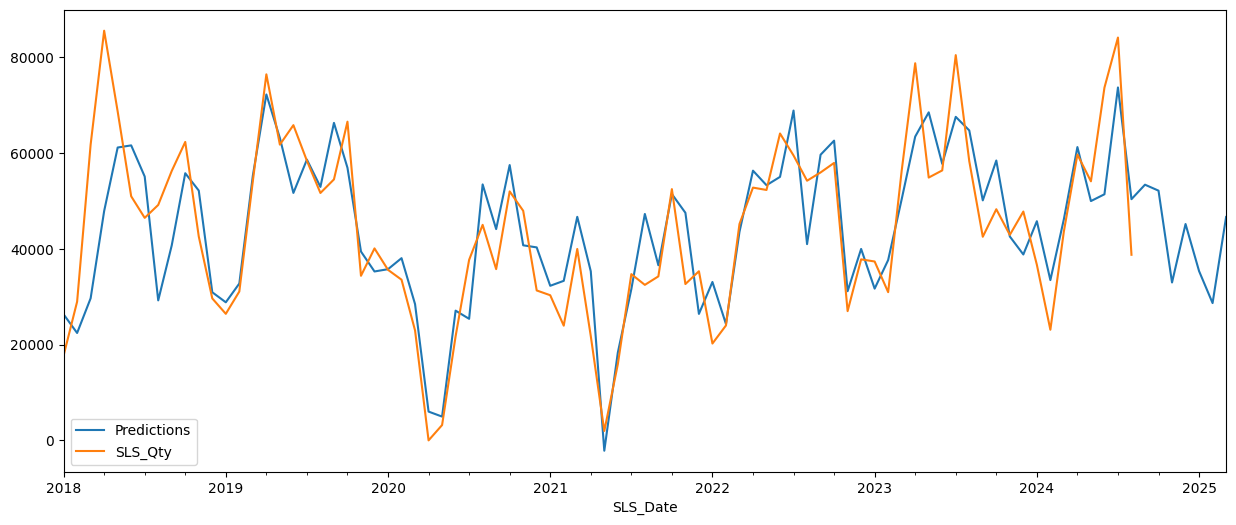

In [0]:
# plot predictions and actual values
predictions_df.plot(figsize=(15,6))
monthly_df['SLS_Qty'][:-7].plot(legend = True)

In [0]:
predictions_df['actual'] = monthly_df['SLS_Qty']
predictions_df['actual'] = predictions_df['actual'].fillna(0)
predictions_df['Predictions'] = np.round(predictions_df['Predictions'])
predictions_df['mape'] = (np.abs(predictions_df['actual']-predictions_df['Predictions'])/predictions_df['actual'])*100
predictions_df['mape'][-7:] = 0
predictions_df[-20:]

,Predictions,actual,mape
2023-08-31,64726.0,58310.0,11.003258
2023-09-30,50121.0,42522.0,17.870749
2023-10-31,58444.0,48269.0,21.079782
2023-11-30,42580.0,42915.0,0.780613
2023-12-31,38822.0,47787.0,18.760332
2024-01-31,45771.0,36683.0,24.774419
2024-02-29,33473.0,23102.0,44.892217
2024-03-31,46206.0,43661.0,5.829001
2024-04-30,61253.0,59697.0,2.606496
2024-05-31,49975.0,54098.0,7.621354


In [0]:
predictions_df[-12:-7]['mape'].mean()

16.56019309067646